### Hacemos lo mismo que en analisis de barra3, pero recalculamos el lbar con el phi

# Analisis de la barra

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Longitud de la barra

In [18]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength as strng
import matplotlib.gridspec as gridspec
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

snapshot=range(496,236,-1) #SNAPSHOTS

for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    pstr = snap['subhalo_000/Str/Coordinates'].value
    mstr = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    
#paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia
#     print 'rgal=', rgal
    
    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa
    
#     print 'r50=', r50
#     print 'r90=', r90
#     print r'log(M+/Msol)=', log10(Mgal*1e10)

#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm


#calculo el raux
#     raux = 2*r50
#------------------------------------------------------------------------------------
    dd = range(496,300,-1)
    dd.remove(428)
    if isnap in dd:
        raux = 2*r50
    elif (isnap == 428) or ((isnap < 301) & (isnap > 283)):
        raux = r50
    elif (isnap > 271) & (isnap < 284):
        raux = 0.75
    elif isnap < 272:
        raux = 0.5
#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,raux)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    
    corte1,=np.where(r<rgal)
    
#     if isnap in range(256,272):
#         corte2 = np.where(r<0.75)
#     else:
#         corte2 = np.where(r<raux)

    corte1, = np.where(r<4*r50)
    corte2, = np.where(r<raux)
    corte3, = np.where(r<2*r50)

    A2, phi, rbin = strng.a2(mstr[corte3], xn[corte3], yn[corte3], 30)
    A2max, rmax, phimax = strng.a2max(mstr[corte3], xn[corte3], yn[corte3], 20)

    
# med = mean(phi[1:5])

    phii = phi - phimax

    for i in range(1,len(phii)-2):
        if ((phii[i]<np.arcsin(0.3)) & (phii[i]>-np.arcsin(0.3)) & (phii[i+1]>np.arcsin(0.3))):
            if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
                pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
                ordenada = phii[i]- pend*rbin[i]
                lbar = (np.arcsin(0.3) - ordenada)/pend
                break
        elif ((phii[i]>-np.arcsin(0.3)) & (phii[i]<np.arcsin(0.3)) & (phii[i+1]<-np.arcsin(0.3))):
            if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
                pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
                ordenada = phii[i]- pend*rbin[i]
                lbar = (-np.arcsin(0.3) - ordenada)/pend
                break
#     print lbar

    #Guargamos los parámetros en distintos archivos
#----------------------------------------------------------------------------------
    archivo1 =  open('/home/ornela/python/SAN/lbar_time3.dat','a')
    archivo1.write(str('%03d'% isnap) +'\t'+
               str('%12.6f'% time) +'\t'+
               str('%12.6f'% lbar) +'\n')
    archivo1.close()
#------------------------------------------------------------------------------------



In [6]:
import pandas

/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


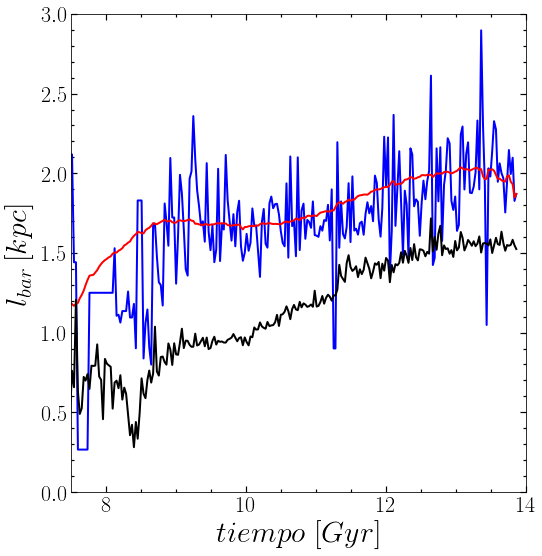

In [8]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

cm = np.loadtxt('/home/ornela/python/barras/lbar_time.dat')
time0 = cm[:,1]
lbar0 = cm[:,2]

# cm = np.loadtxt('/home/ornela/python/SAN/lbar_time3.dat')
# time = cm[:,1]
# lbar = cm[:,2]

cm = np.loadtxt('/home/ornela/python/SAN/lbar_time2.dat')
time1 = cm[:,1]
lbar1 = cm[:,2]

# cm = np.loadtxt('/home/ornela/python/SAN/lbar_time.dat')
# time2 = cm[:,1]
# lbar2 = cm[:,2]

# def movingaverage(interval,window_size):
#     window = numpy.ones(int(window_size))/float(window_size)
#     return numpy.convolve(interval, window, 'same')
# lbar_mean = movingaverage(lbar1,30)

lbar_mean=pandas.rolling_mean(lbar1, 50, min_periods=1)

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)

# ax.plot(time,lbar,'-', lw=2, color='r')
ax.plot(time1,lbar1,'-', lw=2, color='b')
ax.plot(time1,lbar_mean, lw=2, color='r')
# ax.plot(time2,lbar2,'-', lw=2, color='g')
ax.plot(time0,lbar0,'-', lw=2, color='k')
ax.set_xlim(7.5,14)
ax.set_ylim(0,3)
# ax.spines['bottom'].set_color('w')
# ax.spines['top'].set_color('w')
# ax.spines['left'].set_color('w')
# ax.spines['right'].set_color('w')
ax.minorticks_on()
ax.tick_params( labelsize=22)#, colors='lightgray')
ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')#,colors='w')
ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')#,colors='w')  
# ax.set_facecolor('silver')
# ax.grid(color='w',linestyle=':',which='major')
#ax.grid(color='lightgray',linestyle=':',which='minor')
ax.set_xlabel(r'$tiempo$ $[Gyr]$', fontsize=30)#, color='lightgray')
ax.set_ylabel(r'$l_{bar}\:[kpc]$',fontsize=30)#, color='lightgray')
# fig.savefig('/home/ornela/Dropbox/Presentaccion_AAA/lbar_time.png', dpi = 100)
plt.show()

time= 13.8666332331 lbar= 1.93297328765


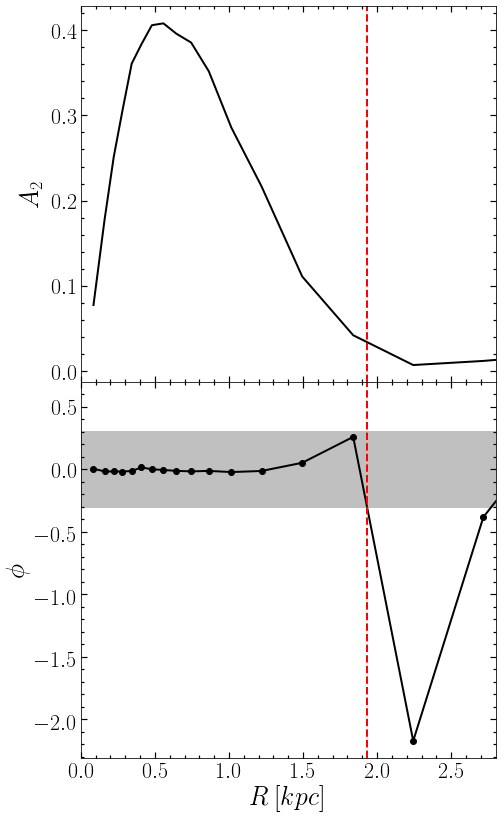

time= 13.8406372862 lbar= 1.92092517568


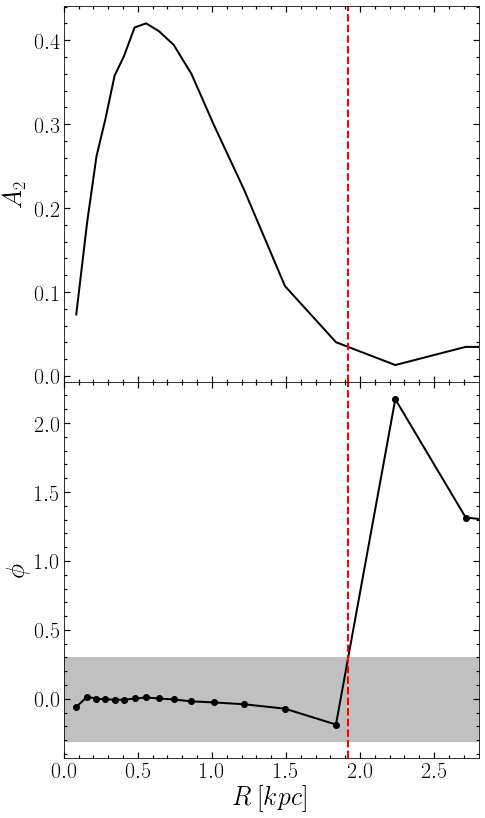

time= 13.8146104515 lbar= 1.8693625245


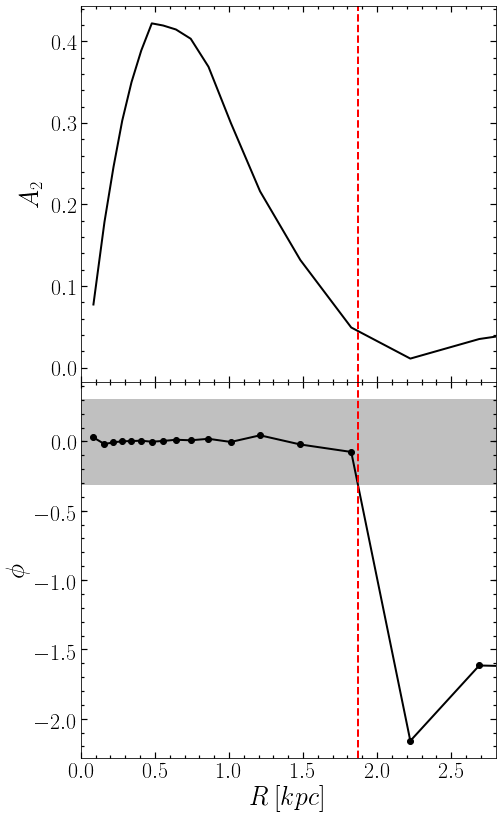

time= 13.7871803973 lbar= 1.90129055444


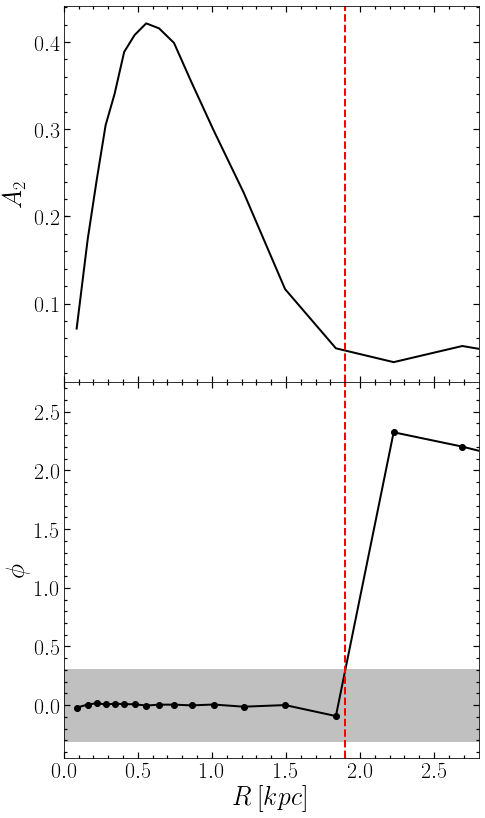

time= 13.7610901133 lbar= 2.08086530335


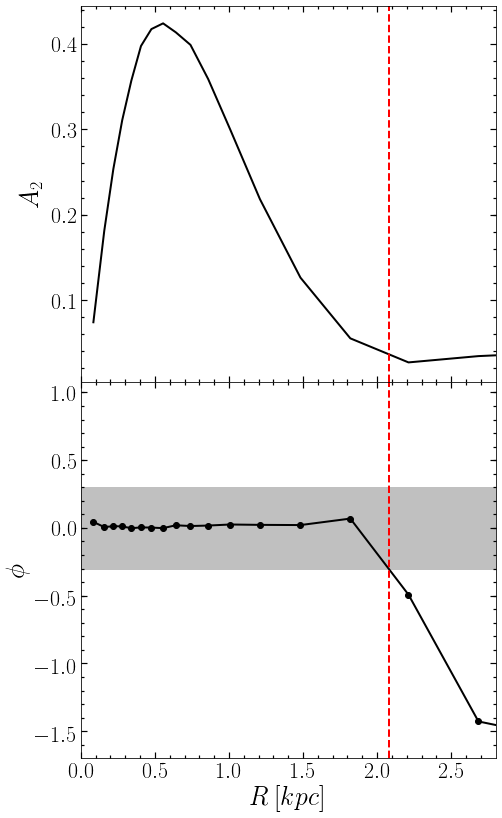

time= 13.7349688957 lbar= 1.5275874701


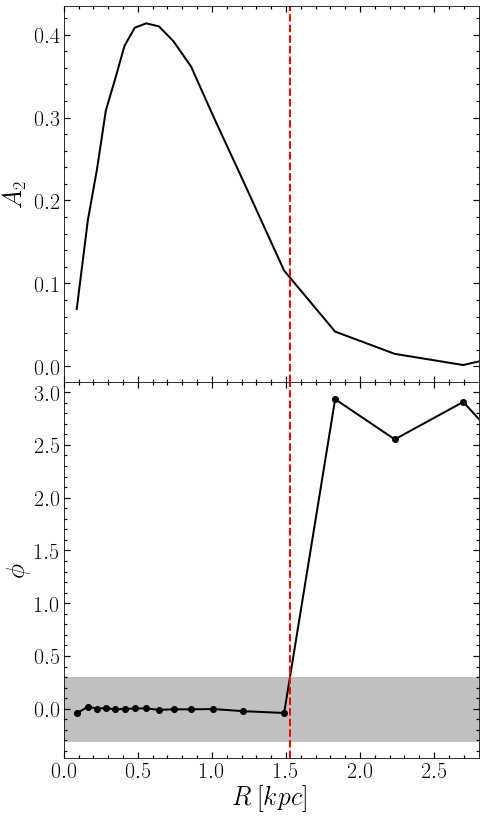

time= 13.7088167306 lbar= 1.77851534877


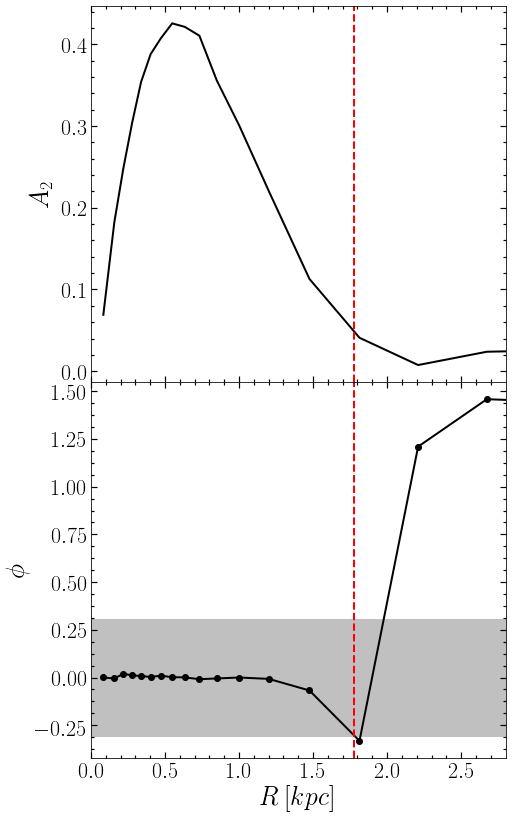

time= 13.6812546872 lbar= 1.88416738826


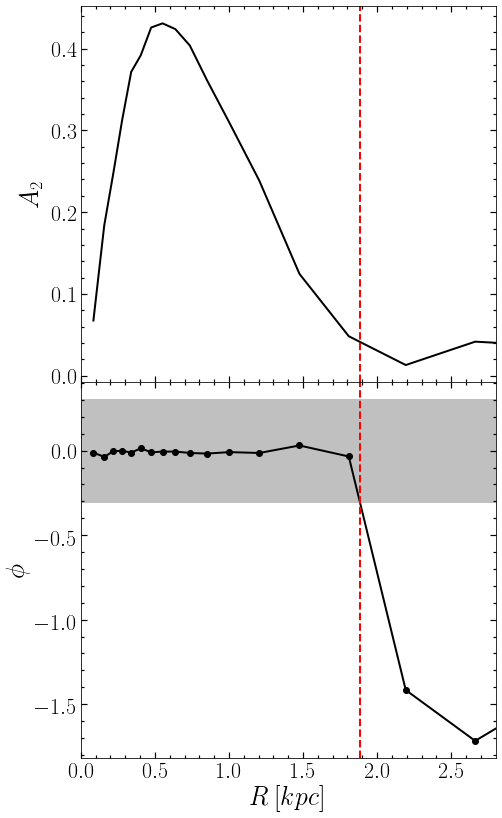

time= 13.6550389564 lbar= 1.91469131702


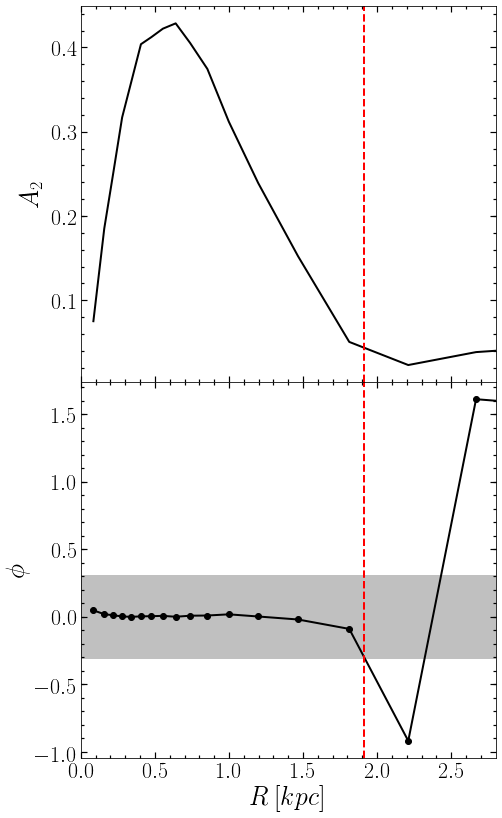

time= 13.6287922385 lbar= 2.04663545409


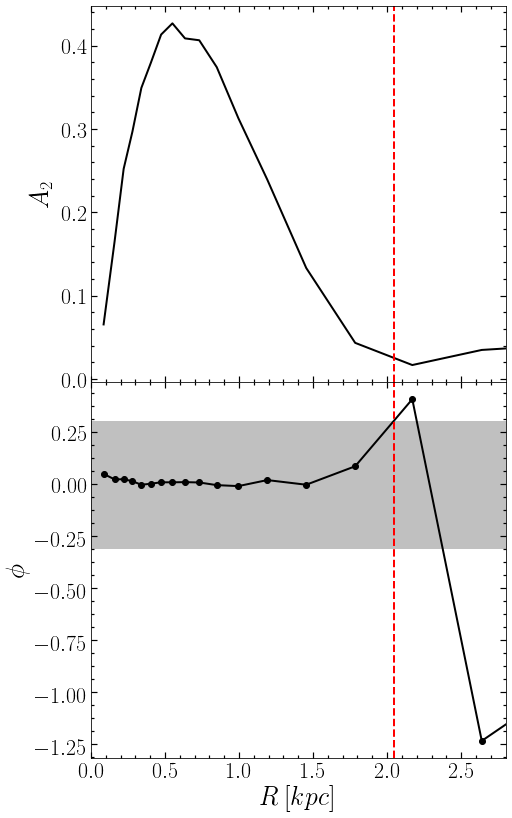

time= 13.6025145216 lbar= 1.83394467977


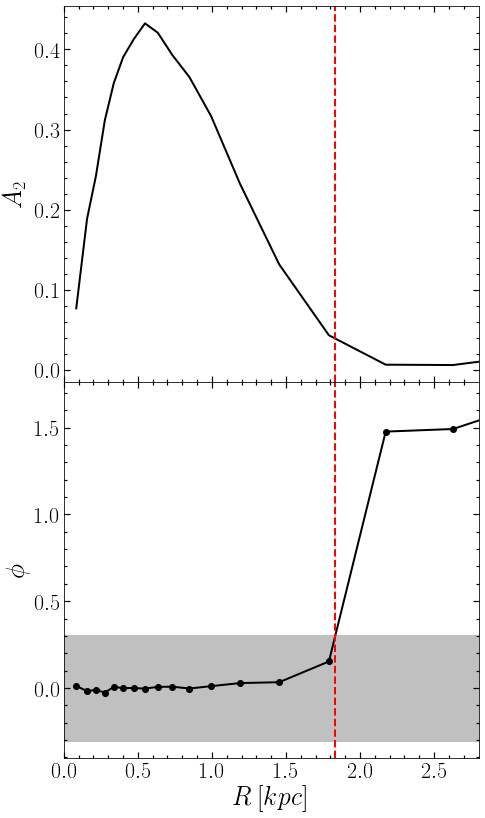

time= 13.5762057945 lbar= 1.99766769361


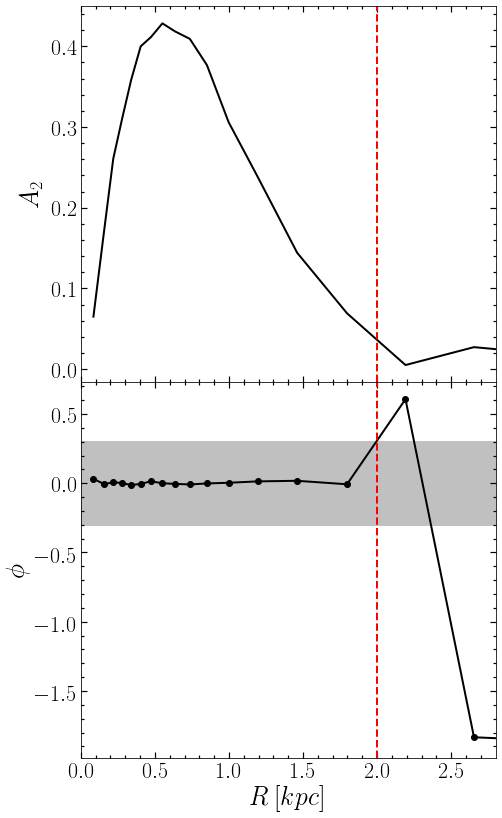

time= 13.5484788842 lbar= 2.22572887287


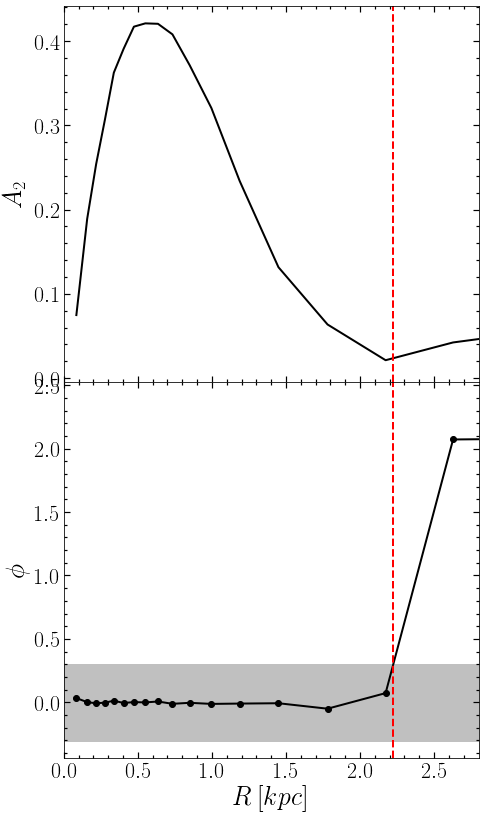

time= 13.5221064712 lbar= 2.34717439745


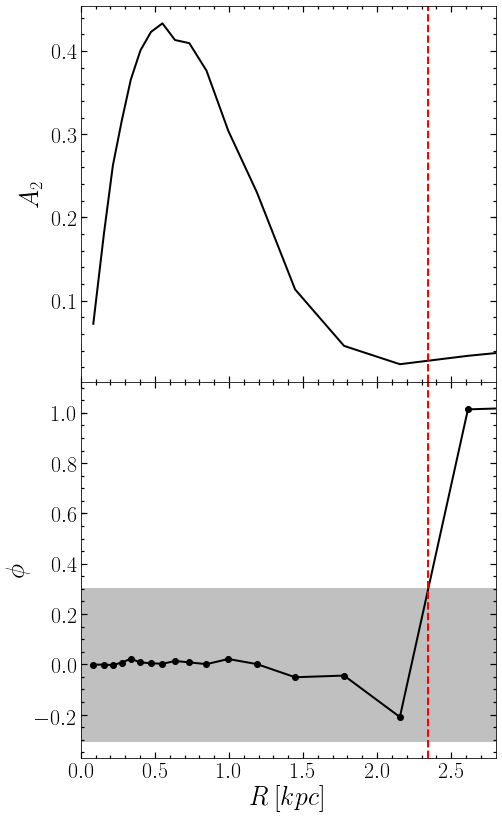

time= 13.4957030168 lbar= 1.85909047908


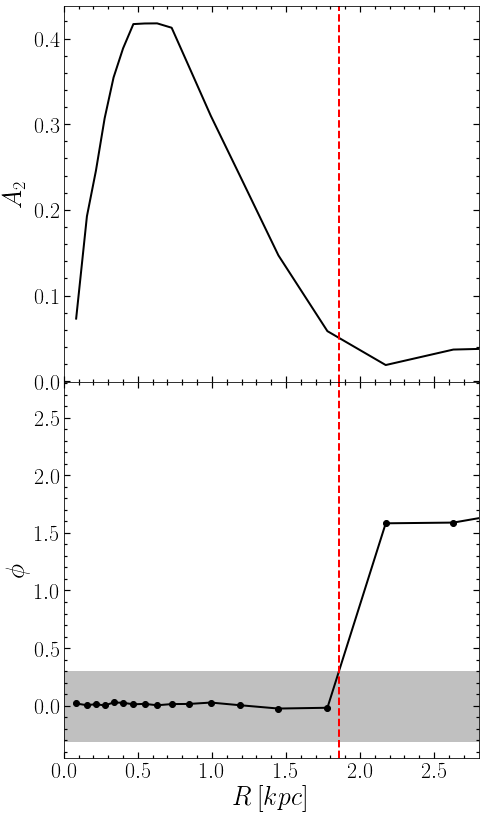

time= 13.4692685119 lbar= 1.86883844366


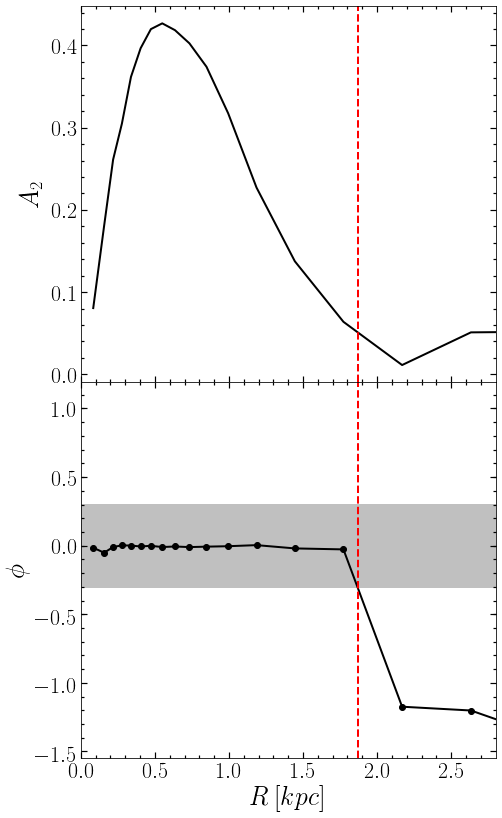

time= 13.4428029481 lbar= 0.0903458621594


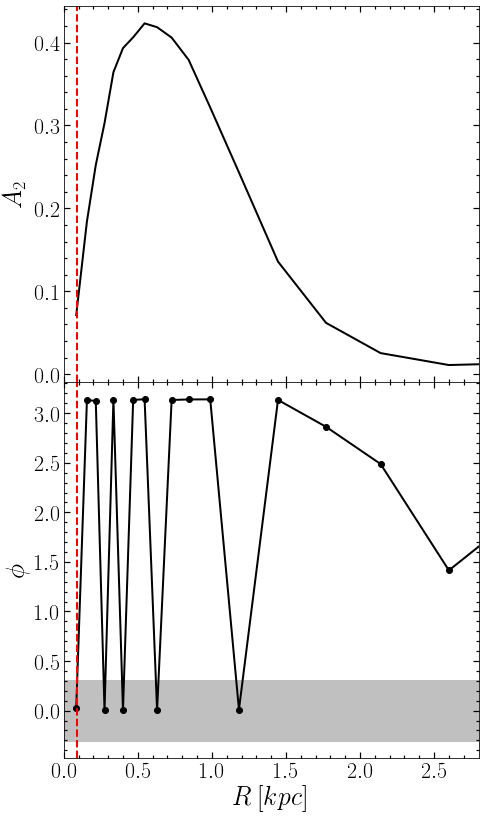

time= 13.4177016516 lbar= 1.84533957357


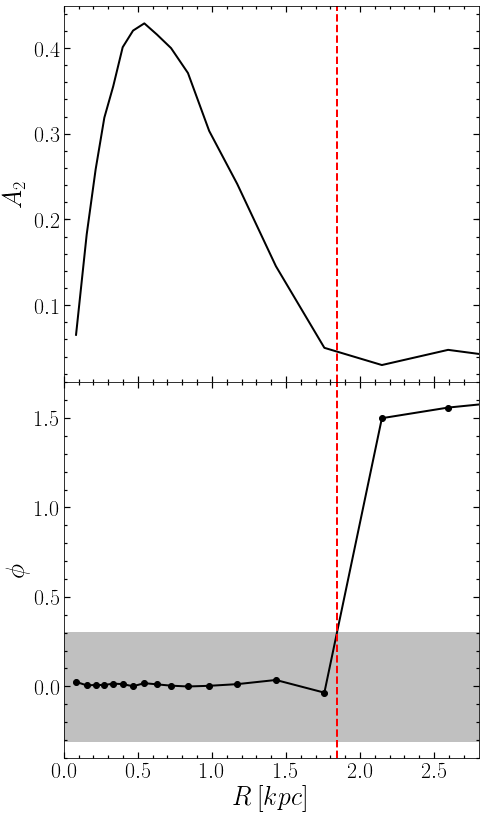

time= 13.3911755825 lbar= 2.20866742674


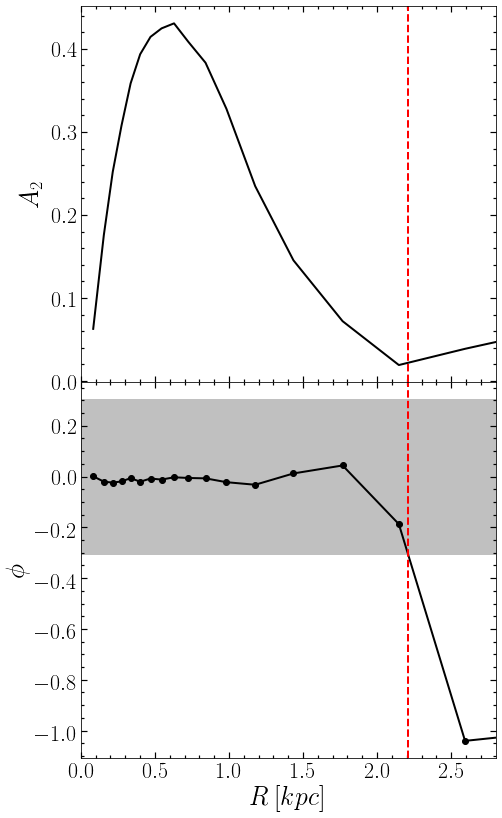

time= 13.3646184328 lbar= 2.0910413956


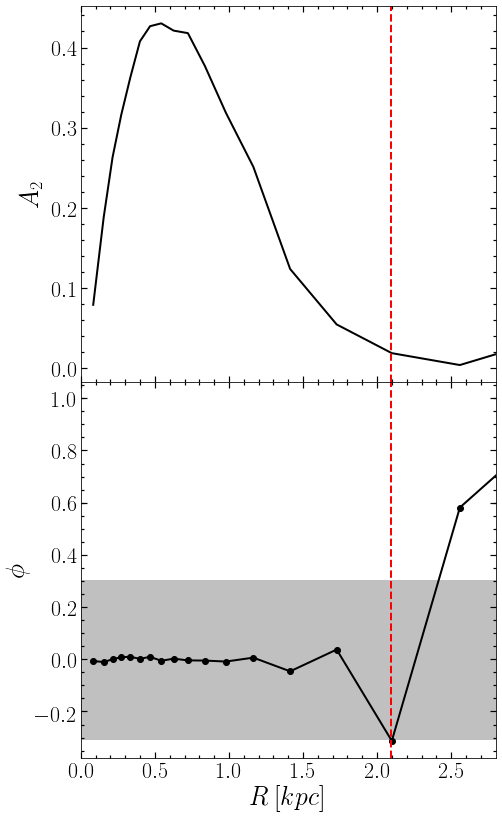

time= 13.3380301966 lbar= 1.80363740455


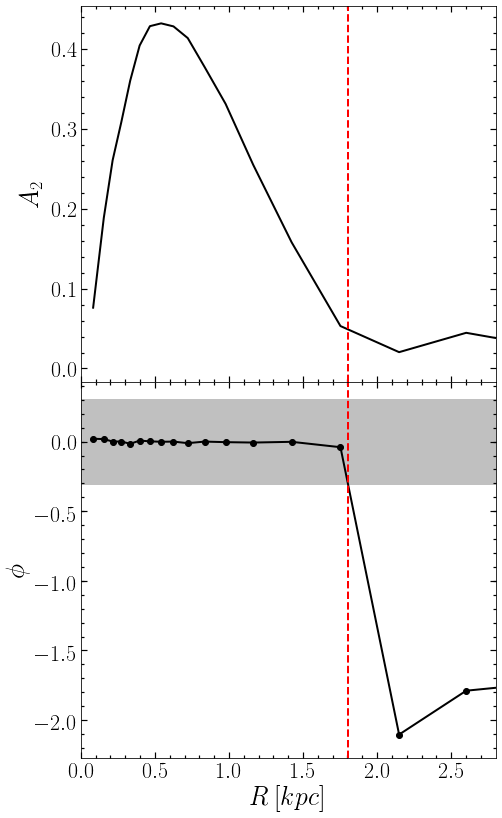

time= 13.3114108683 lbar= 2.21387031339


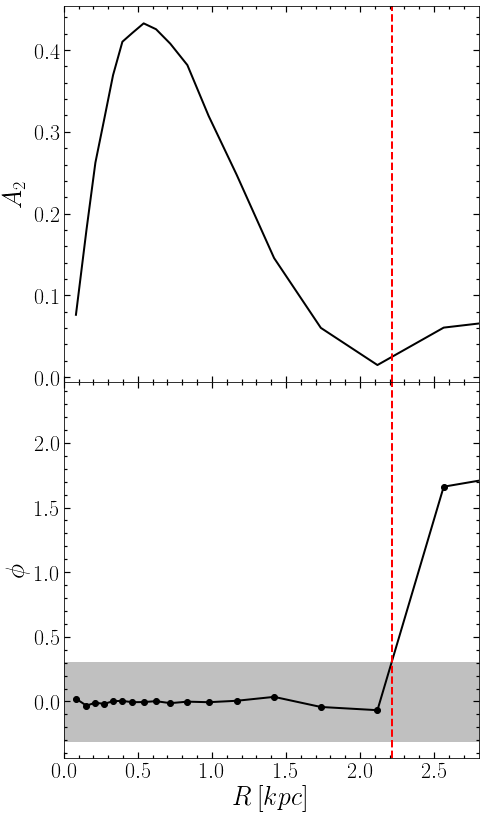

time= 13.284760443 lbar= 1.96836958592


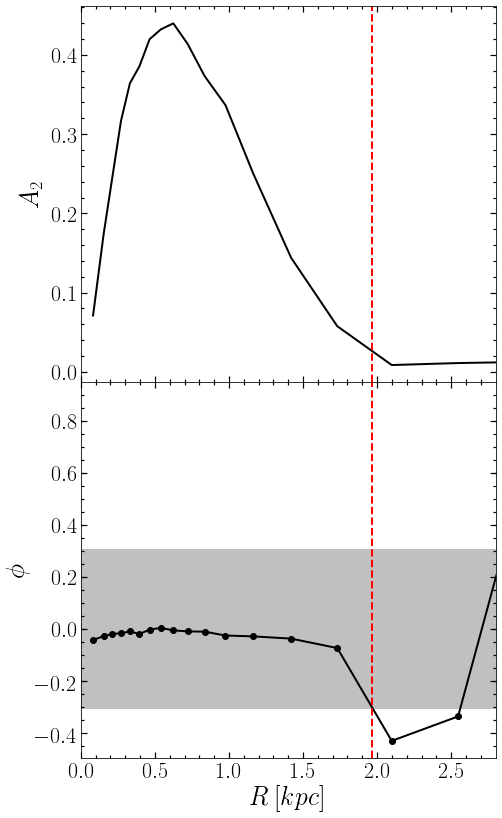

time= 13.2580789165 lbar= 1.81861562522


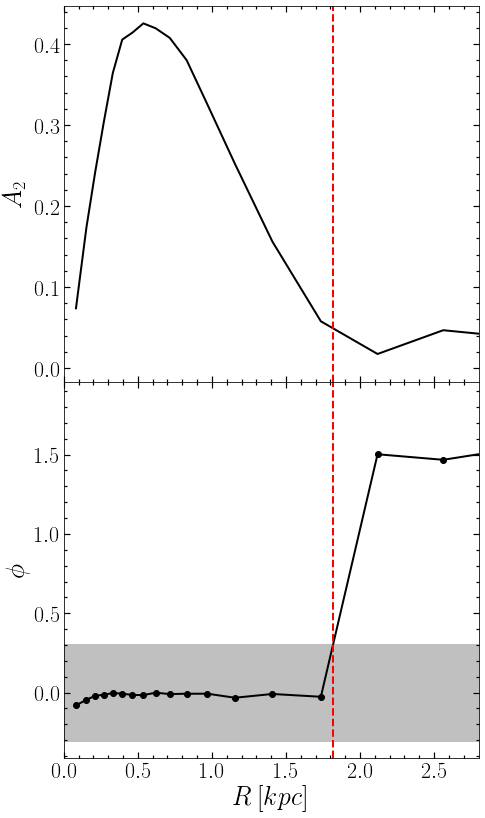

time= 13.2313662851 lbar= 2.27431048408


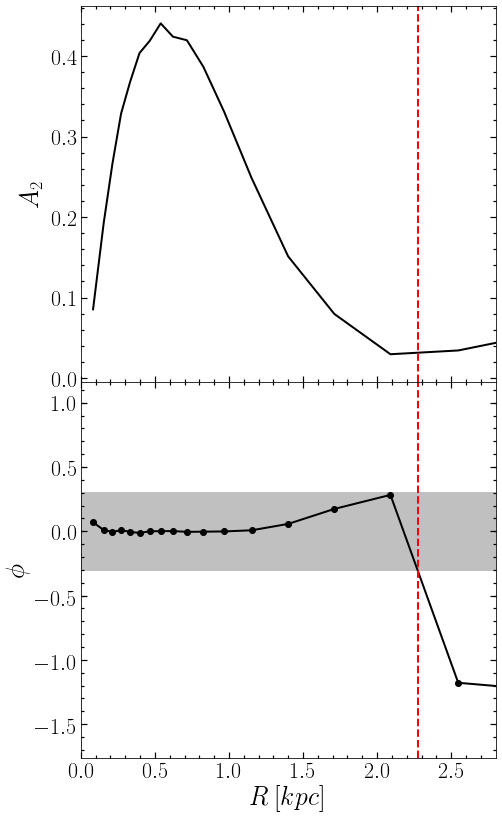

time= 13.2046225459 lbar= 1.76433291297


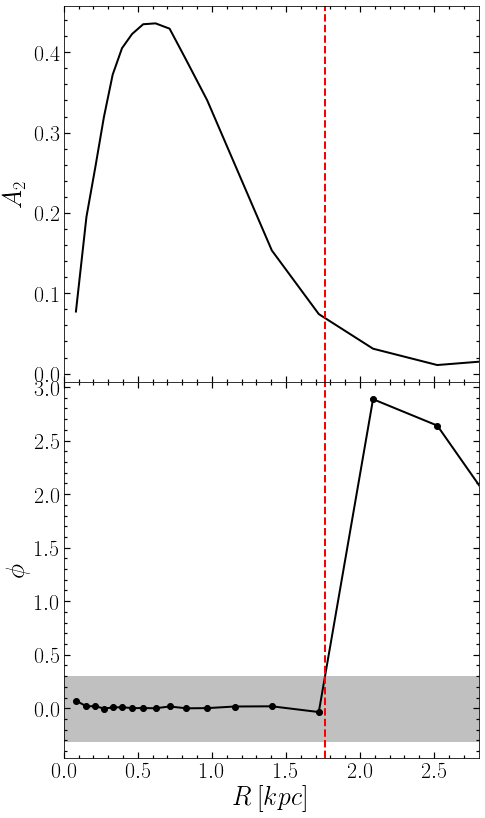

time= 13.1778476966 lbar= 2.09091960898


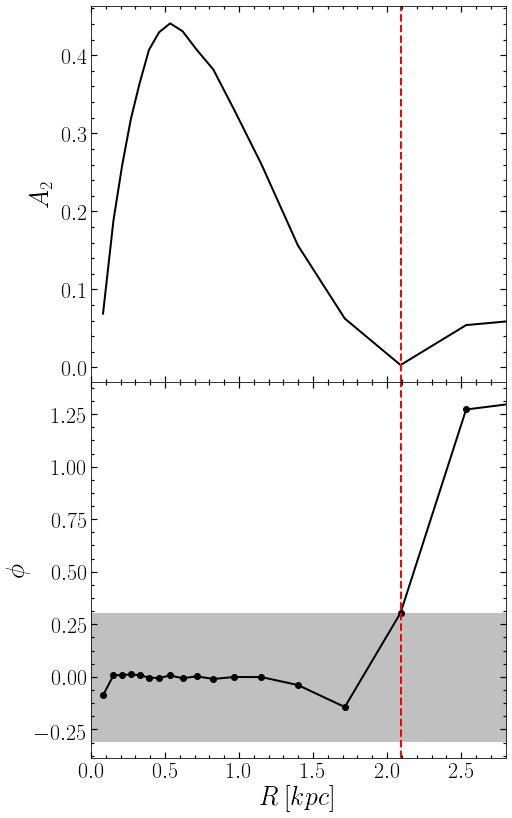

time= 13.1510417355 lbar= 2.27620202836


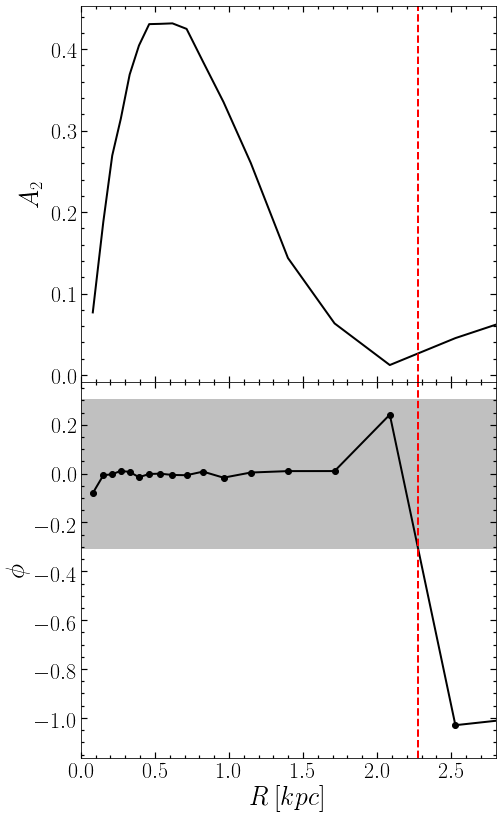

time= 13.1256179149 lbar= 2.68303368817


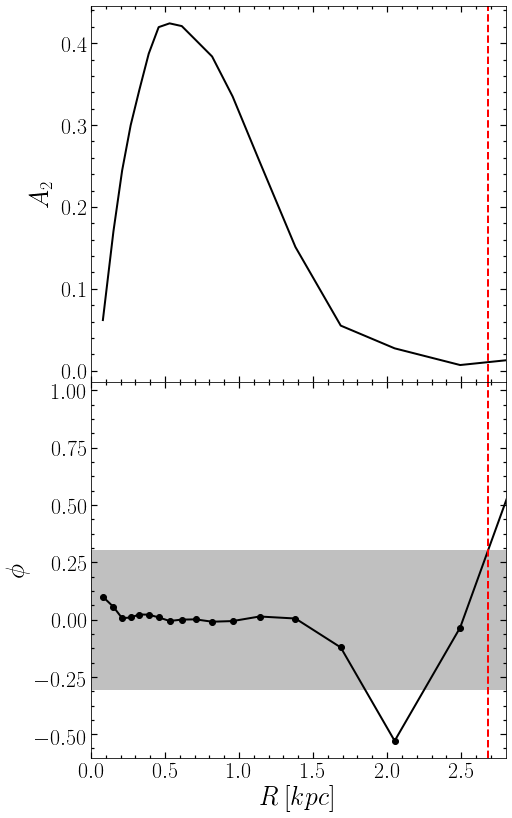

time= 13.0987513655 lbar= 2.18571735491


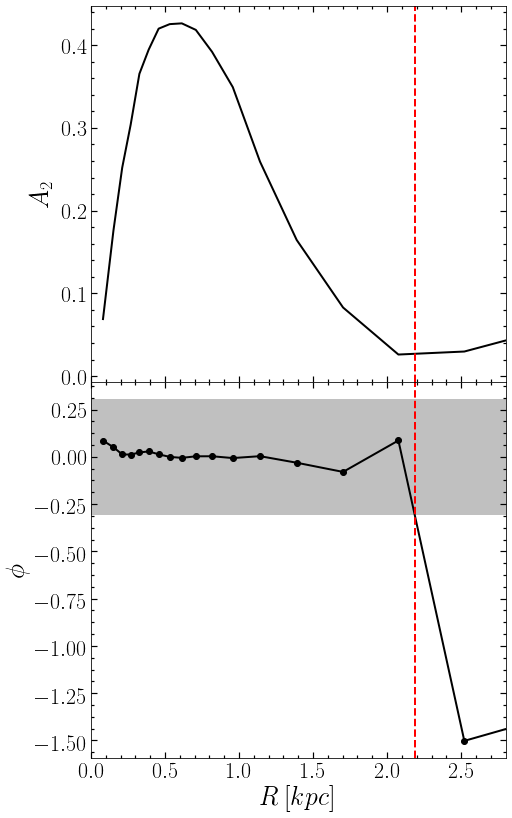

time= 13.0732701454 lbar= 2.14490584868


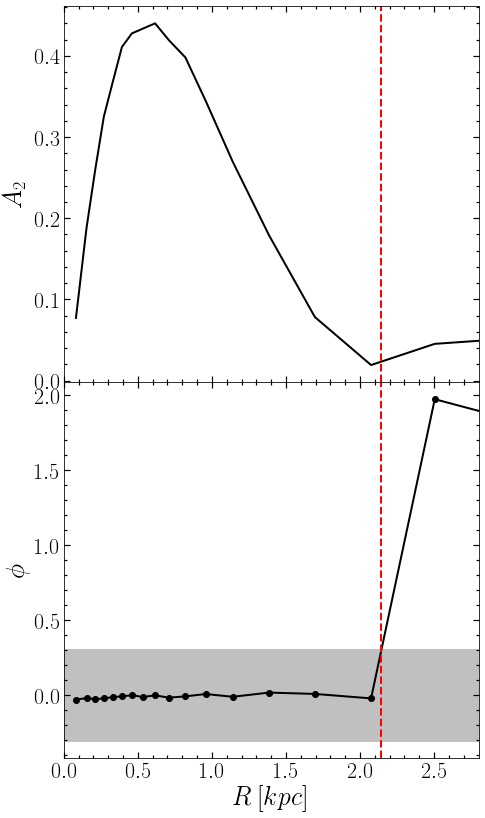

time= 13.0463430091 lbar= 1.70670237973


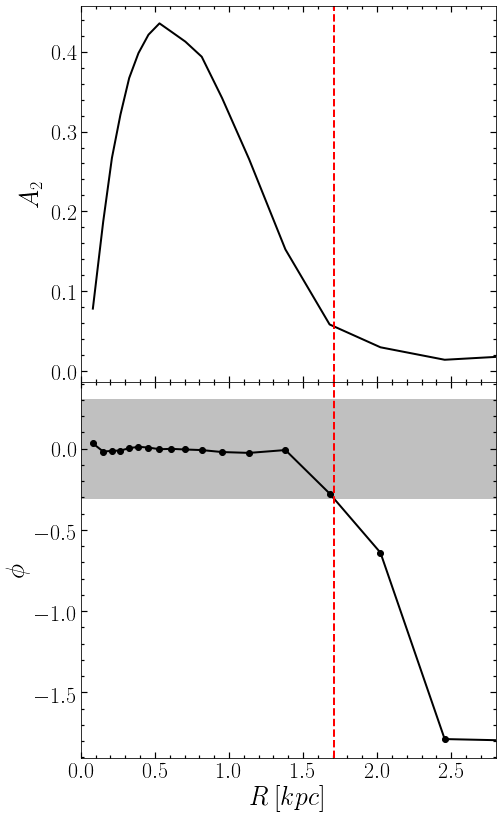

time= 13.0193847626 lbar= 1.72617151455


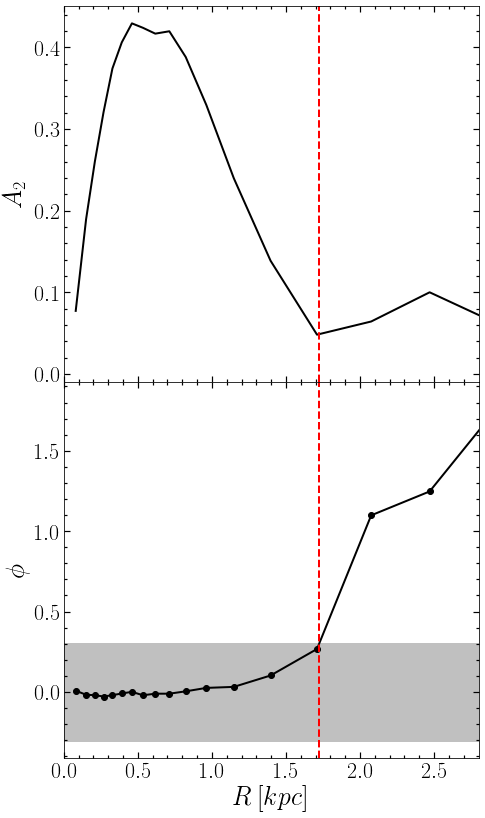

time= 12.9938166763 lbar= 1.94155479788


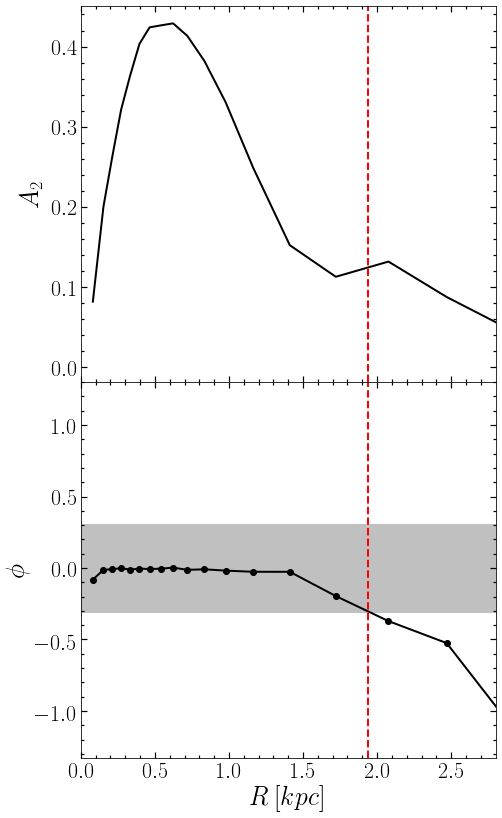

time= 12.9667978547 lbar= 1.7349407668


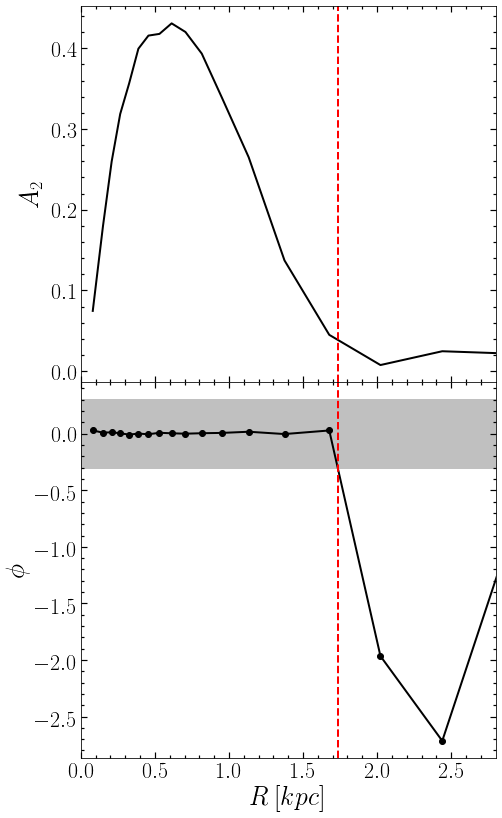

time= 12.9397479322 lbar= 1.7730706366


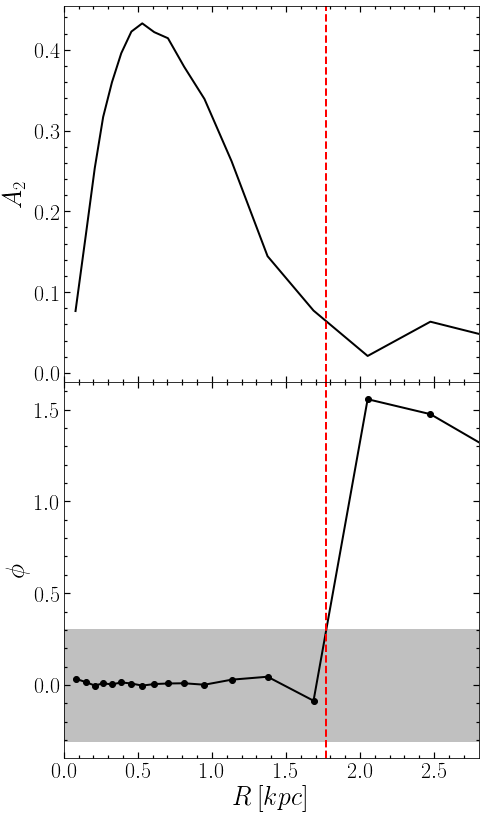

time= 12.9140930052 lbar= 2.12203025973


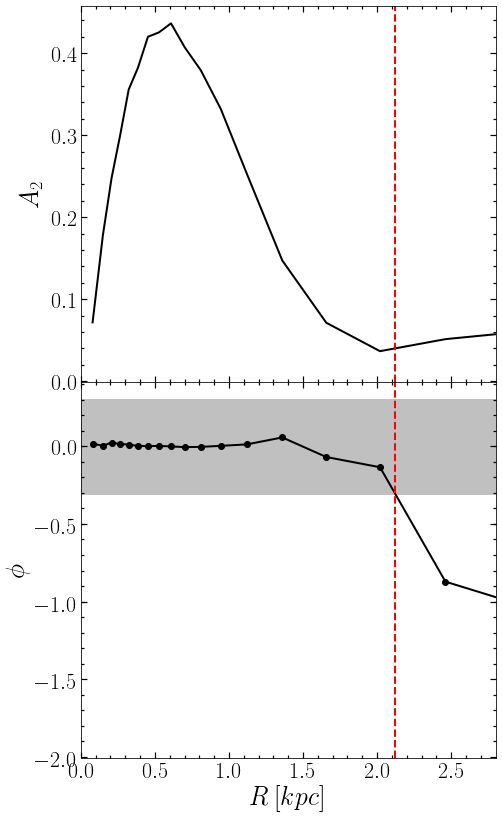

time= 12.8869825315 lbar= 1.8968590285


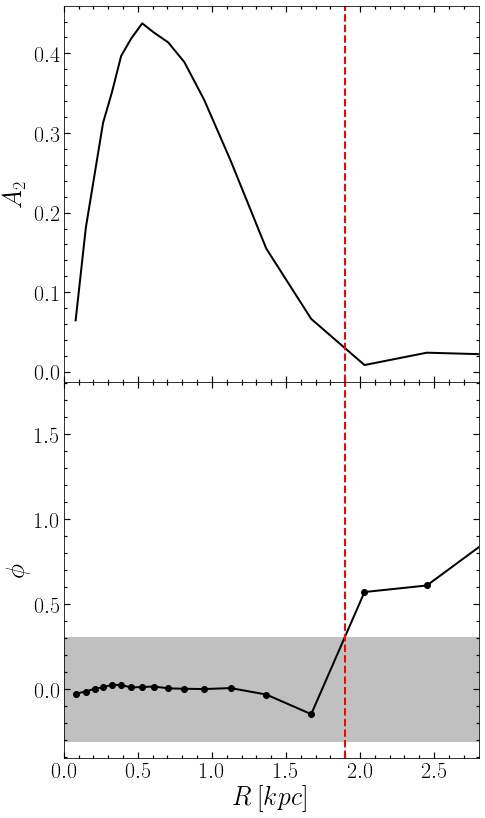

time= 12.8598409725 lbar= 1.74210087633


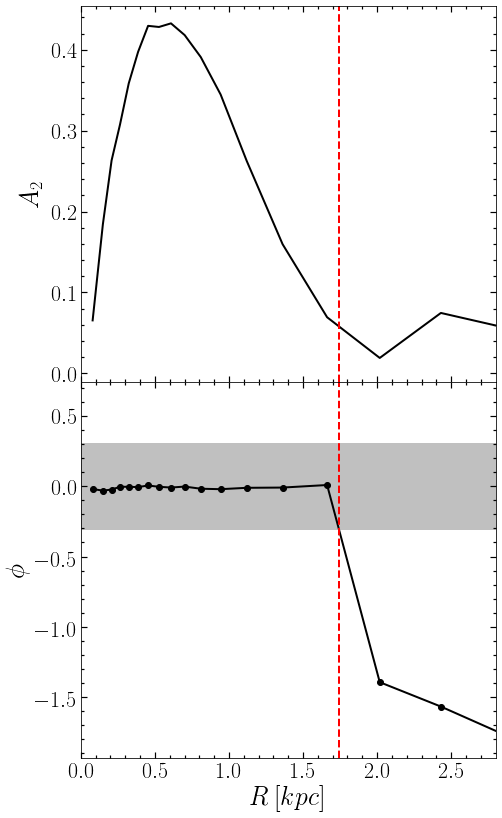

time= 12.8340992483 lbar= 2.0382782328


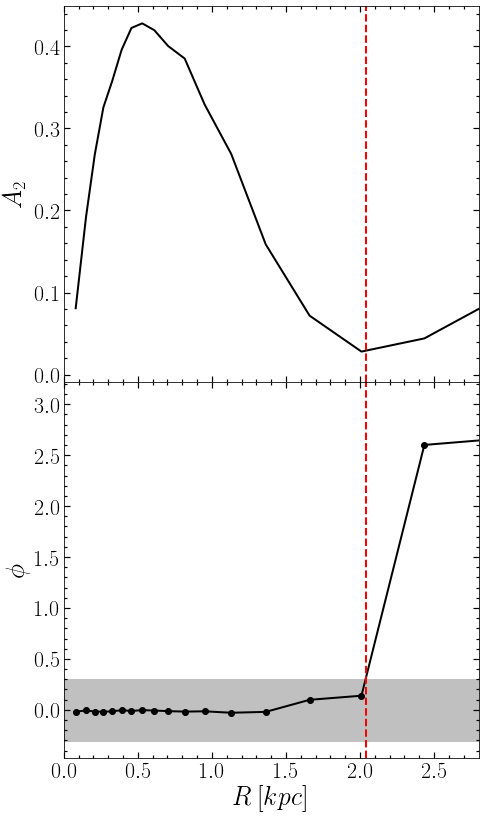

time= 12.8068971747 lbar= 1.58437649841


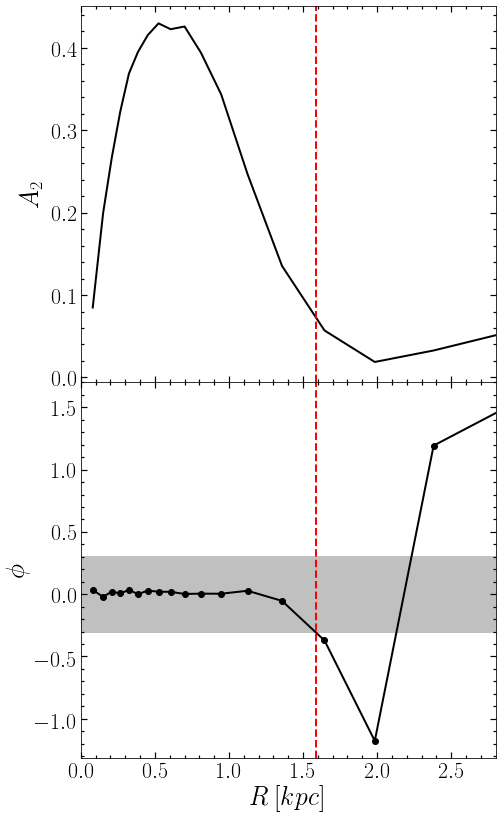

time= 12.7810981352 lbar= 1.85881039328


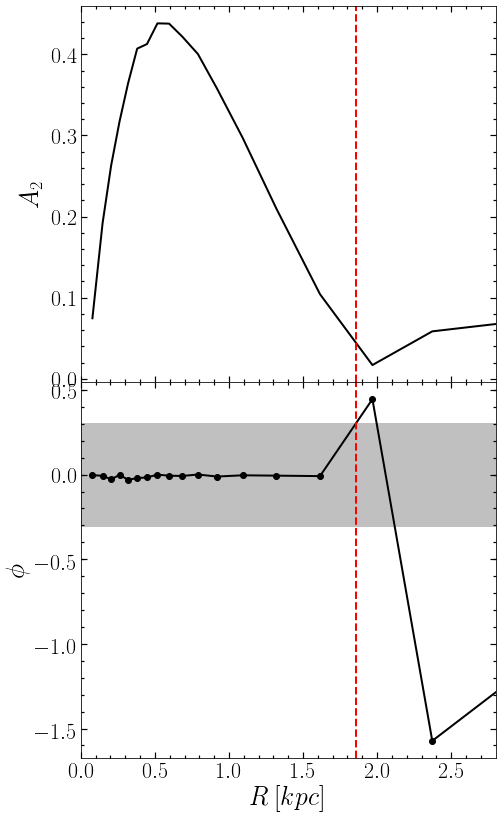

time= 12.7538355783 lbar= 1.74408080949


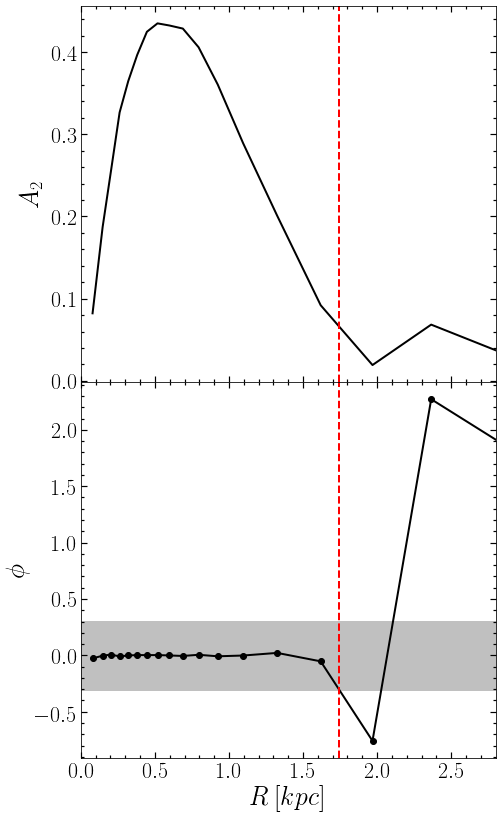

time= 12.7279792558 lbar= 2.06522053157


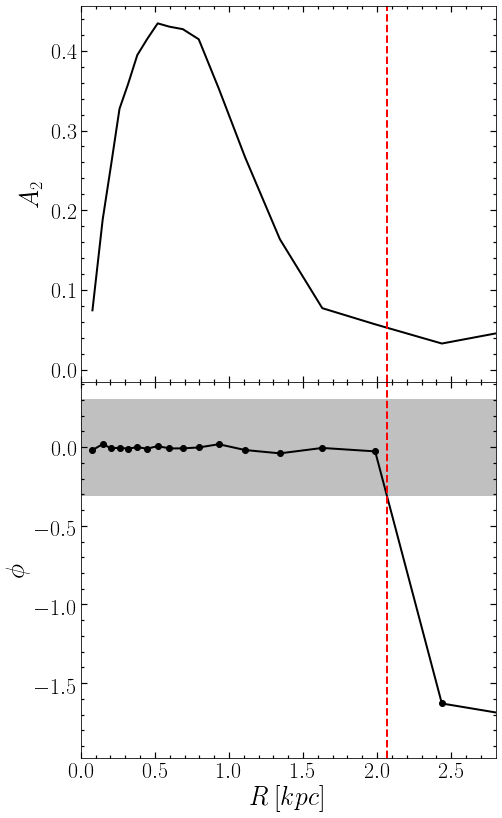

time= 12.7006562529 lbar= 1.40285277933


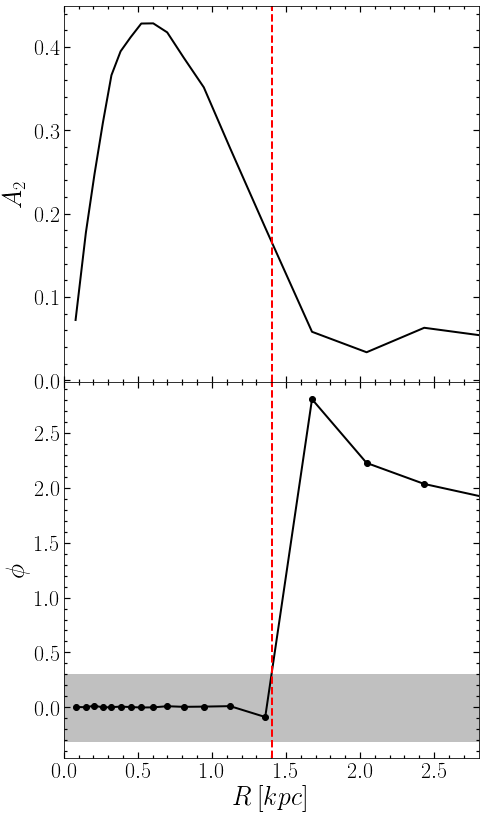

time= 12.6747426854 lbar= 1.33836437885


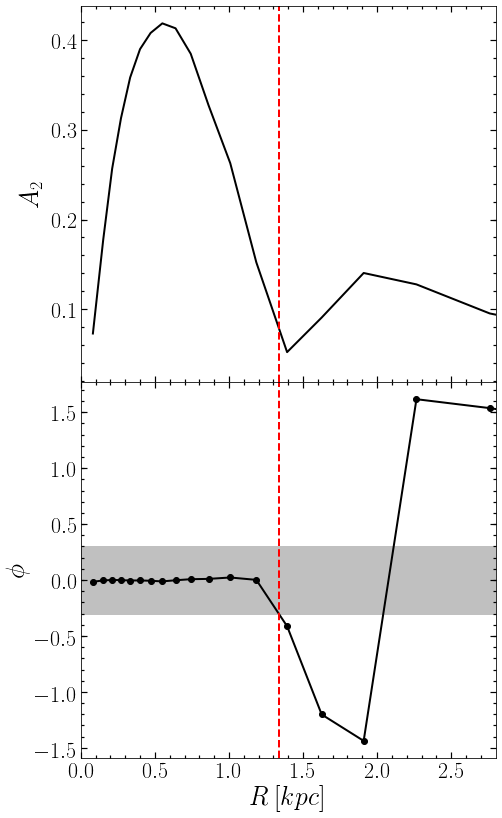

time= 12.6473592796 lbar= 2.44813373046


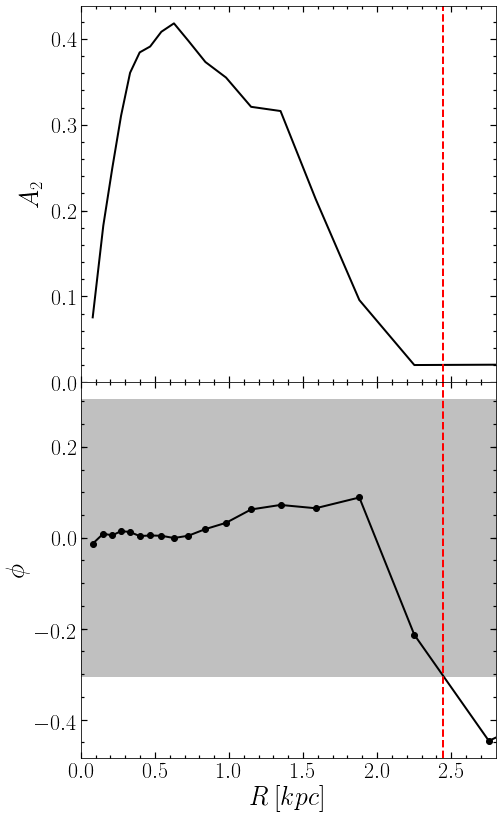

time= 12.6213885109 lbar= 2.00945911876


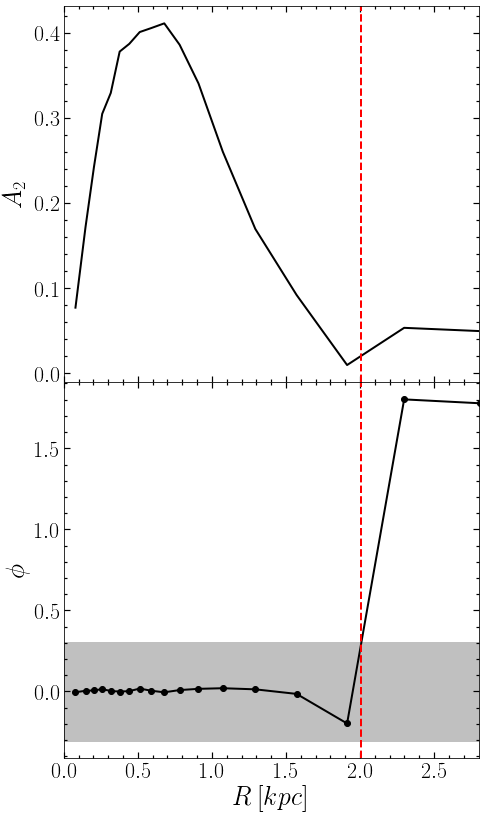

time= 12.5939447514 lbar= 2.03337599789


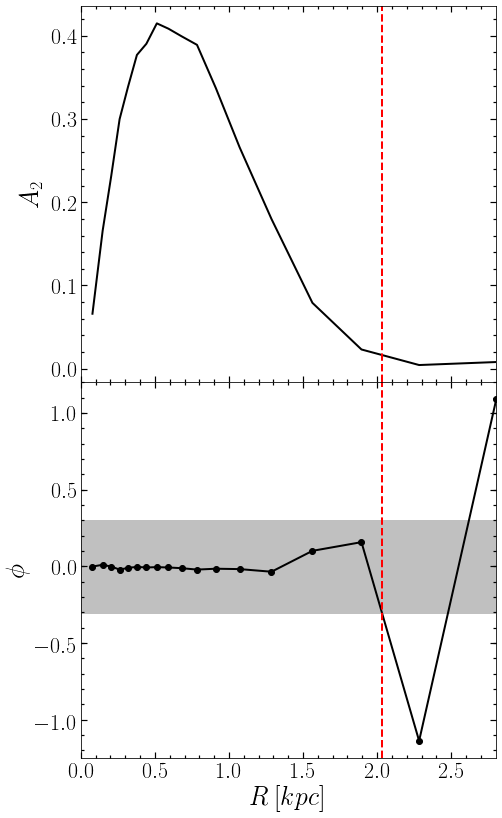

time= 12.5679168309 lbar= 1.90201139072


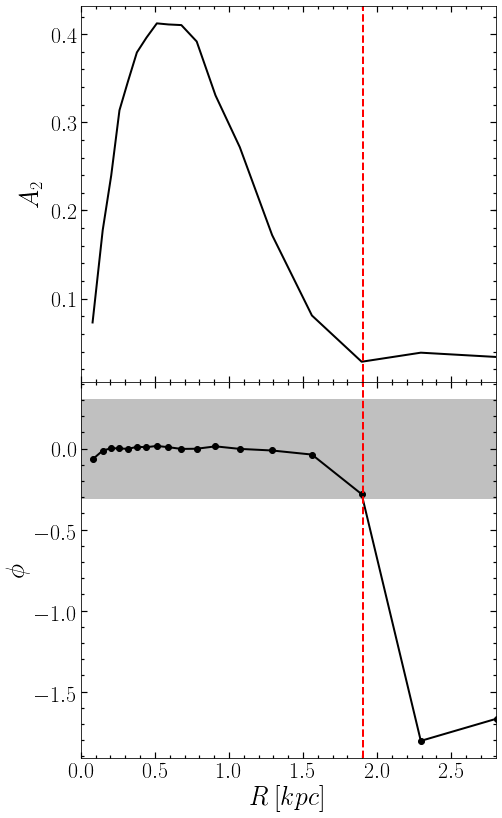

time= 12.5404127731 lbar= 1.69834909091


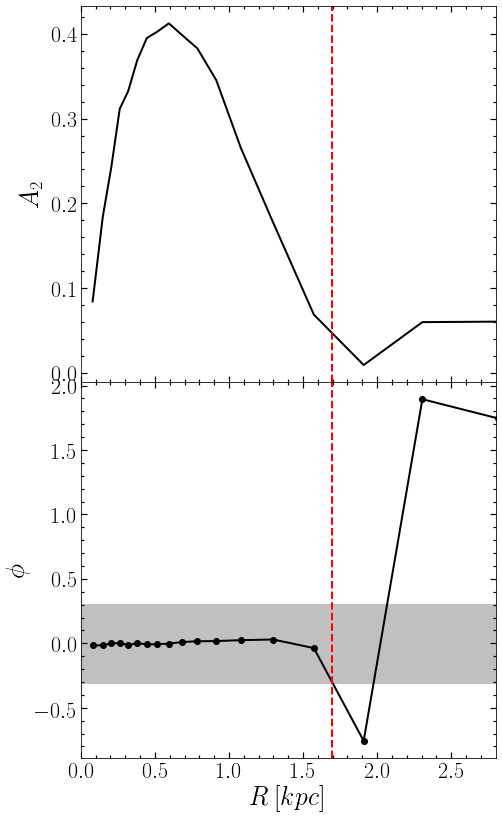

time= 12.5143277564 lbar= 1.76662444146


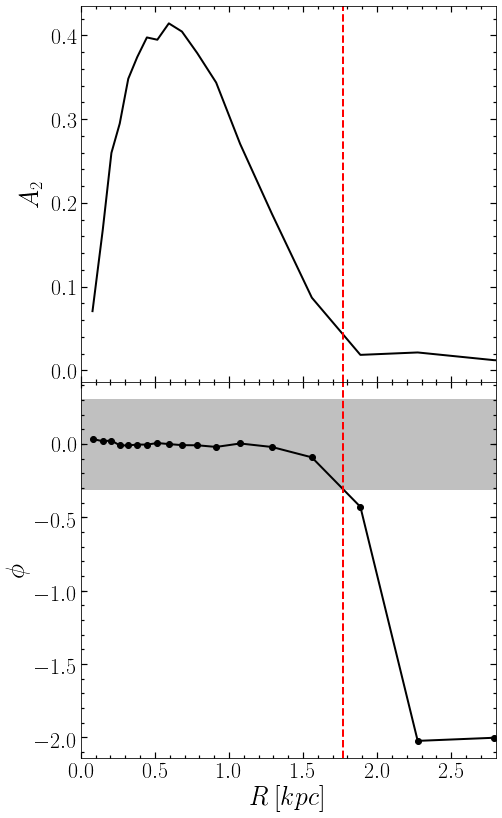

time= 12.4882149851 lbar= 1.31846773783


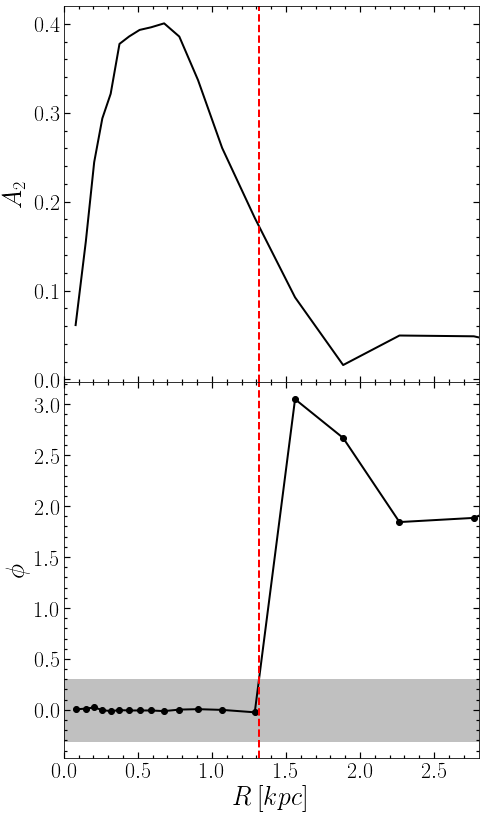

time= 12.4606214108 lbar= 1.66366220664


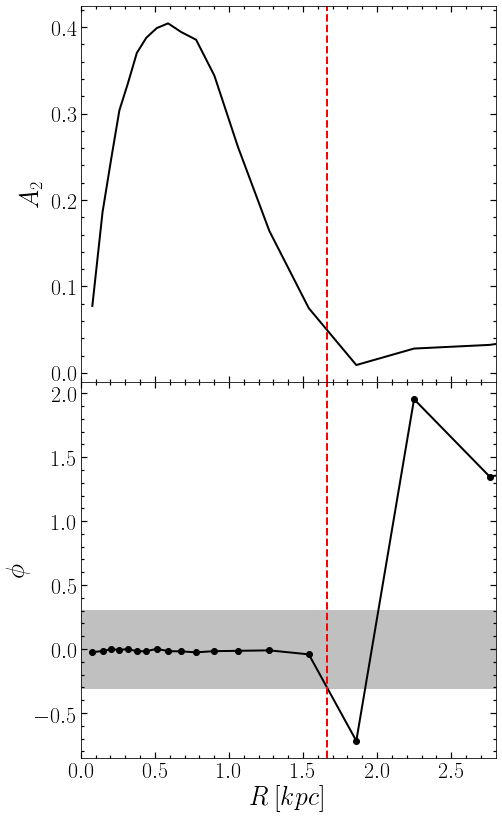

time= 12.4344516371 lbar= 1.74017309468


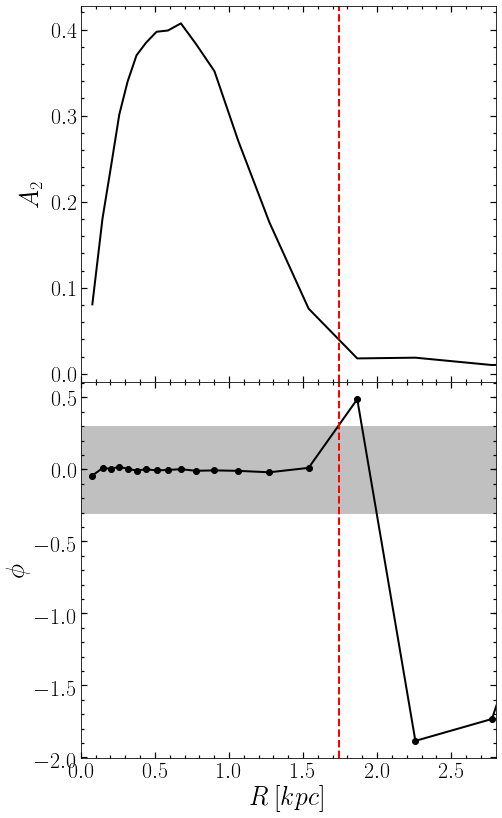

time= 12.4067979301 lbar= 1.57524944092


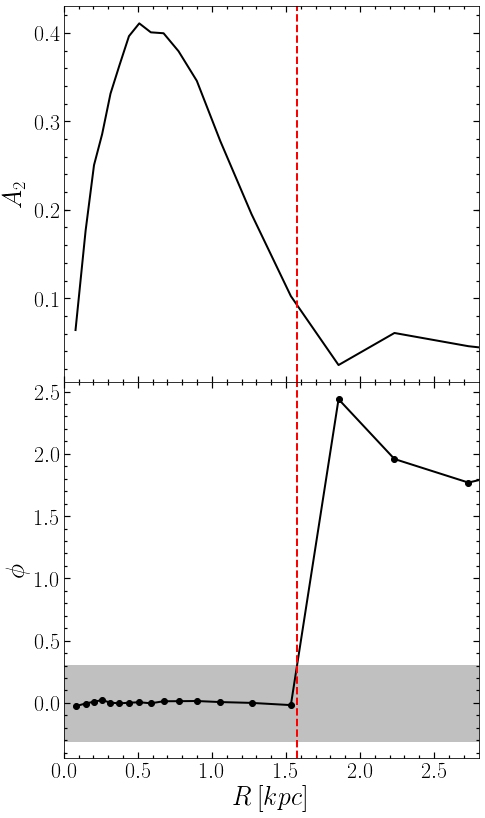

time= 12.3805712248 lbar= 1.94508694878


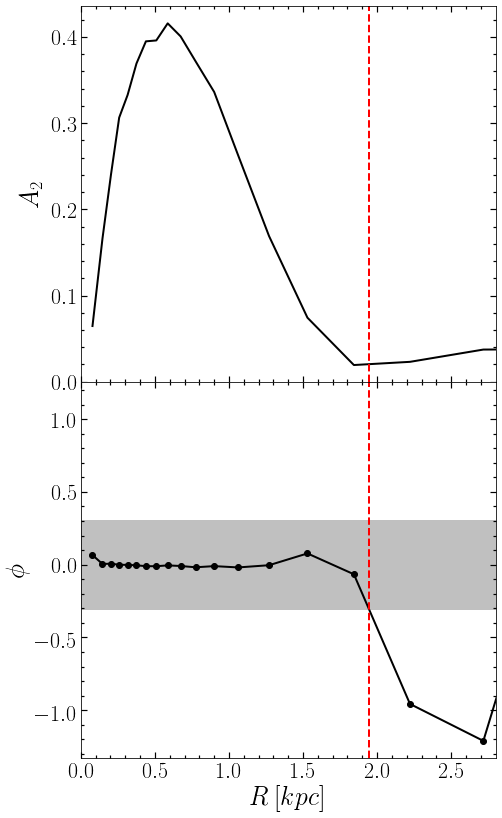

time= 12.3543168507 lbar= 1.92367188048


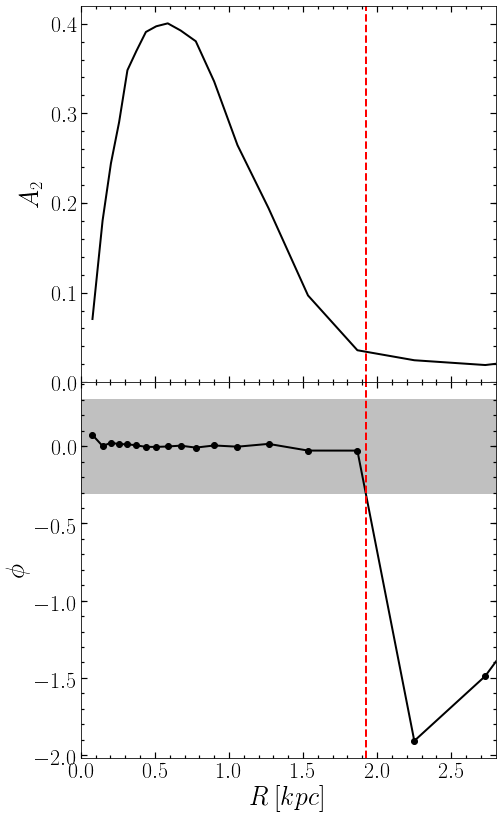

time= 12.3265739039 lbar= 1.30346248829


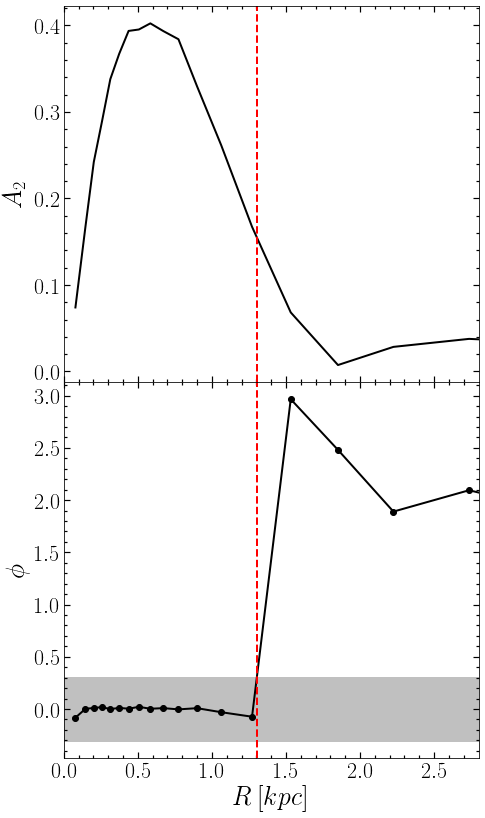

time= 12.3002627154 lbar= 1.67760027109


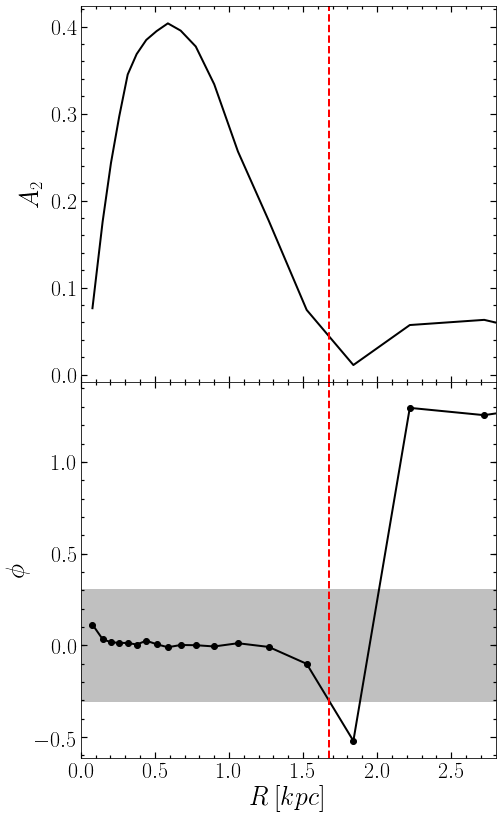

time= 12.2739239185 lbar= 1.93221340097


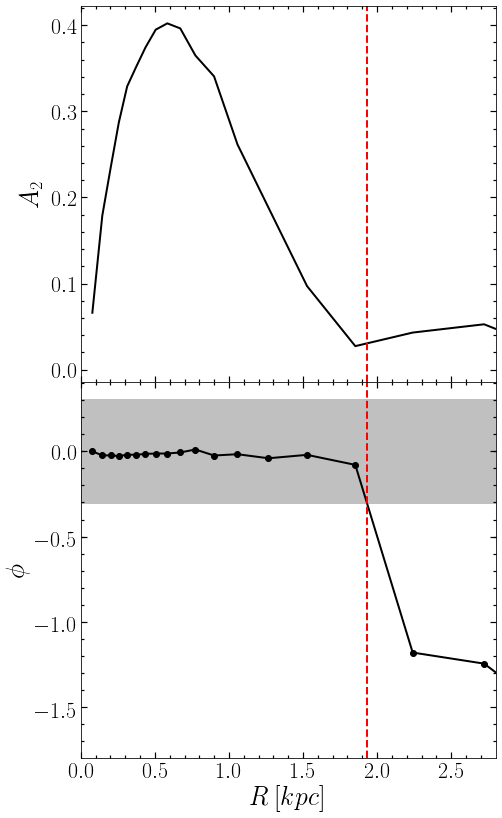

time= 12.2475575347 lbar= 1.55217779522


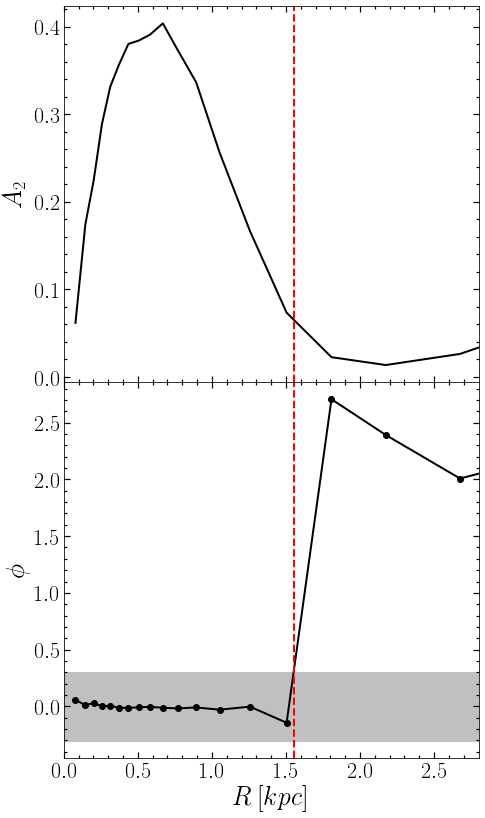

time= 12.2211635861 lbar= 1.85735968539


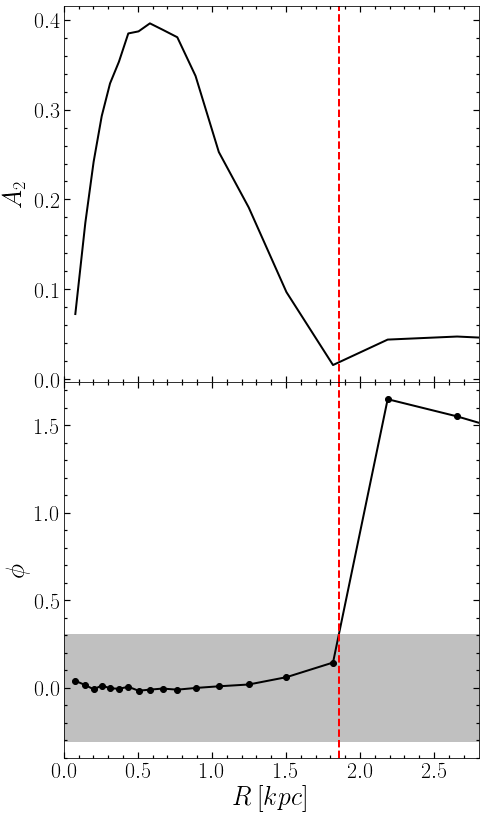

time= 12.1947420956 lbar= 3.23334617616


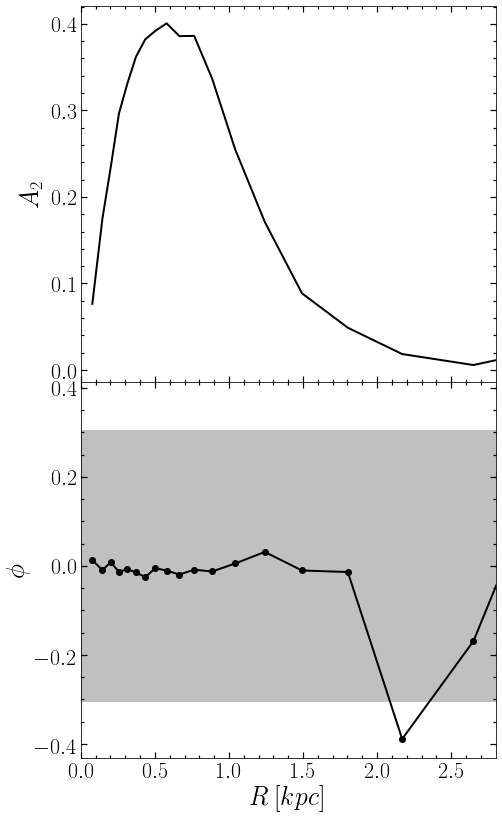

time= 12.168293087 lbar= 1.82069120769


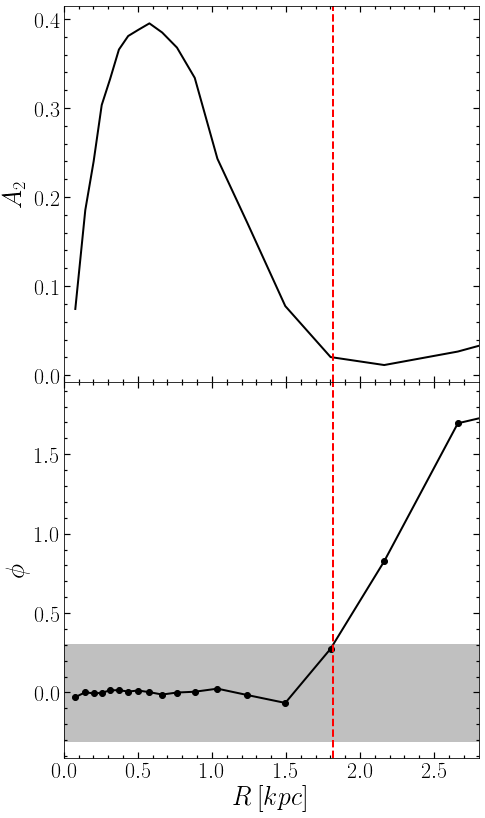

time= 12.1403448624 lbar= 1.64430735969


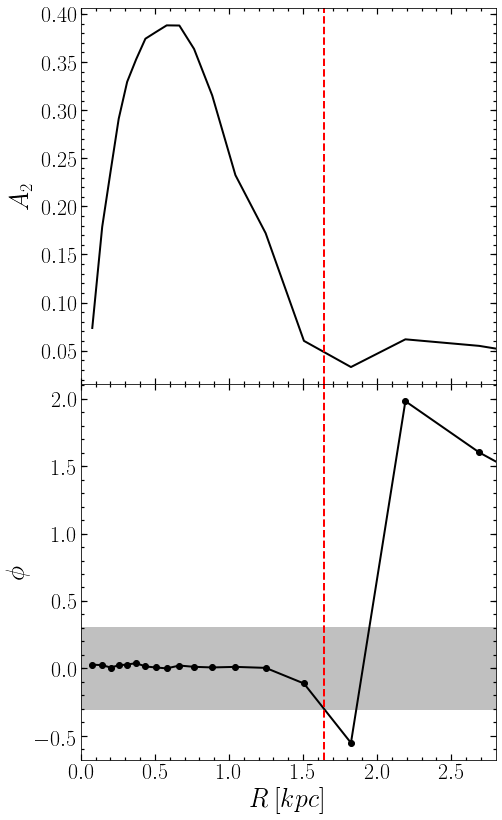

time= 12.1138393668 lbar= 1.90168386899


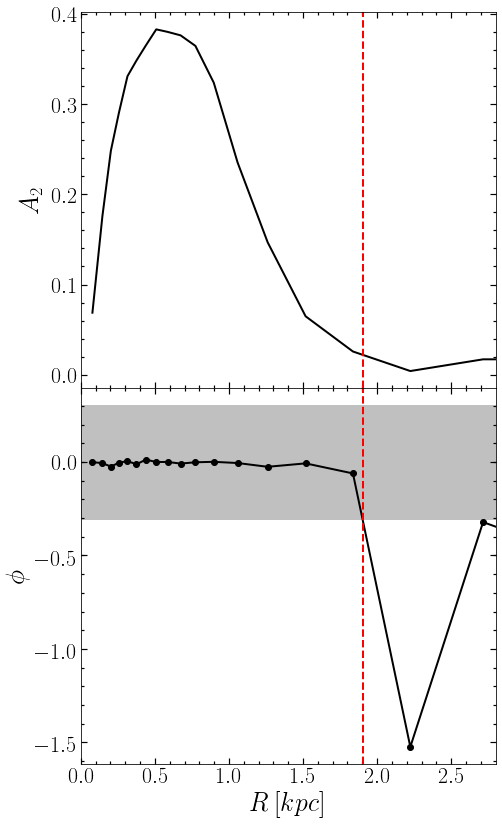

time= 12.0873064305 lbar= 1.60682854027


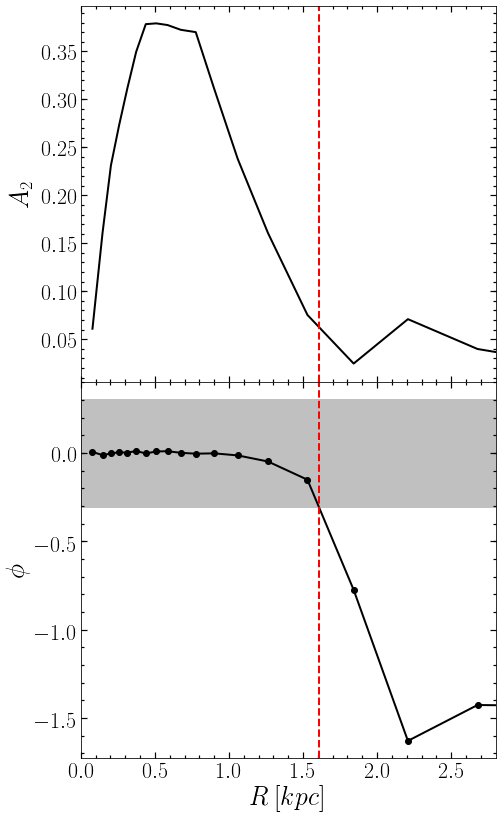

time= 12.0607460808 lbar= 1.32968904823


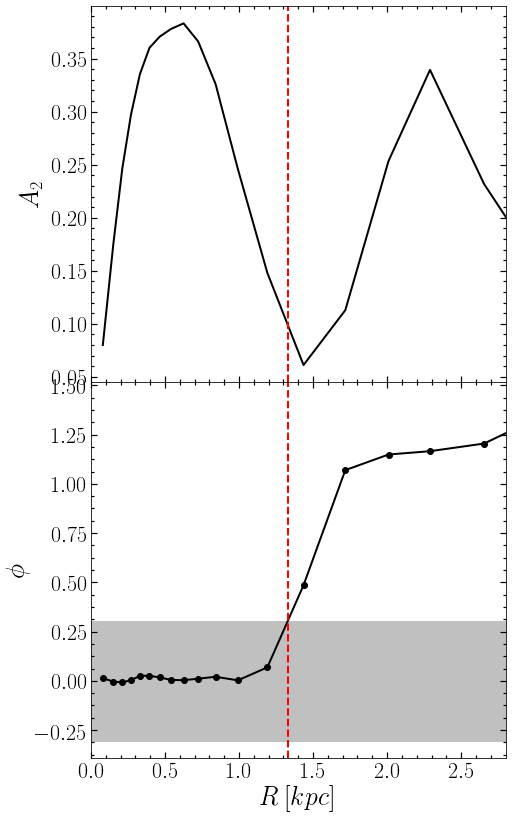

time= 12.0341583454 lbar= 1.87359072225


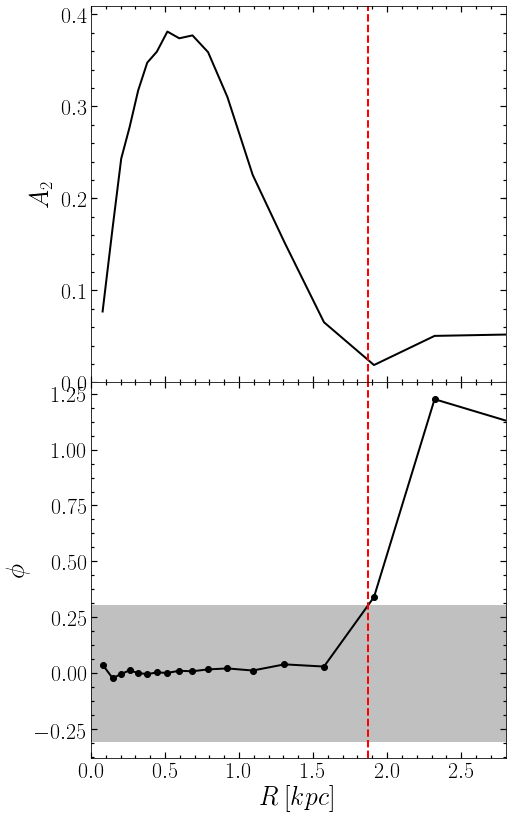

time= 12.0060638353 lbar= 1.87226002917


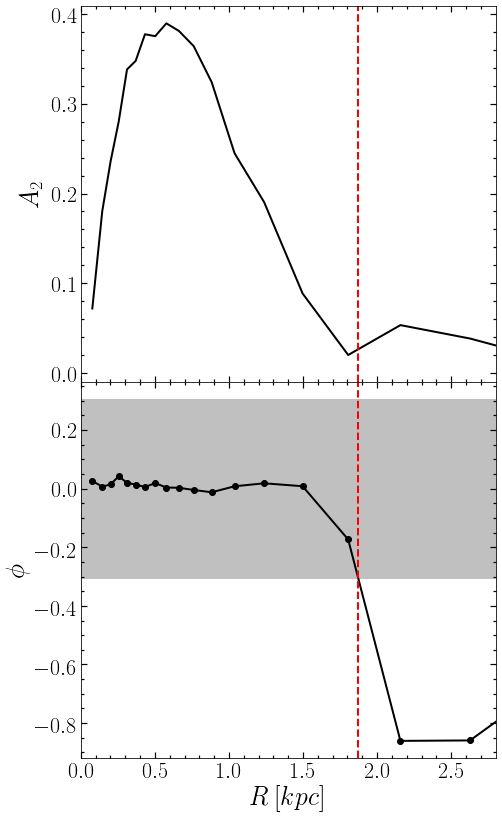

time= 11.9794198984 lbar= 2.1170319932


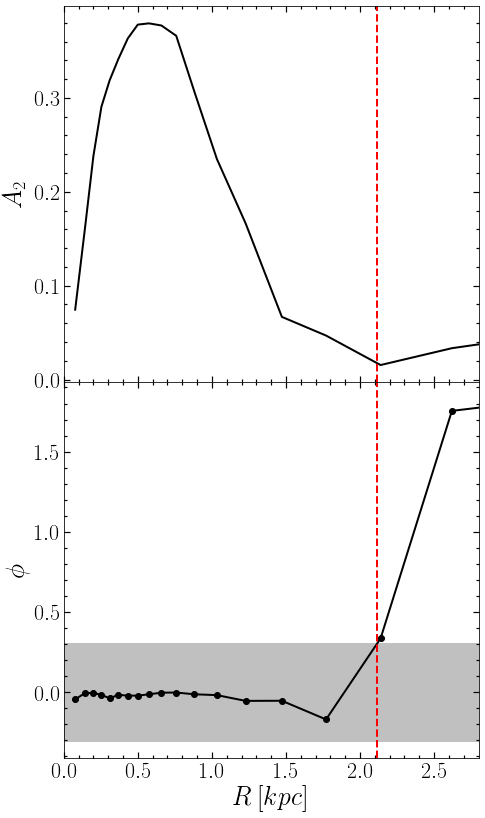

time= 11.9527486664 lbar= 1.73401204515


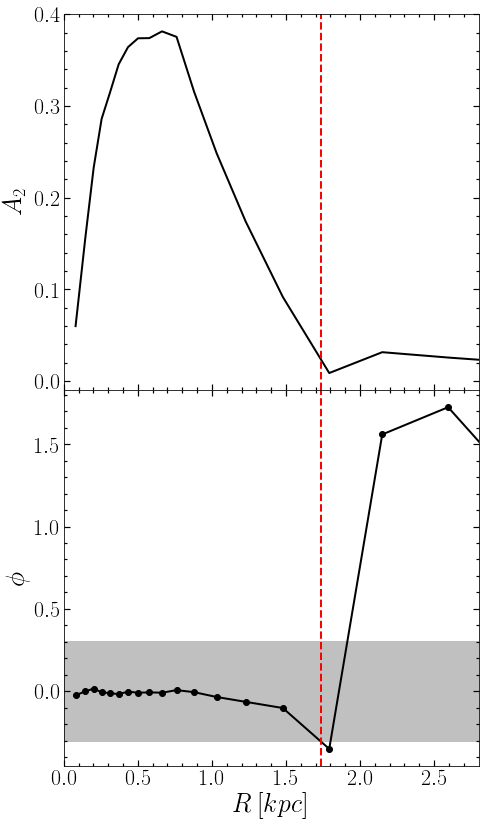

time= 11.927534135 lbar= 1.84005890743


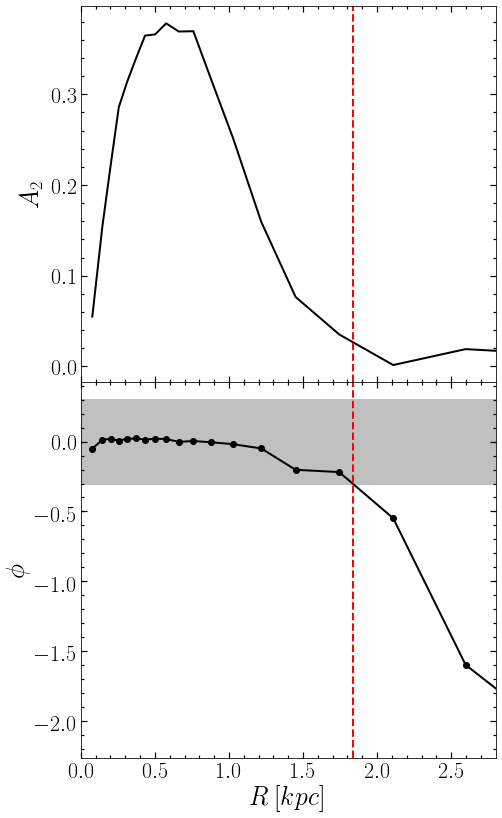

time= 11.9008099195 lbar= 1.51406421104


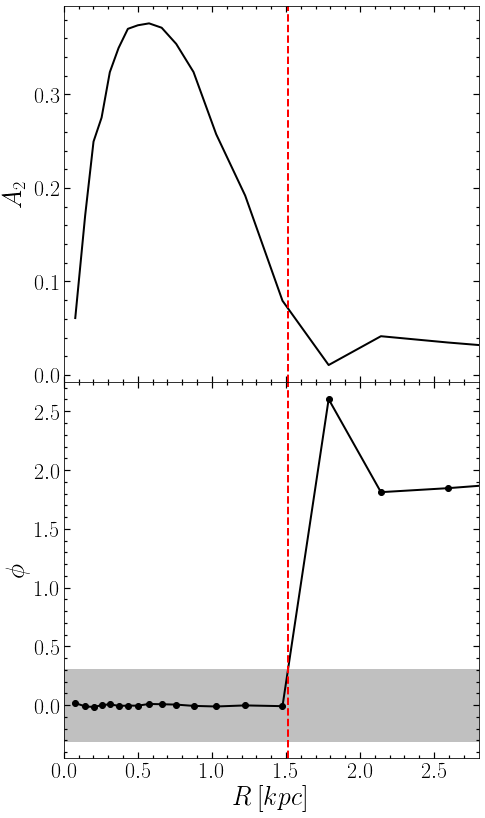

time= 11.8740585038 lbar= 1.82606143377


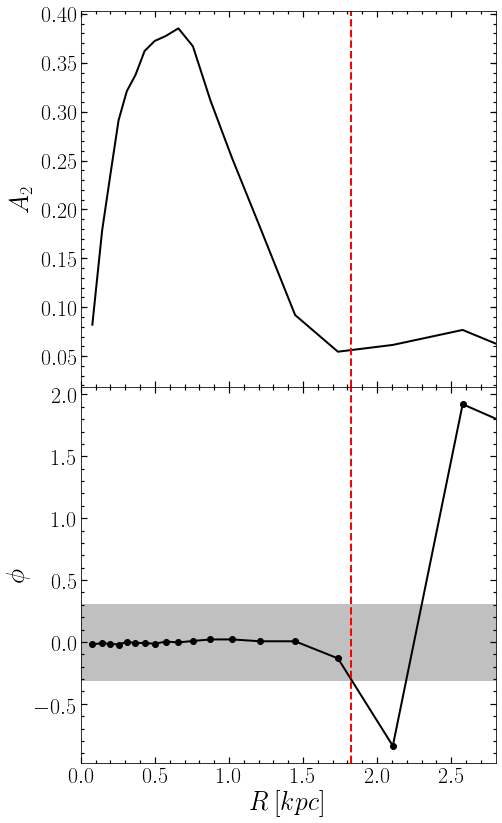

time= 11.8472799218 lbar= 1.94918722372


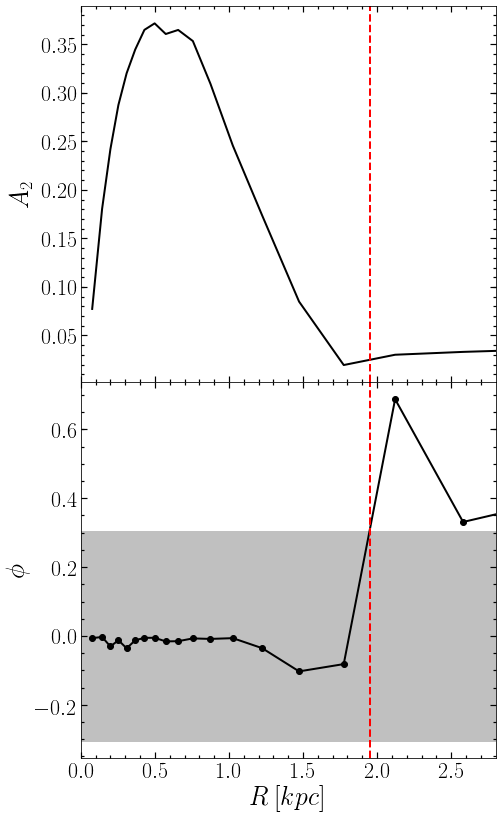

time= 11.8204742083 lbar= 1.70129241367


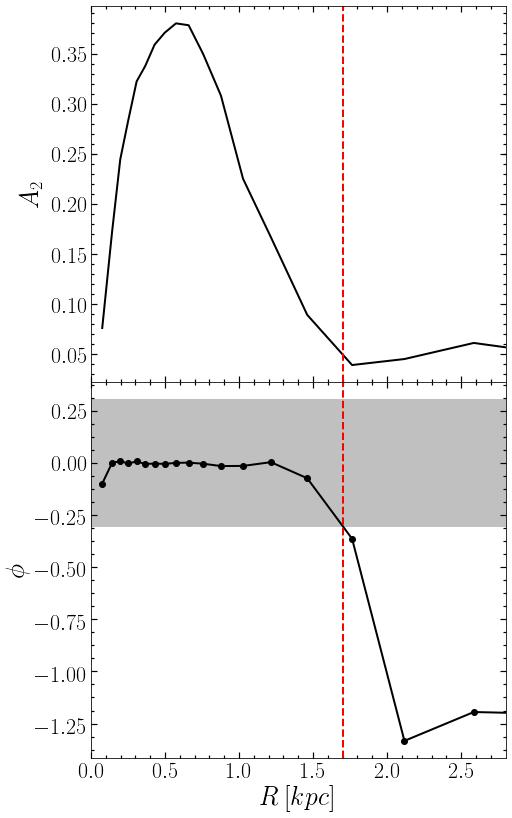

time= 11.7936413991 lbar= 1.59353095019


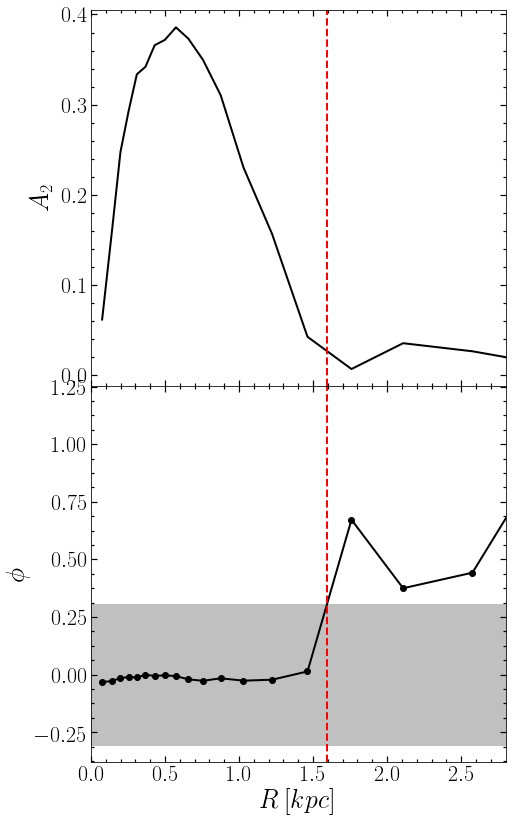

time= 11.766781531 lbar= 1.53151254769


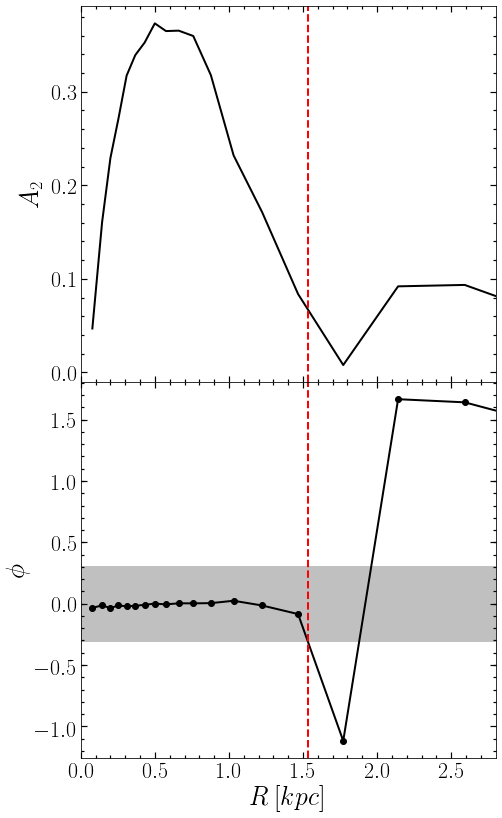

time= 11.7398946416 lbar= 1.74981116609


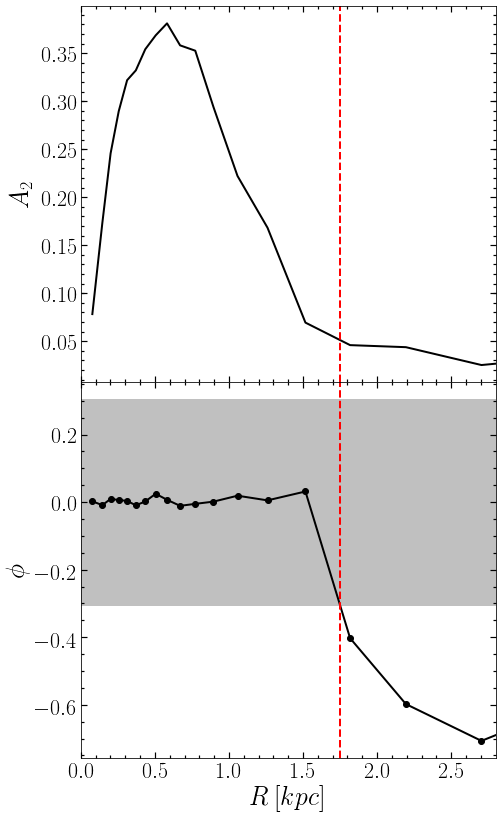

time= 11.7129807693 lbar= 1.54430518339


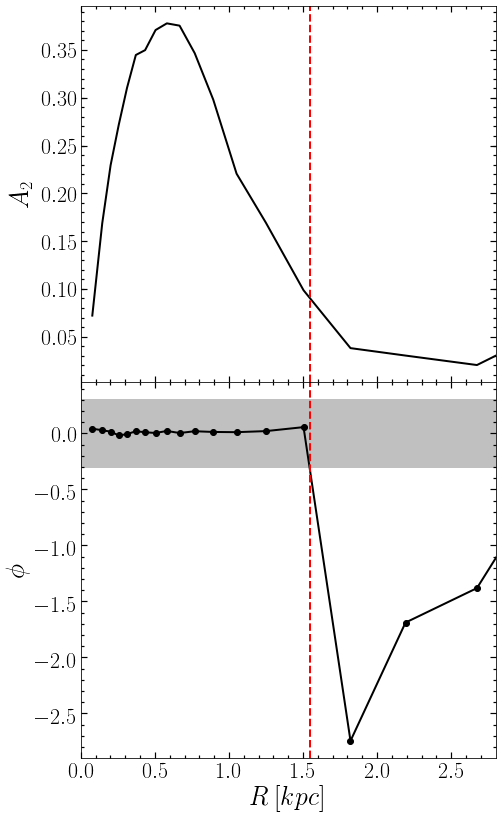

time= 11.6860399539 lbar= 1.61420474925


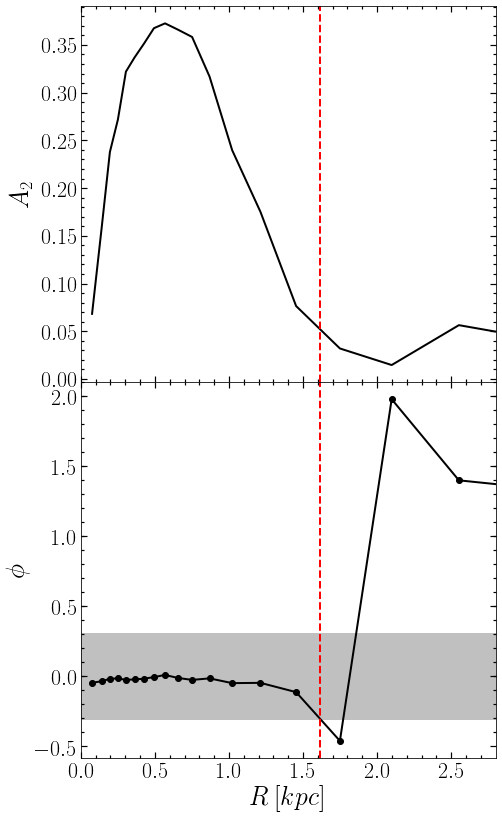

time= 11.6590722357 lbar= 1.81290602061


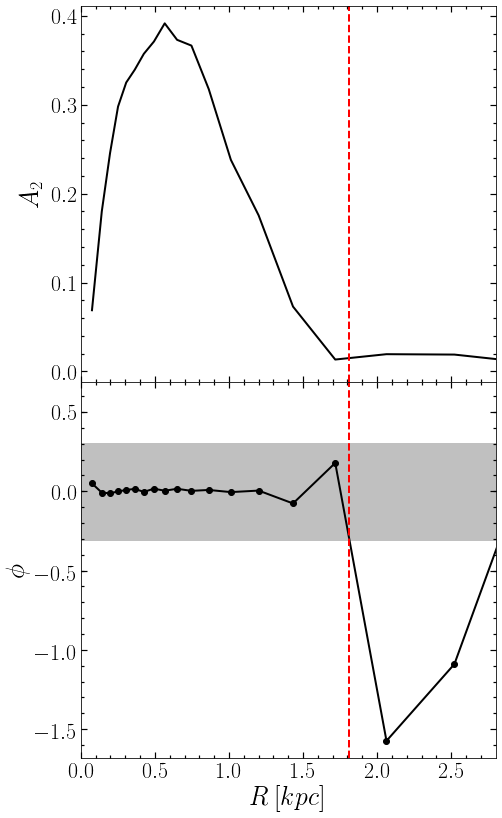

time= 11.6320776561 lbar= 1.58091625275


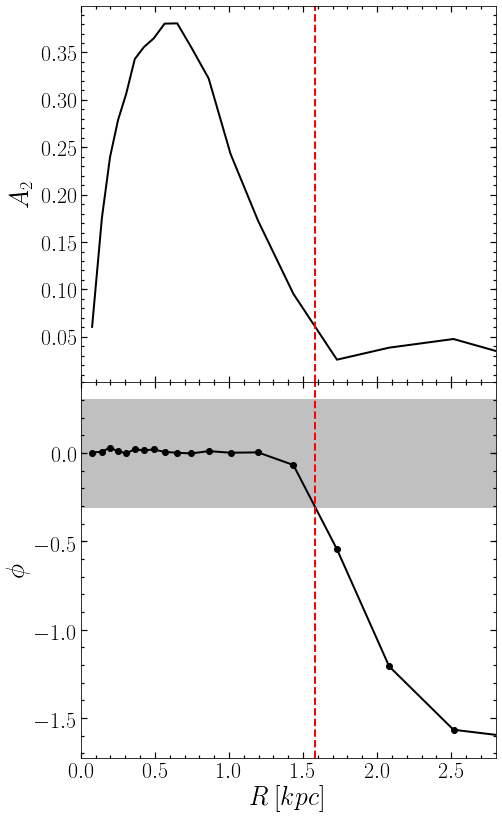

time= 11.6050562576 lbar= 1.76196582096


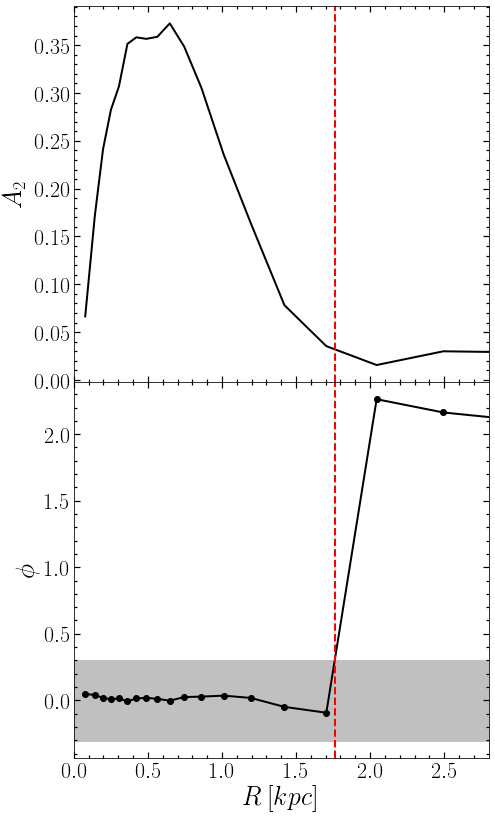

time= 11.5780080835 lbar= 1.64684233942


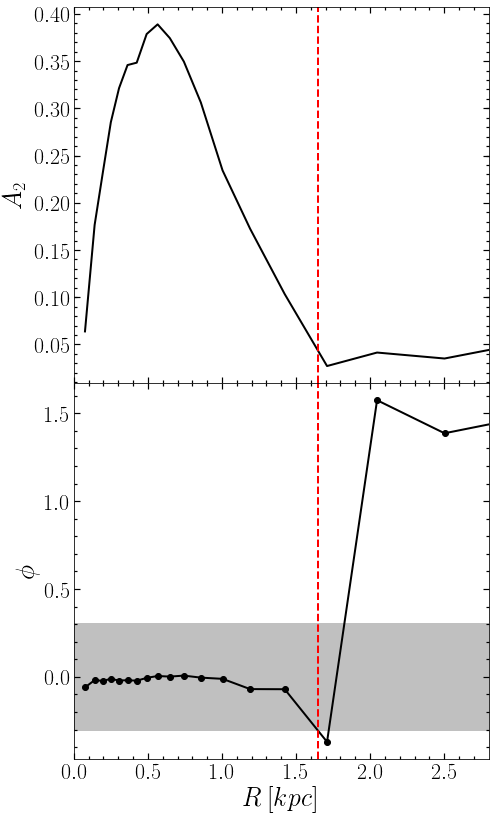

time= 11.5524380402 lbar= 1.91596370038


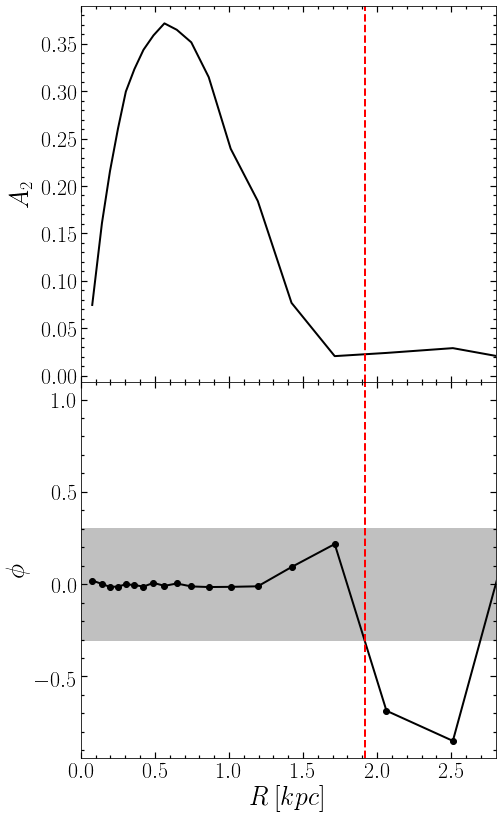

time= 11.5253379304 lbar= 1.75729587392


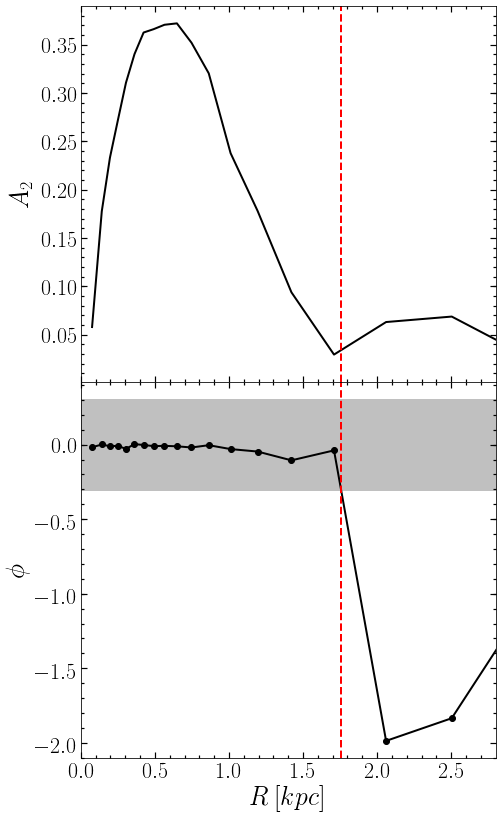

time= 11.4982111787 lbar= 1.48938138812


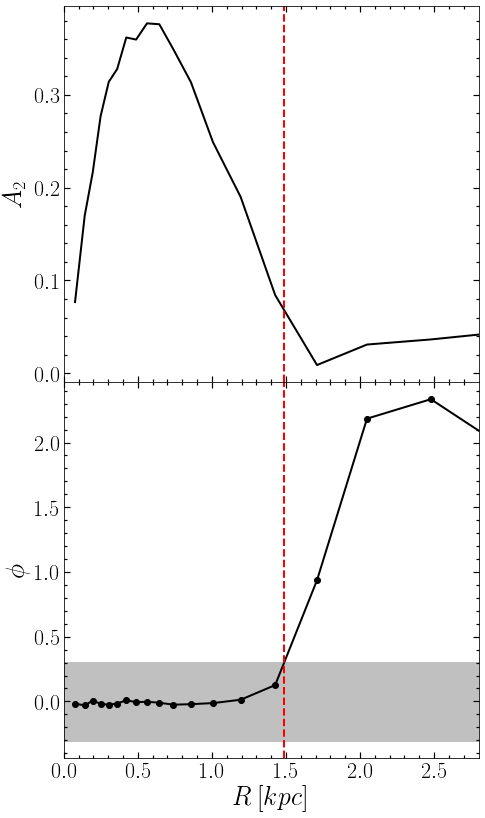

time= 11.4710578322 lbar= 1.7602060722


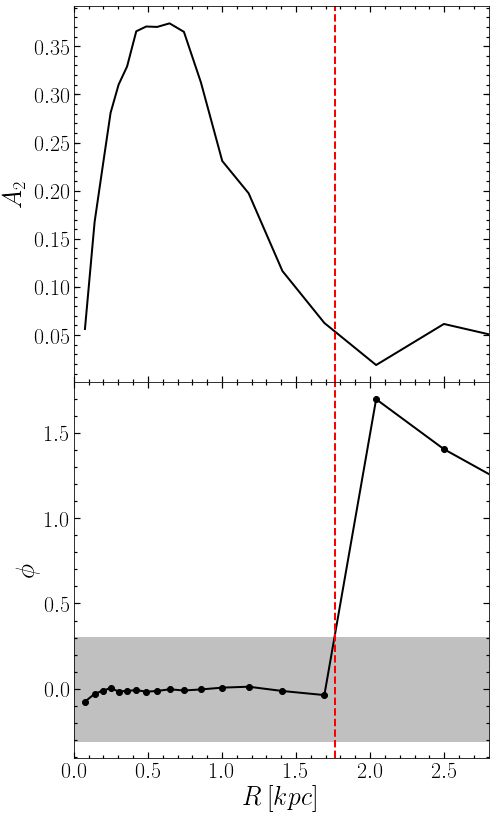

time= 11.4438779394 lbar= 1.64001426377


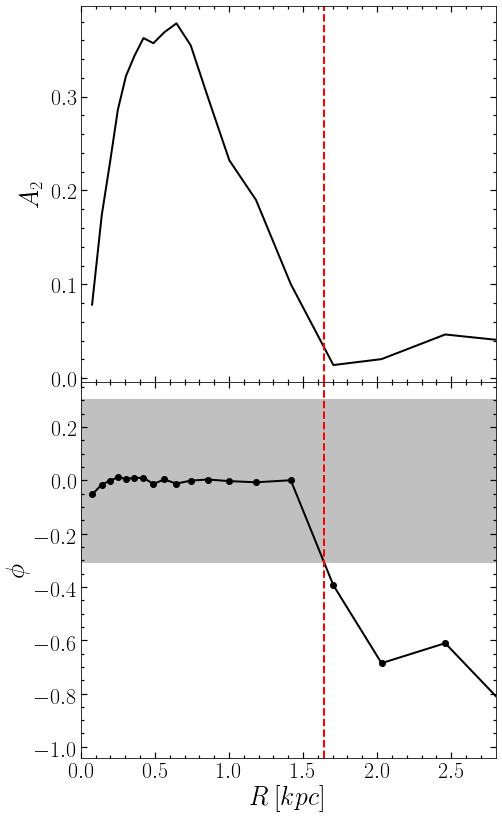

time= 11.41818371 lbar= 1.5312310429


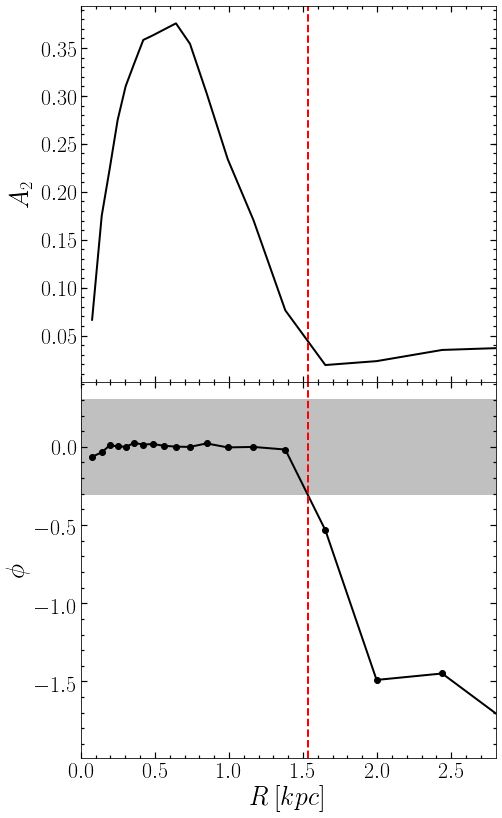

time= 11.3909523417 lbar= 1.43878305558


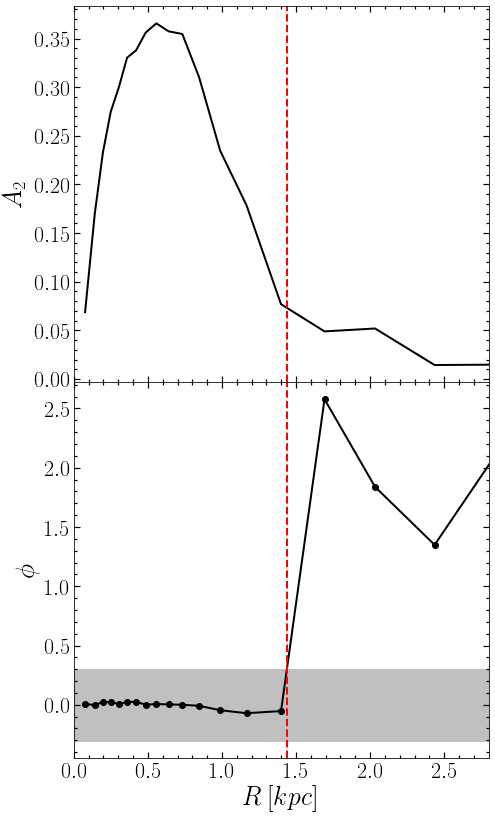

time= 11.3636945754 lbar= 1.81882527375


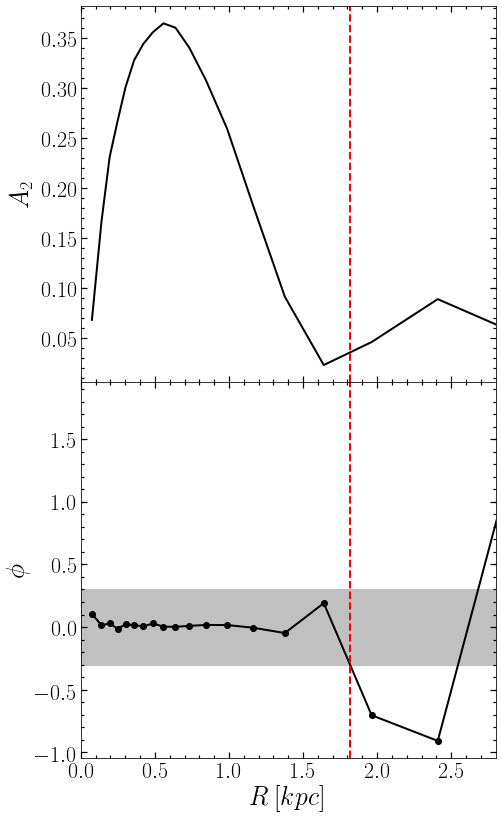

time= 11.337926938 lbar= 1.49921239167


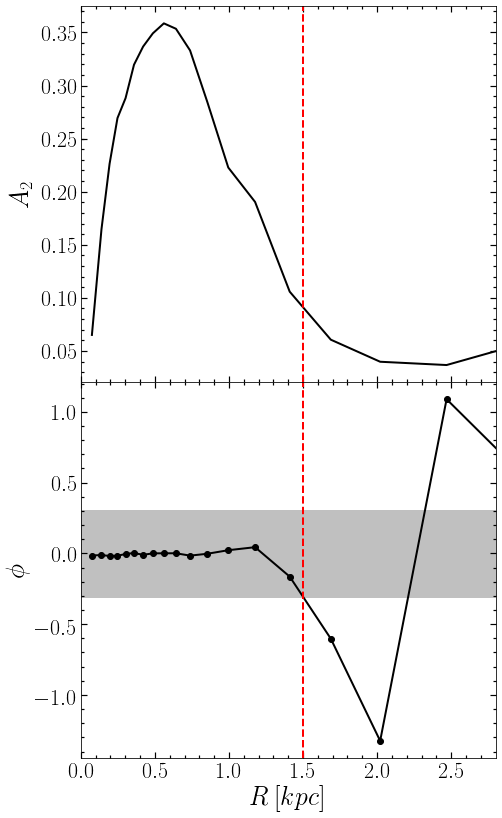

time= 11.3106179937 lbar= 2.01184438065


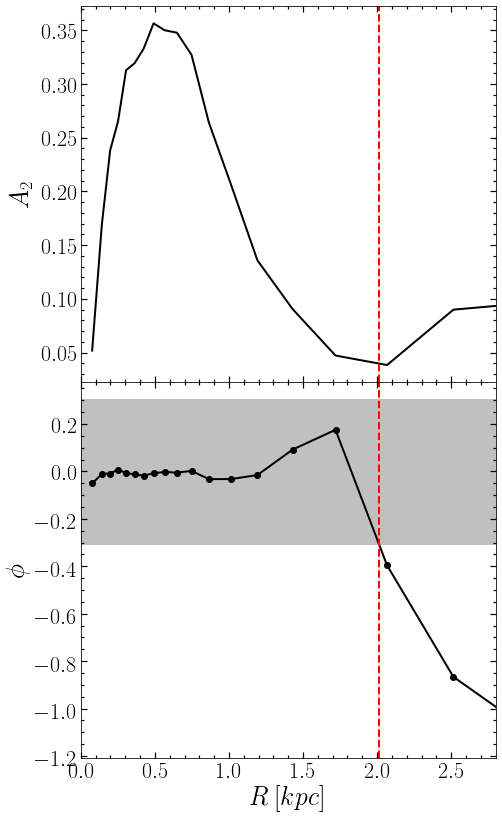

time= 11.2832828092 lbar= 0.884481622914


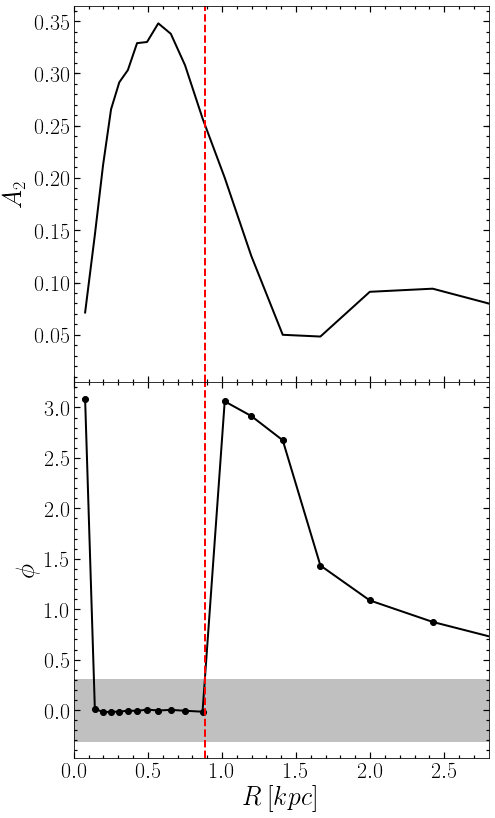

time= 11.2574422021 lbar= 1.22597411425


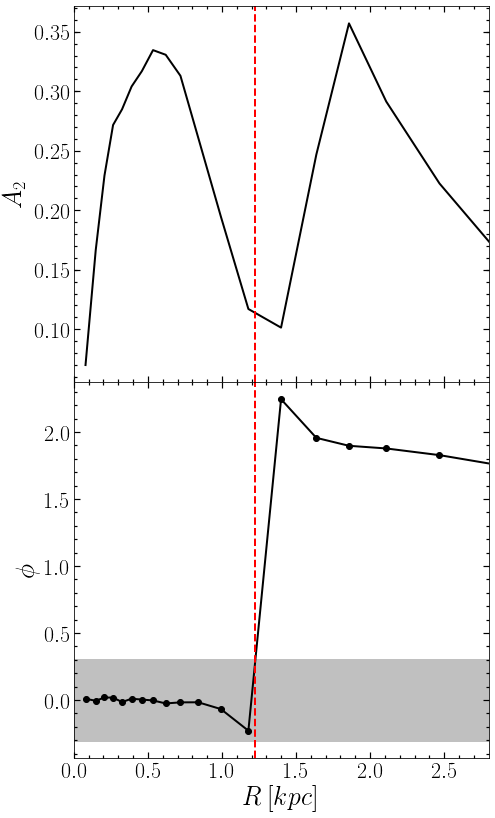

time= 11.2300561551 lbar= 1.83322365829


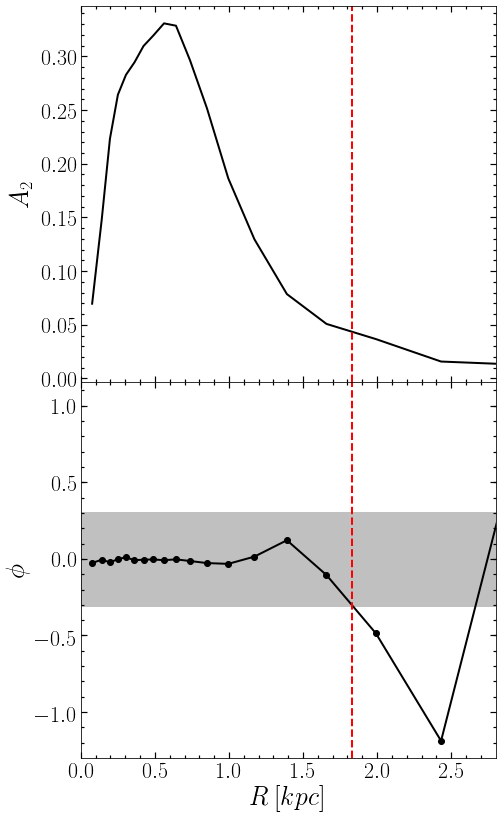

time= 11.202644035 lbar= 1.55175256756


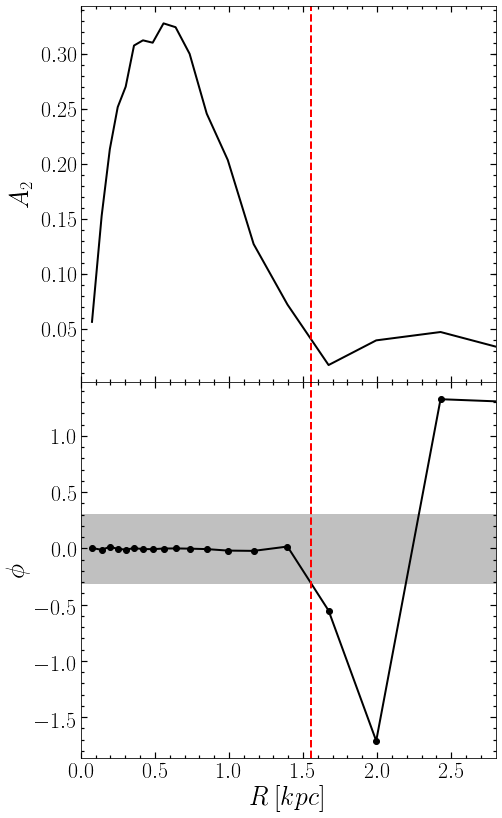

time= 11.1767309228 lbar= 1.71699035601


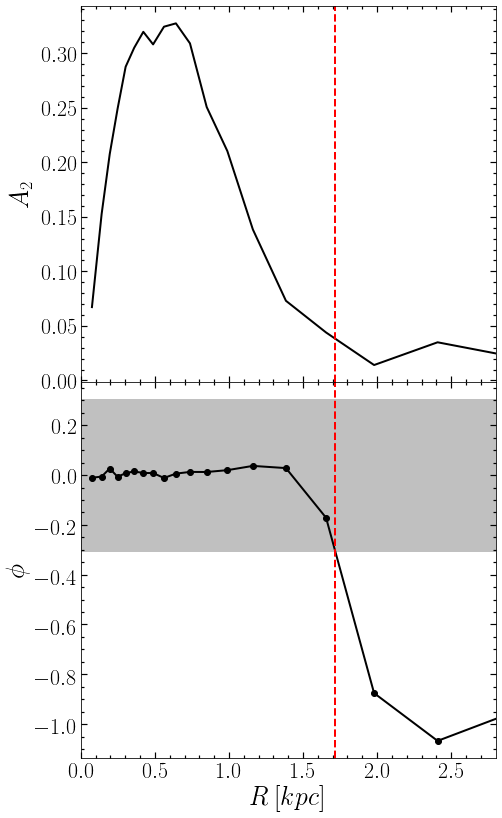

time= 11.1492682745 lbar= 1.67461468296


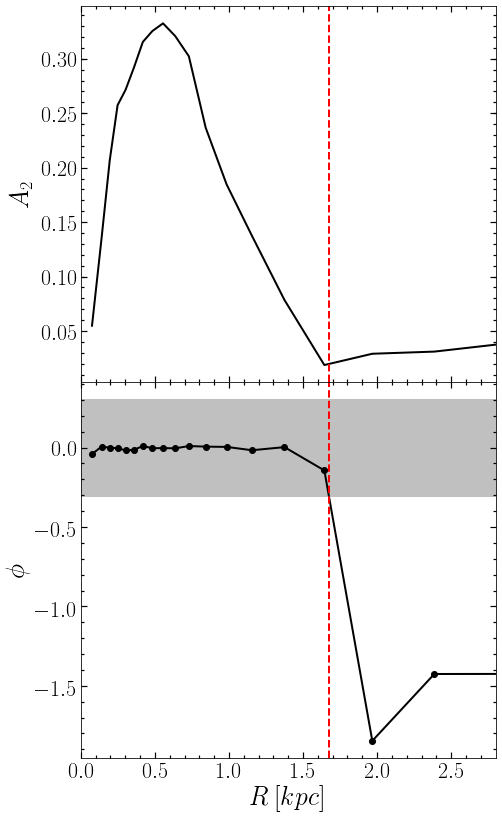

time= 11.1217797296 lbar= 1.71067896845


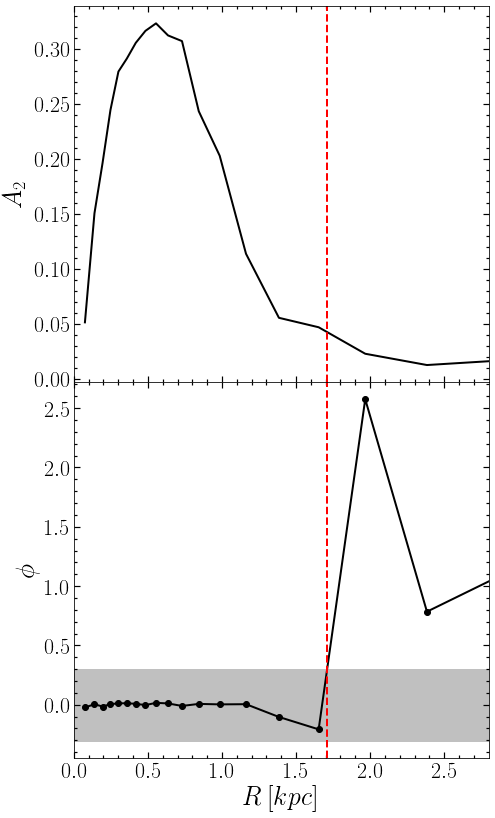

time= 11.0957946039 lbar= 1.65667046275


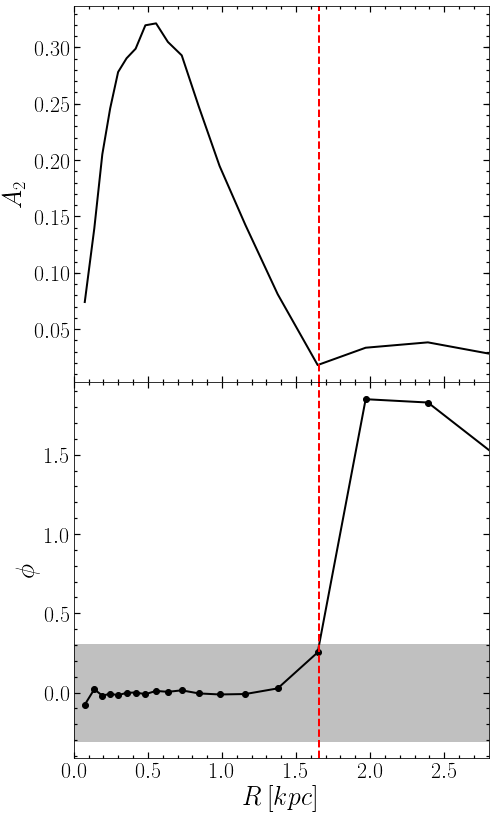

time= 11.068255884 lbar= 1.6927233835


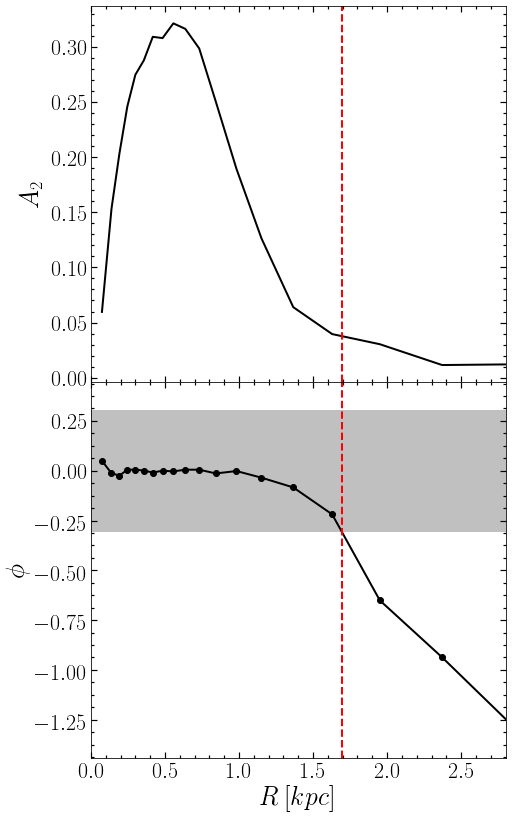

time= 11.0406914544 lbar= 1.60043491394


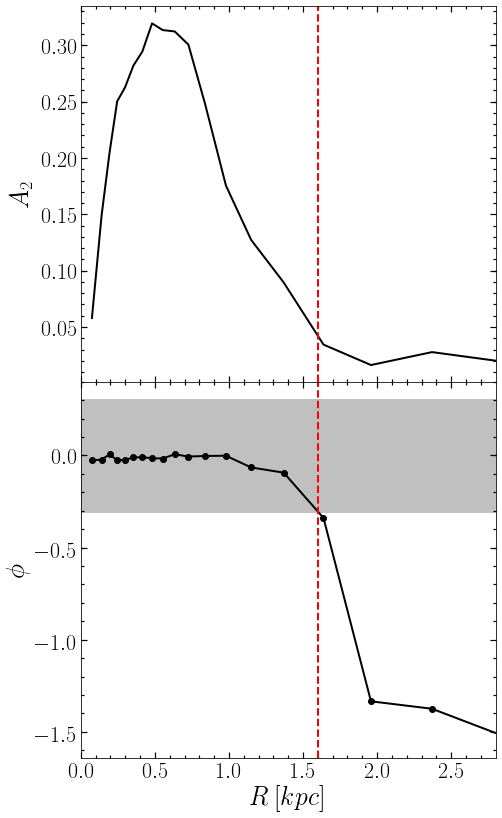

time= 11.0146348341 lbar= 1.66039533203


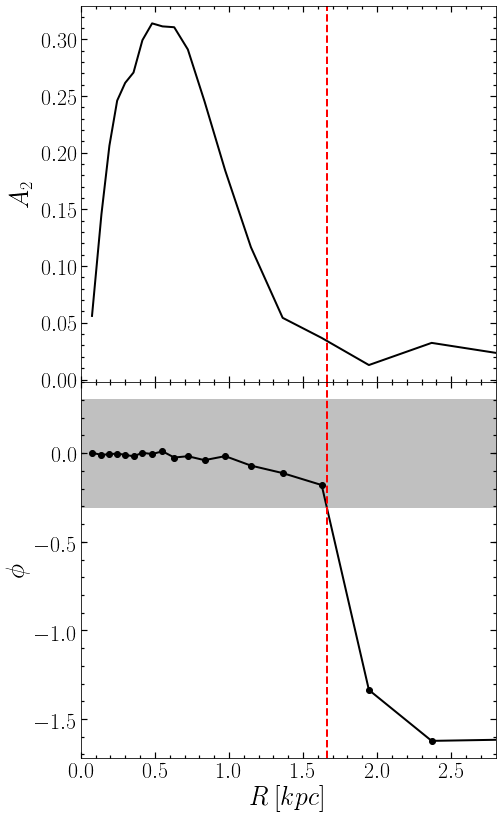

time= 10.9870206022 lbar= 1.63984649177


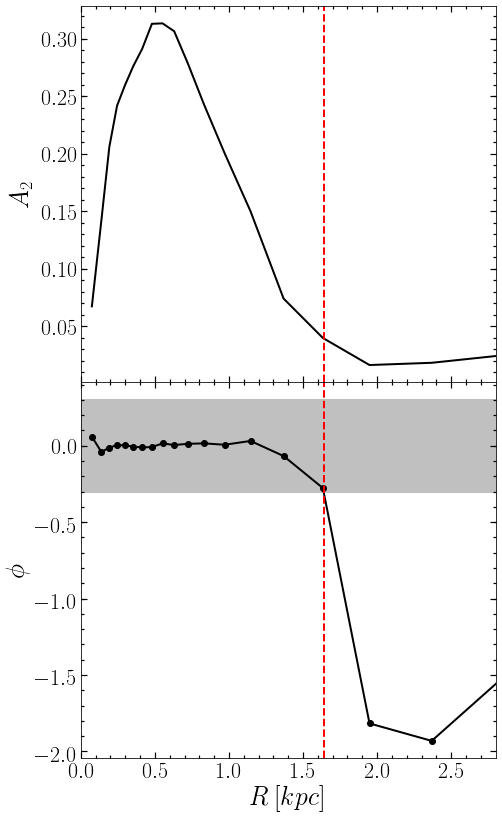

time= 10.9609170667 lbar= 1.65878510593


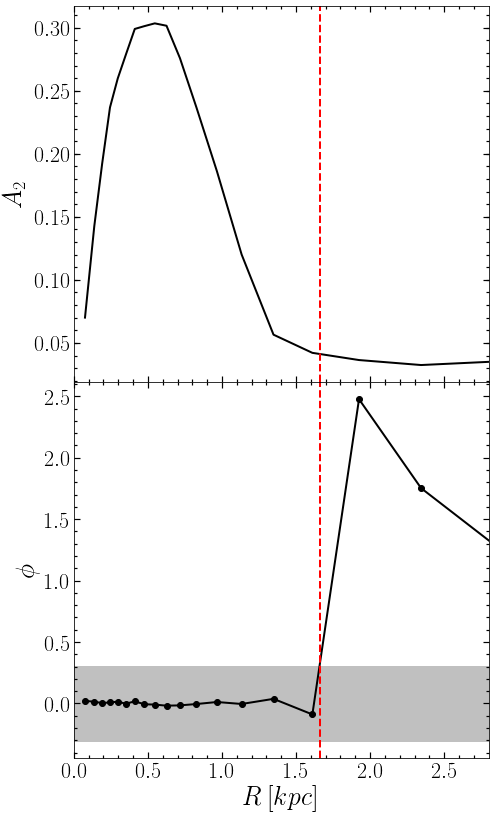

time= 10.9347908325 lbar= 1.68252598554


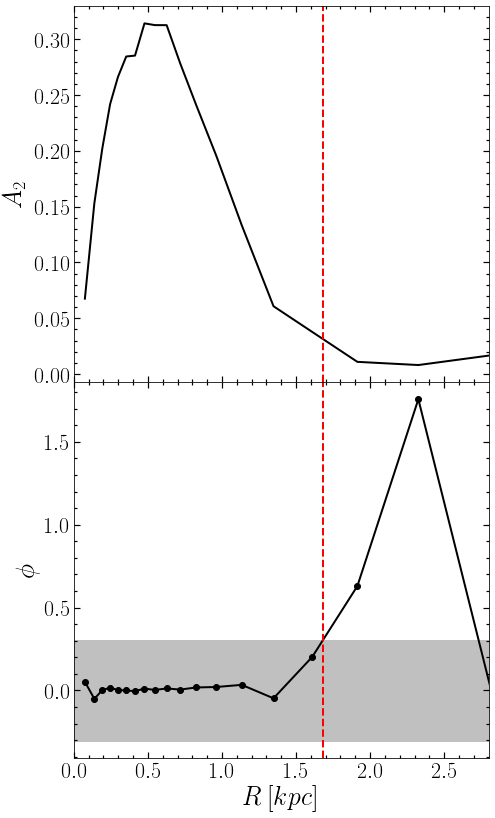

time= 10.907103086 lbar= 1.79096684692


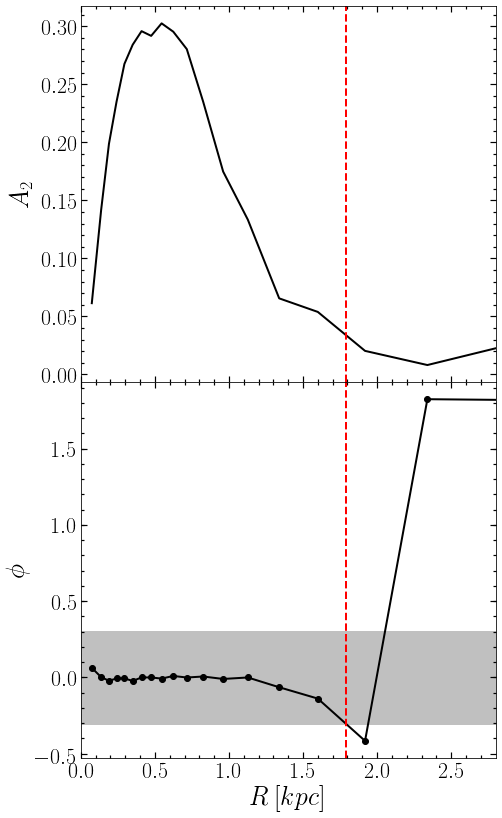

time= 10.8809303066 lbar= 1.680550702


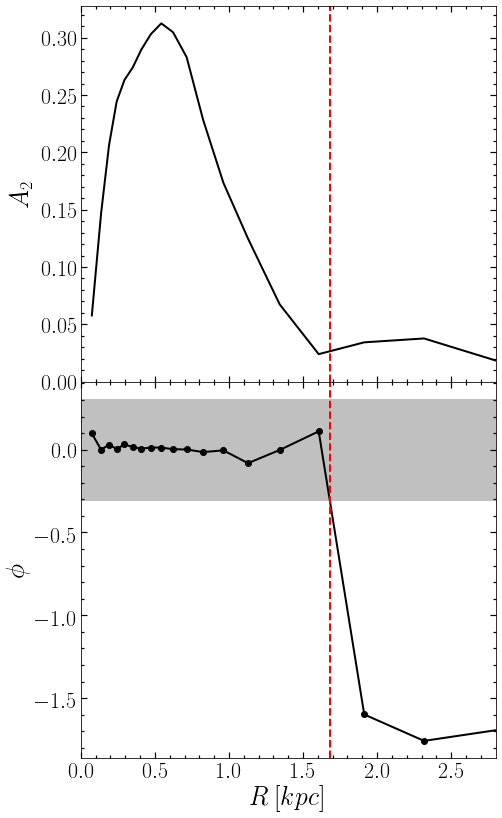

time= 10.8531934132 lbar= 1.6112434804


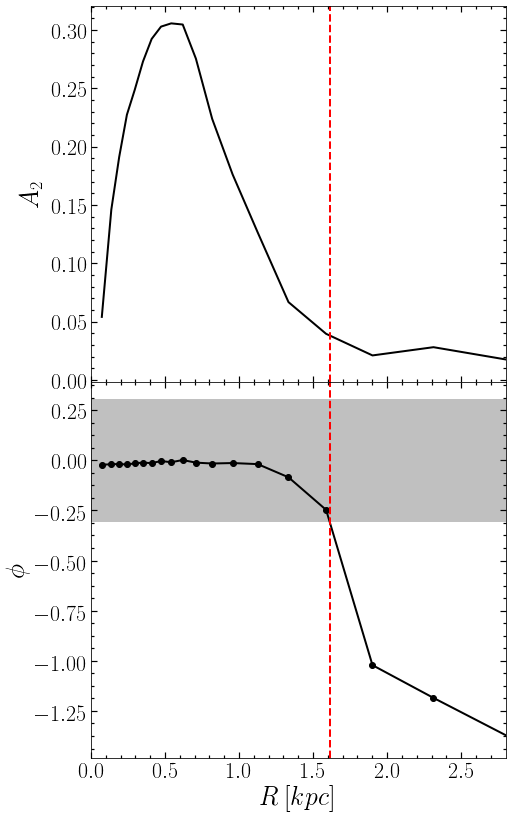

time= 10.8269743482 lbar= 1.65867322279


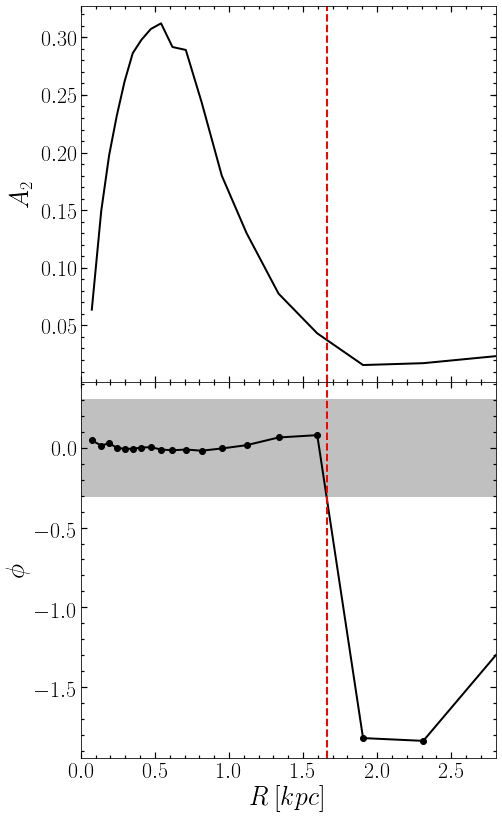

time= 10.7991885872 lbar= 1.61621320021


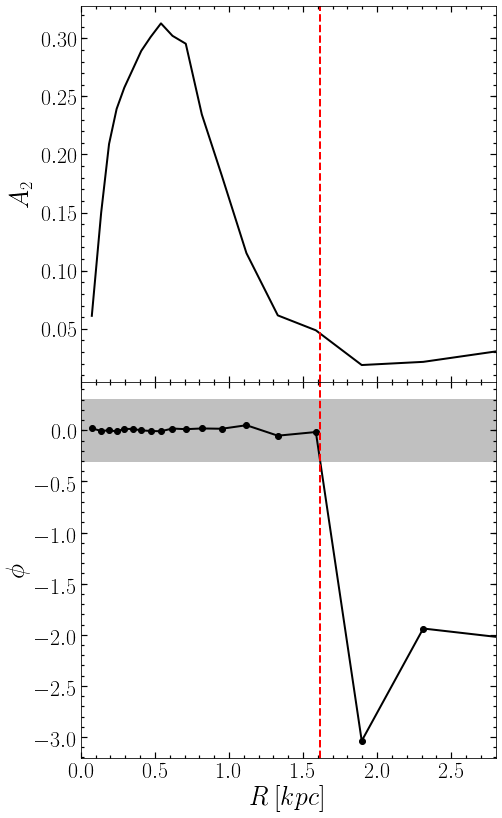

time= 10.7729235046 lbar= 1.68285742146


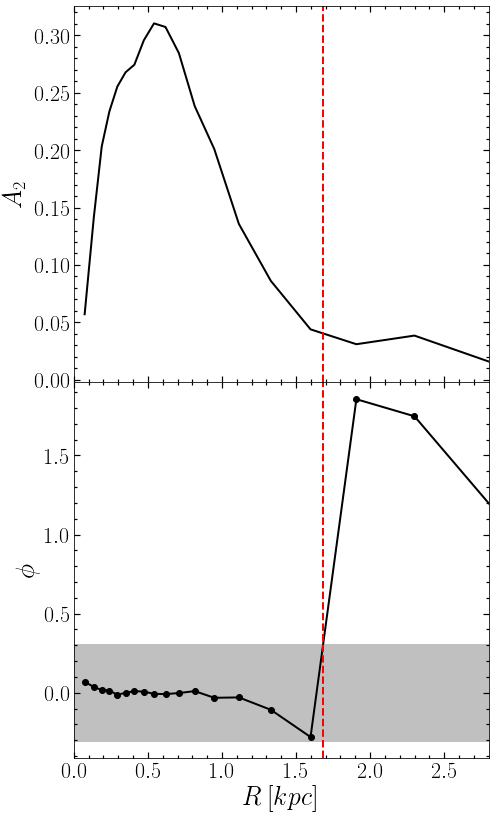

time= 10.7450891646 lbar= 1.92725980049


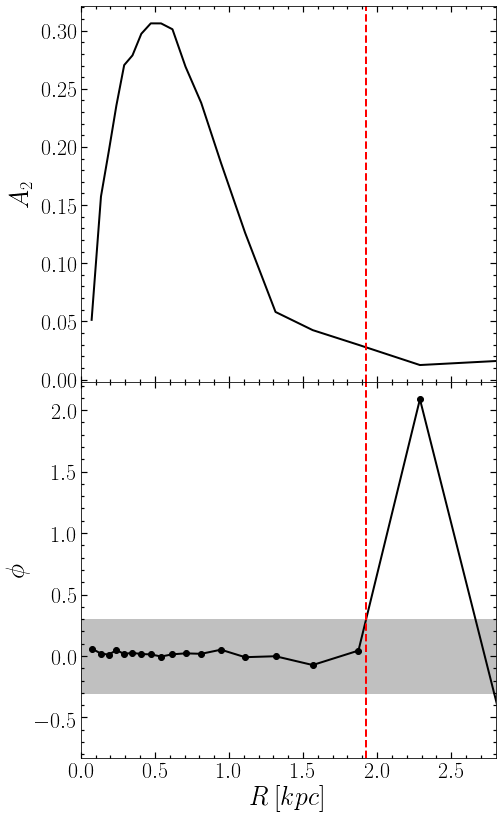

time= 10.7187783413 lbar= 1.43990153614


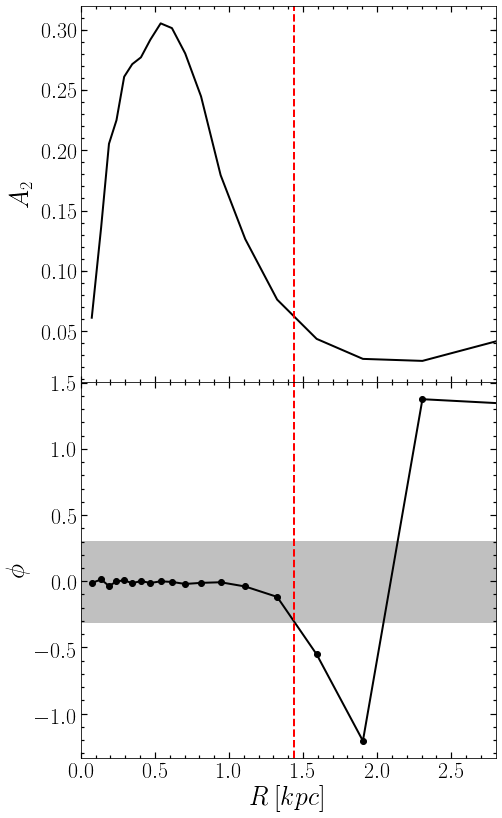

time= 10.69089572 lbar= 1.76337642297


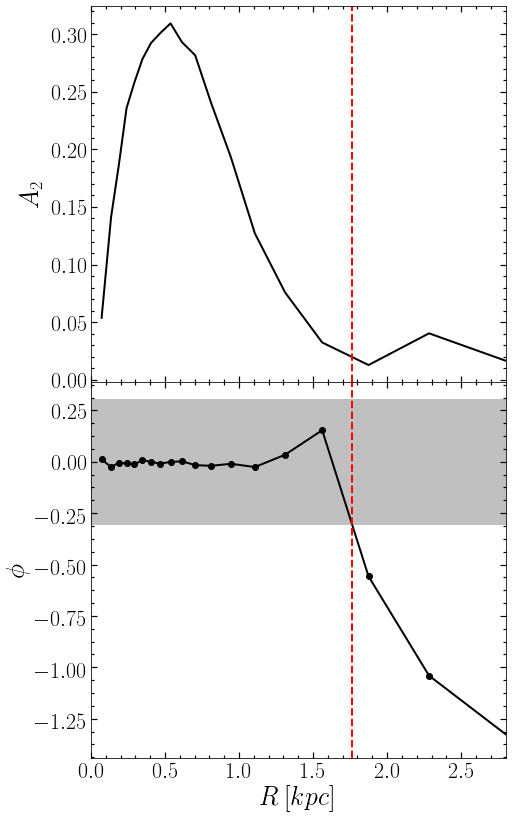

time= 10.6645394418 lbar= 1.6138976991


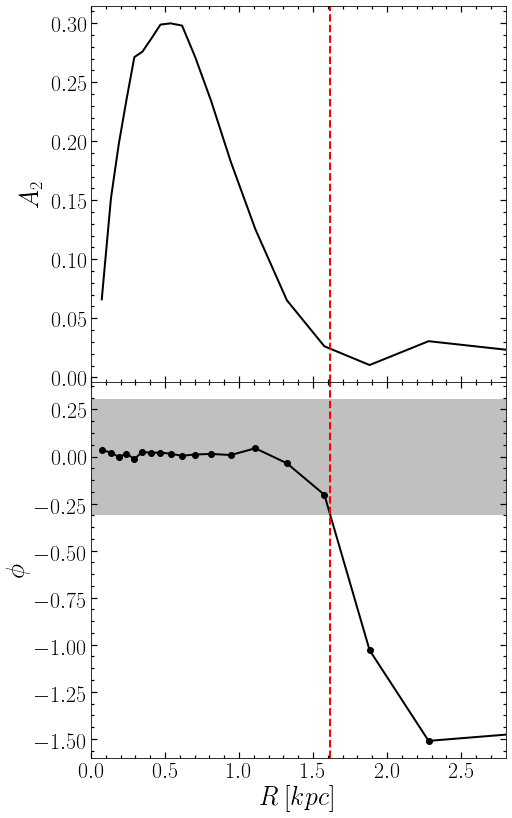

time= 10.6381611913 lbar= 1.94280461866


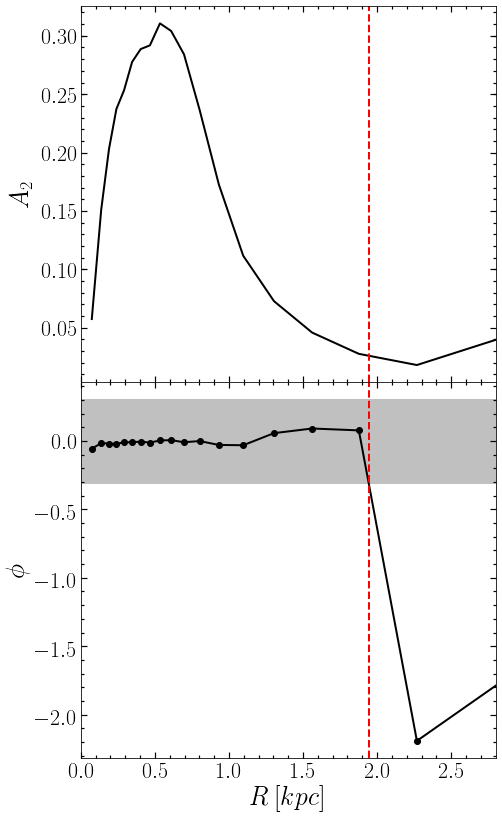

time= 10.6102074084 lbar= 1.50366965477


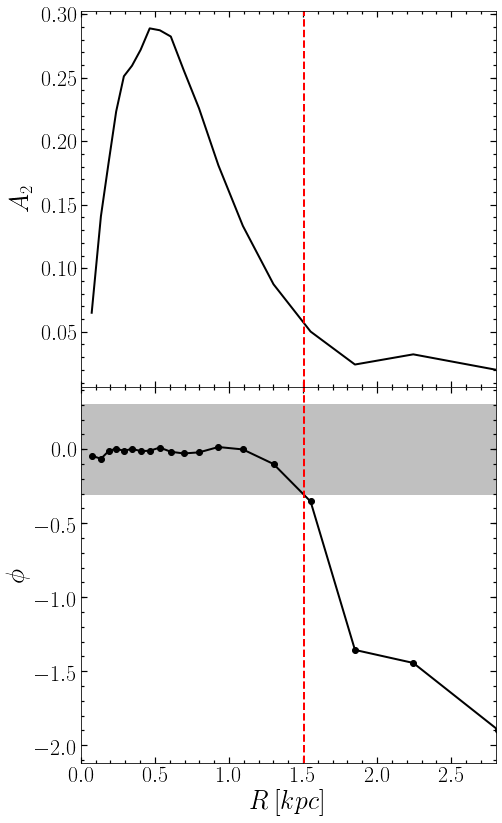

time= 10.5837841442 lbar= 1.91145775667


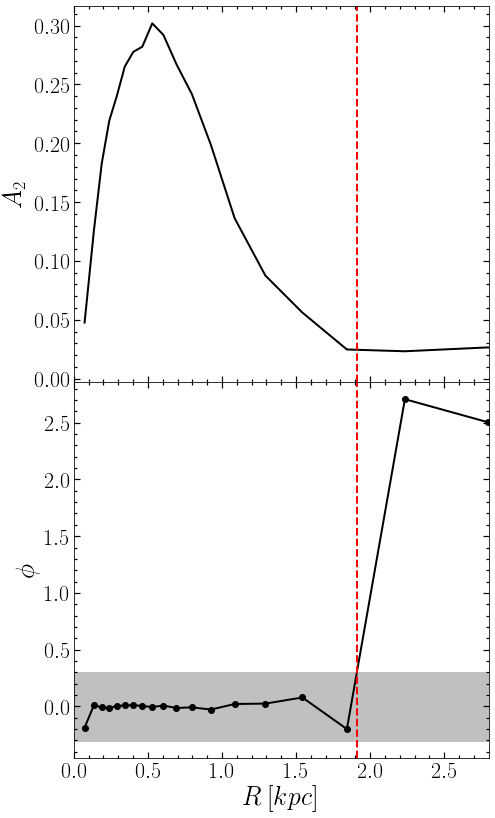

time= 10.5573391269 lbar= 1.6071420008


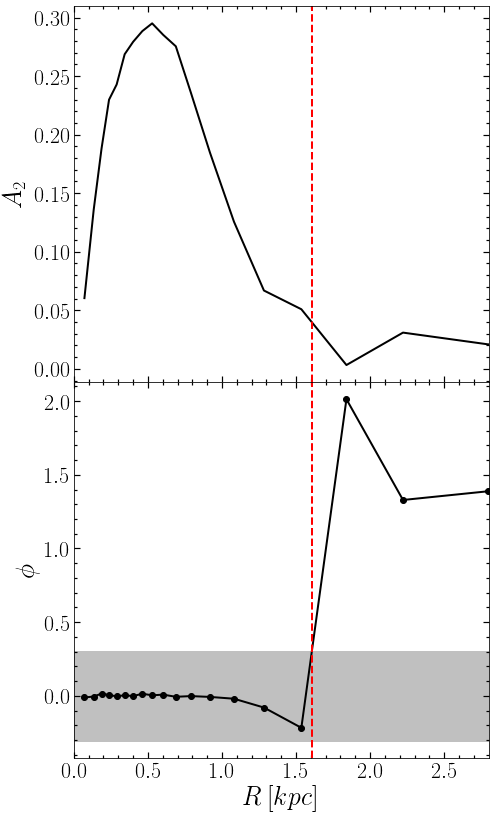

time= 10.5293148924 lbar= 1.54533619976


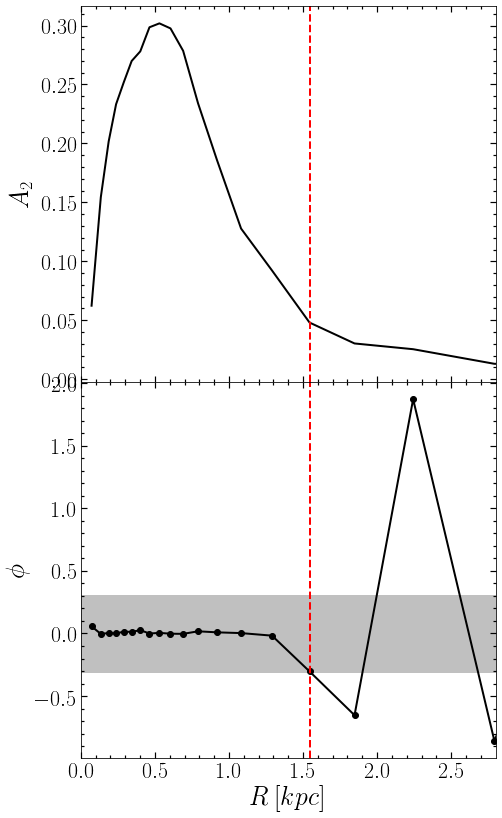

time= 10.5028253231 lbar= 1.55945555819


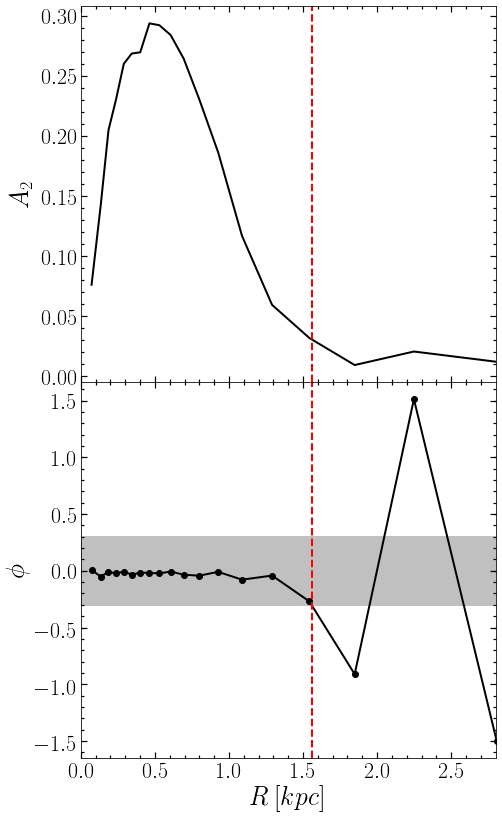

time= 10.4763142299 lbar= 1.62057936807


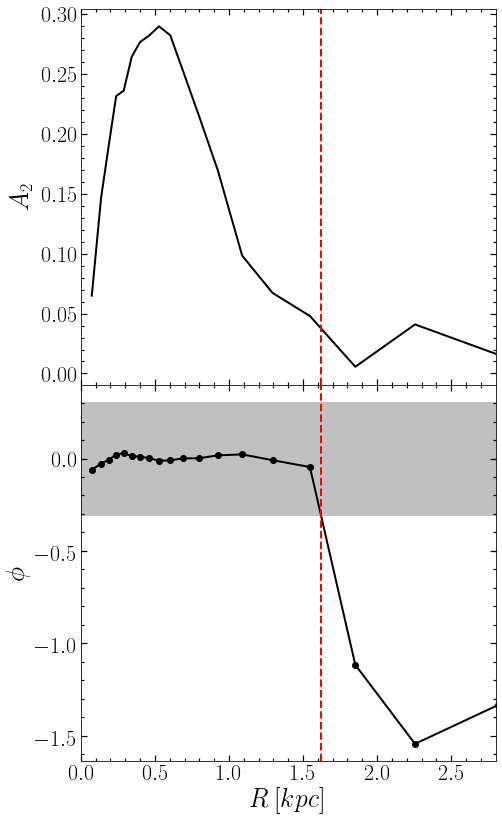

time= 10.4482202861 lbar= 1.59183632337


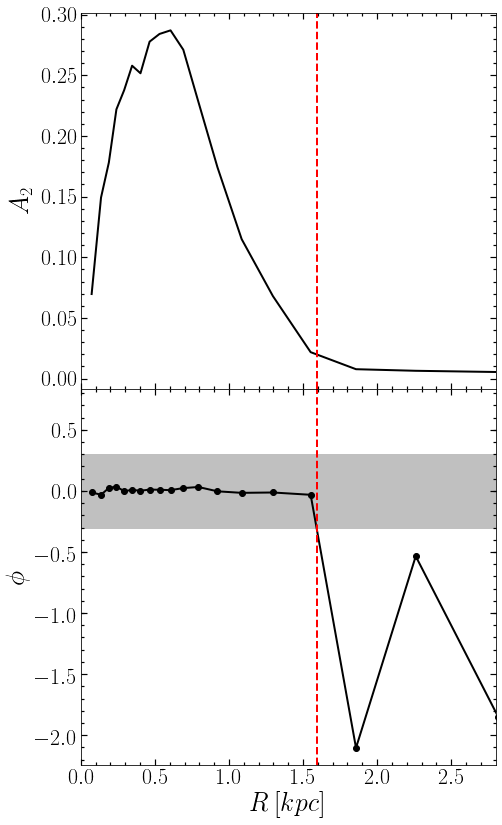

time= 10.4216651232 lbar= 1.61342874272


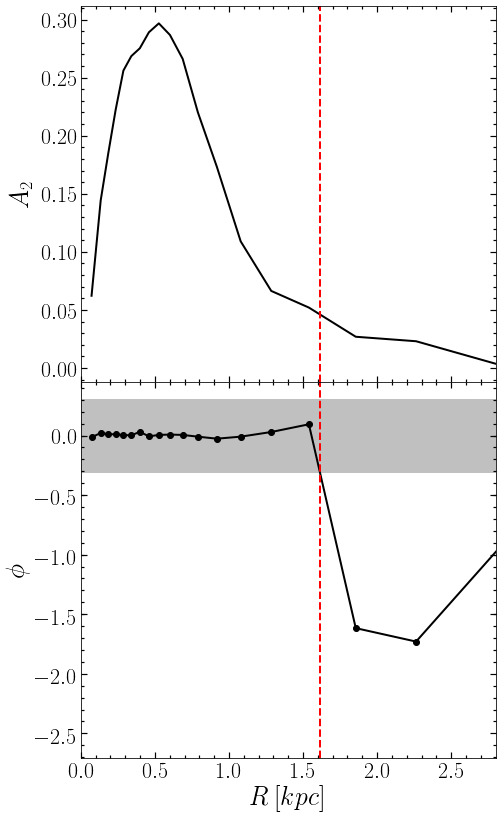

time= 10.3935246943 lbar= 1.56412278093


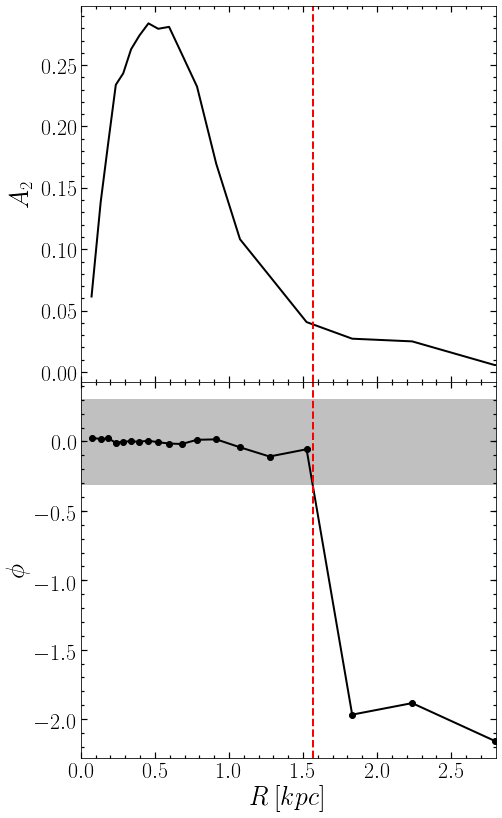

time= 10.3669257983 lbar= 1.57526609381


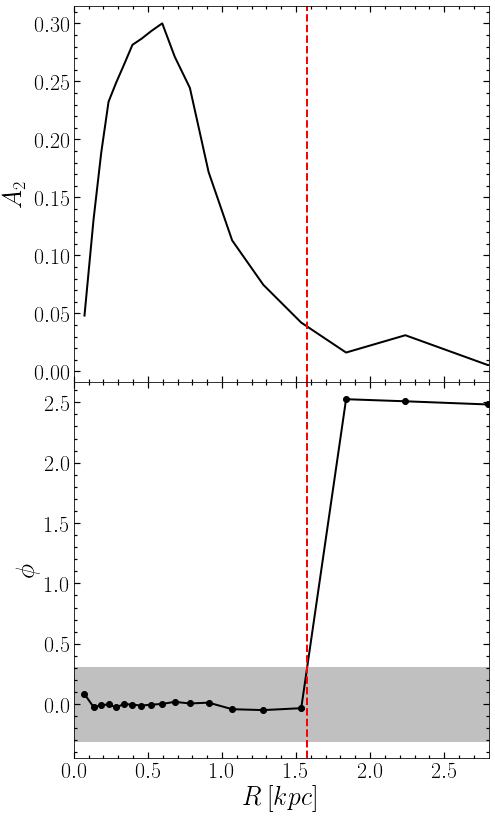

time= 10.3403057849 lbar= 1.53674754915


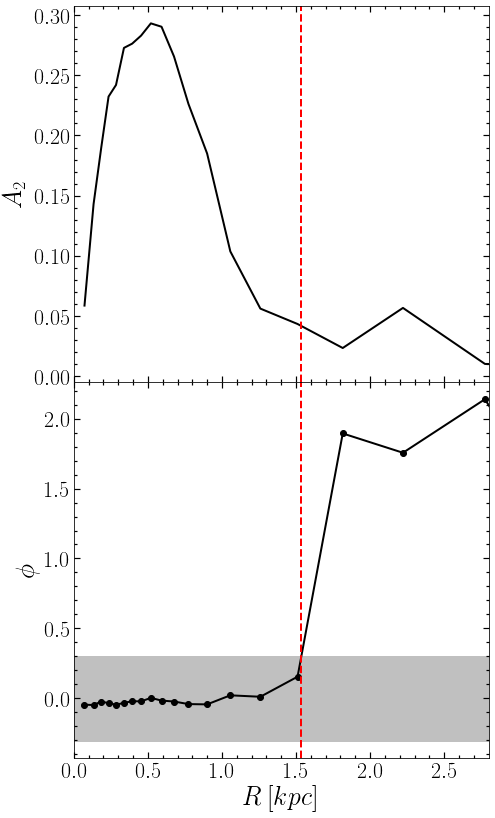

time= 10.3120969631 lbar= 1.43191691964


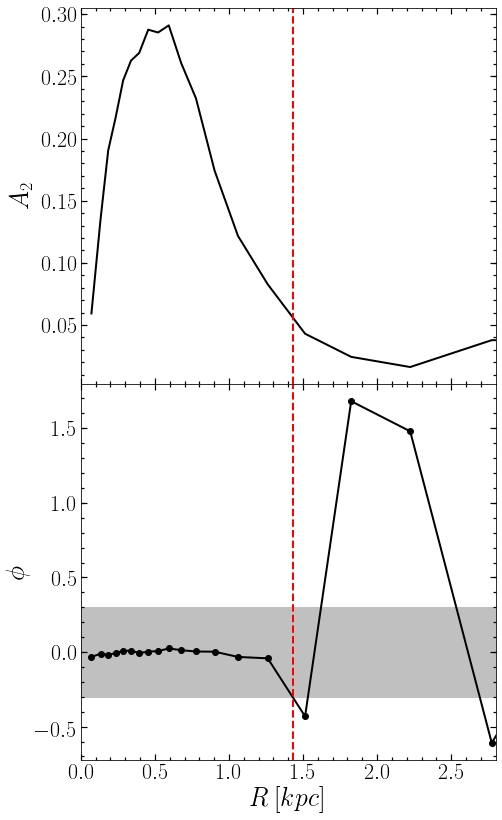

time= 10.2854337347 lbar= 1.48788500409


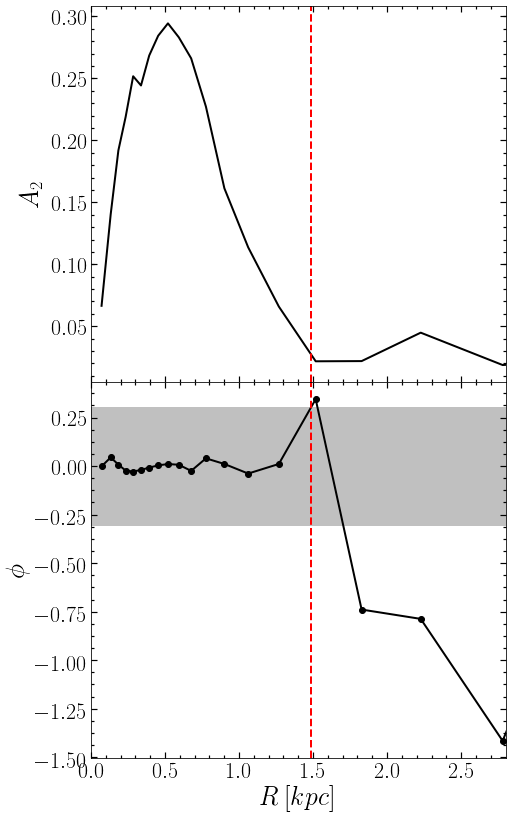

time= 10.2587496458 lbar= 1.55034989825


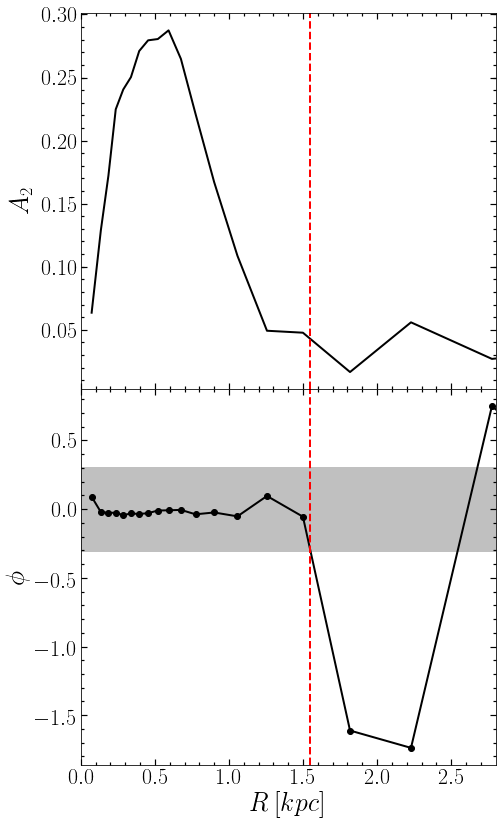

time= 10.2320447827 lbar= 1.59304560975


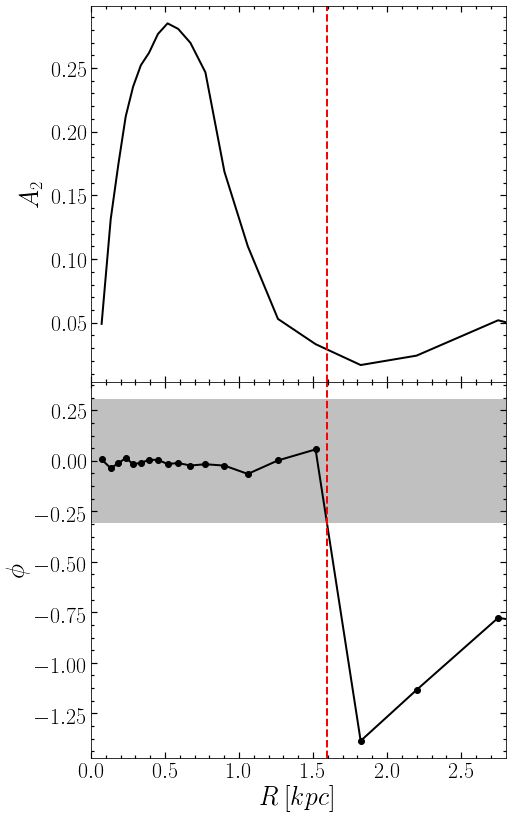

time= 10.205319233 lbar= 1.41322101535


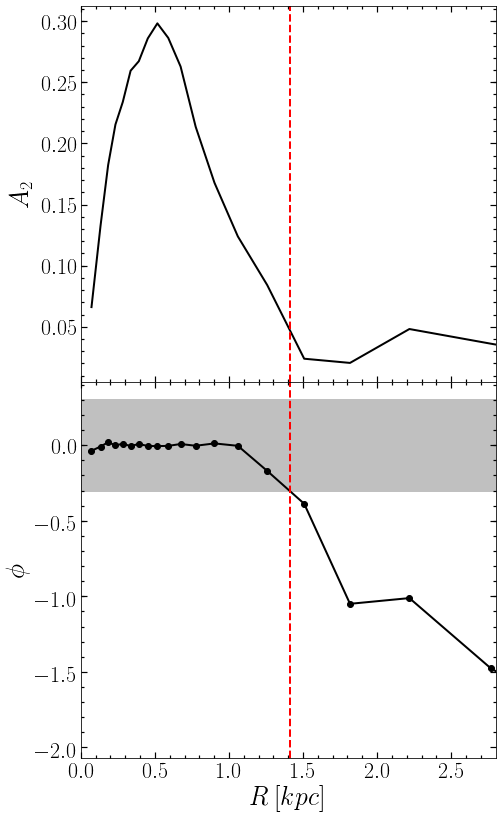

time= 10.1769991429 lbar= 1.58033405876


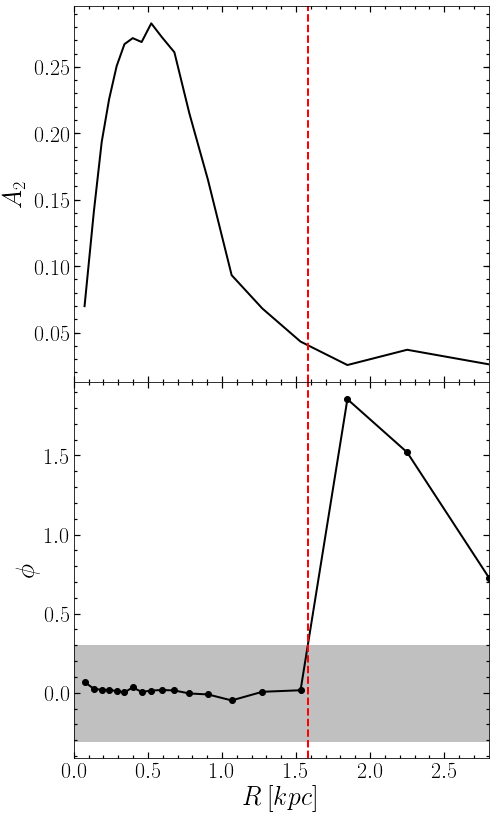

time= 10.1502312835 lbar= 1.58873785298


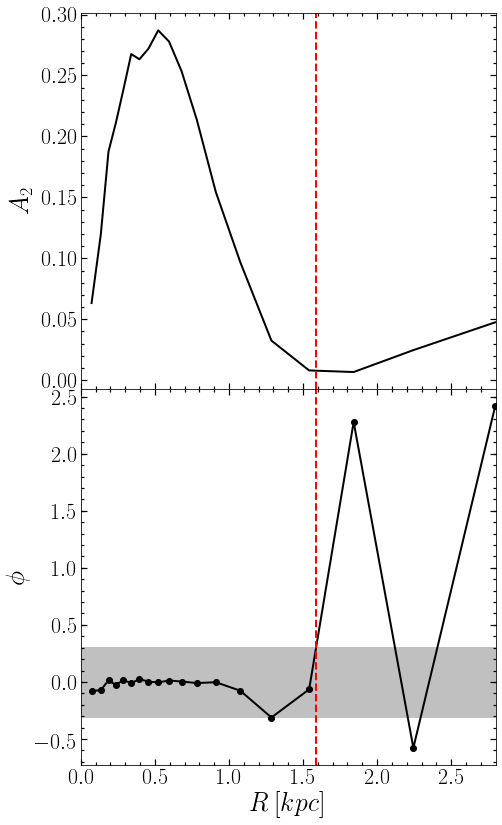

time= 10.1234430124 lbar= 1.58043767532


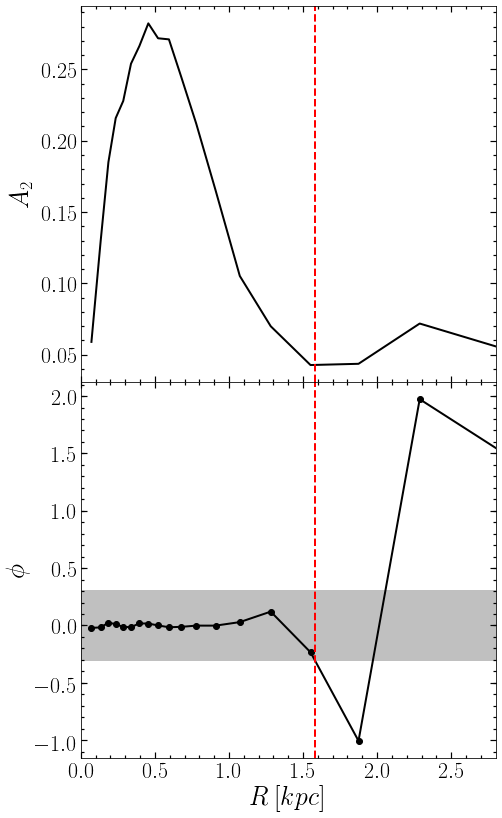

time= 10.0966344217 lbar= 1.67508942915


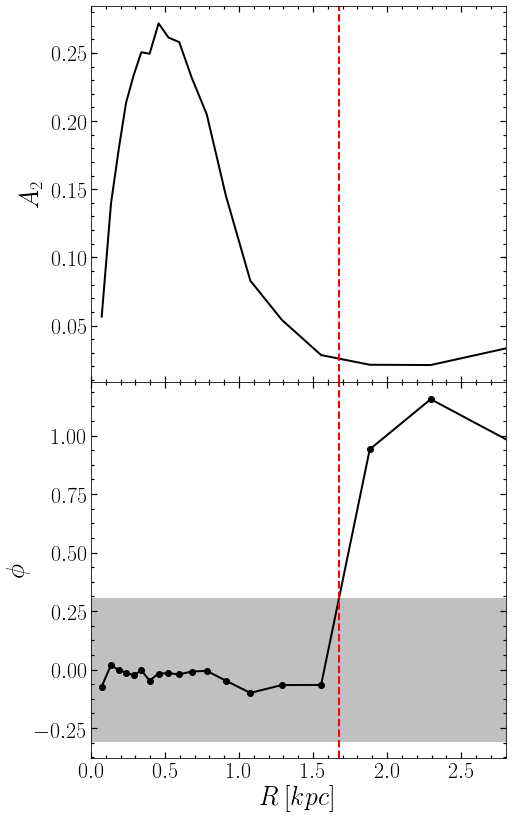

time= 10.0698056051 lbar= 1.58772325017


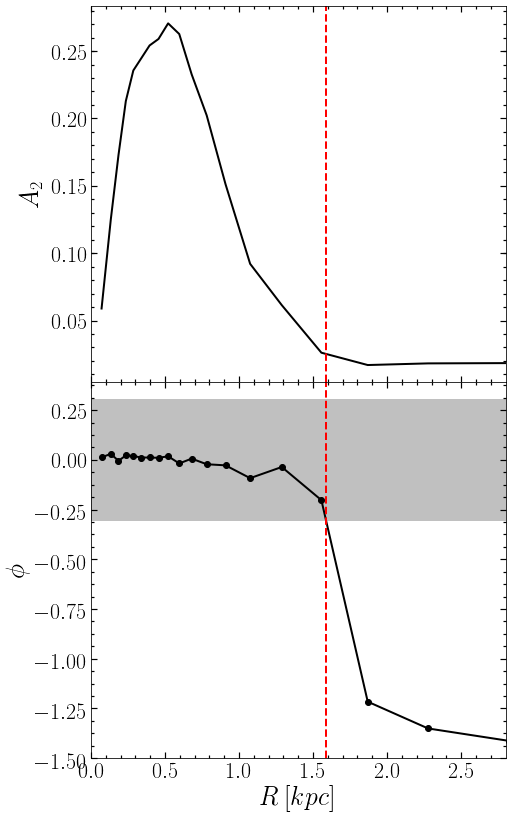

time= 10.0429566571 lbar= 1.64499186712


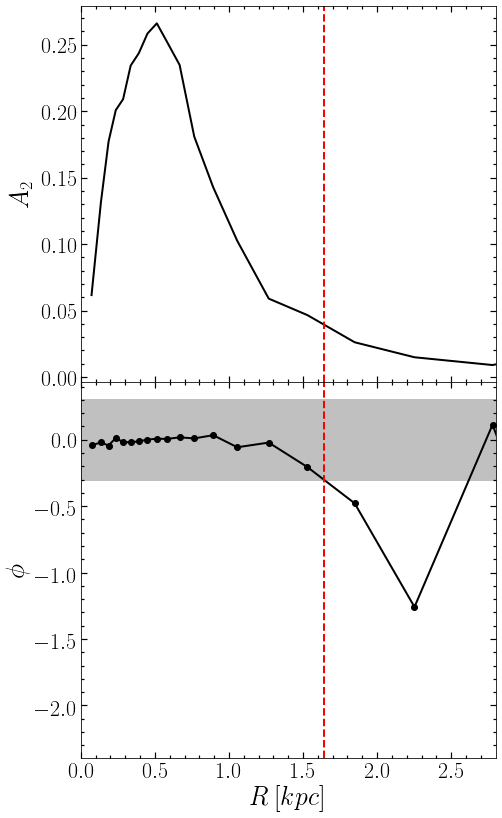

time= 10.0145065233 lbar= 1.96068004835


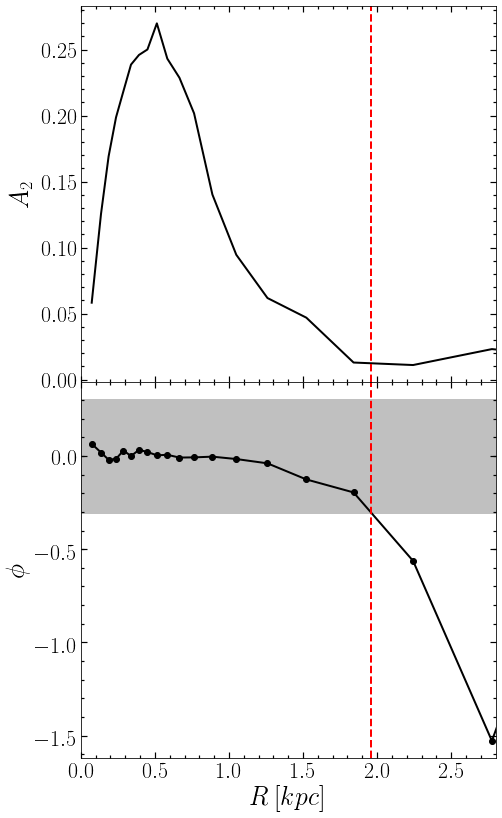

time= 9.98761643173 lbar= 1.27126860647


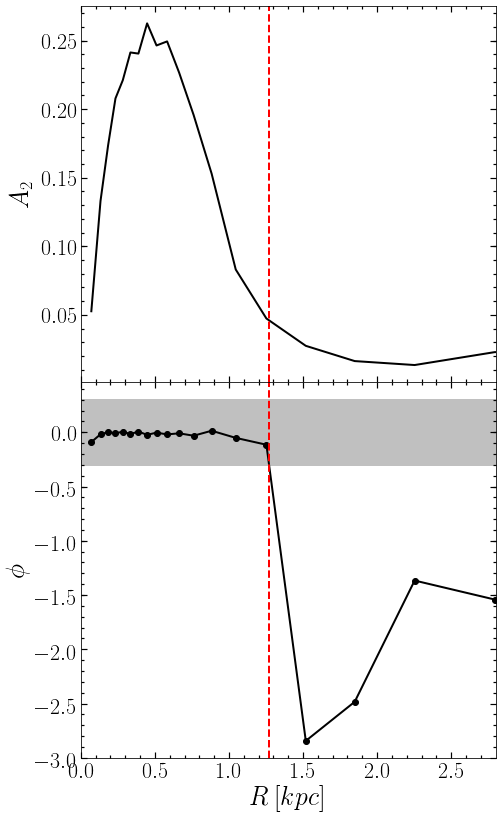

time= 9.96070650593 lbar= 1.27229381971


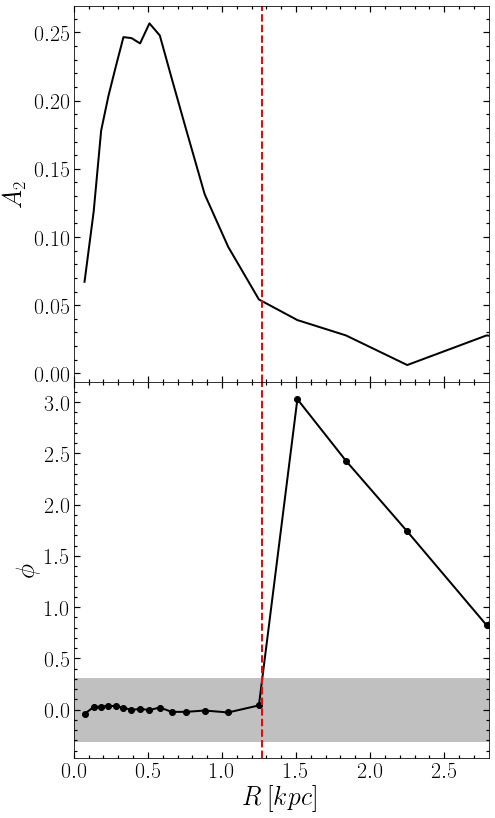

time= 9.93377684557 lbar= 1.27229381971


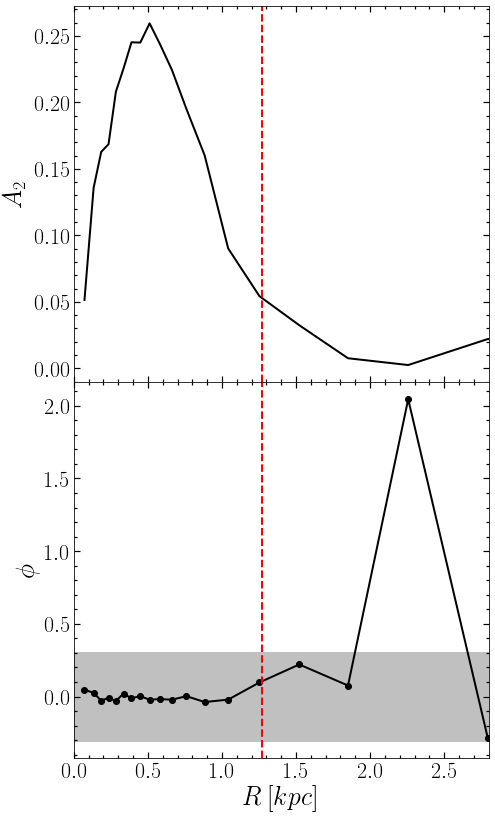

time= 9.90682755153 lbar= 1.9397811356


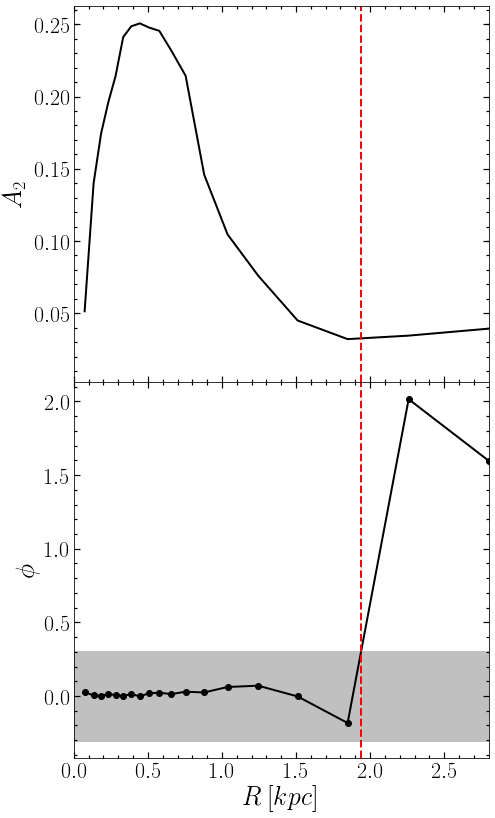

time= 9.87985872594 lbar= 1.69648855849


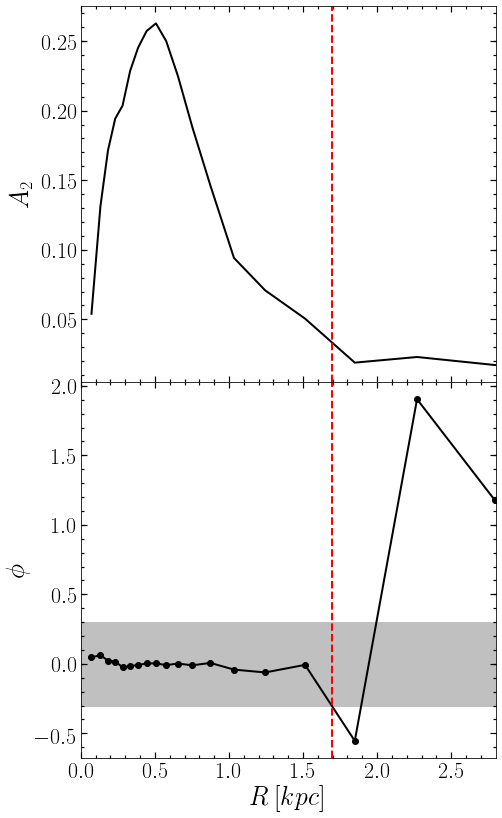

time= 9.85287047218 lbar= 1.63487203661


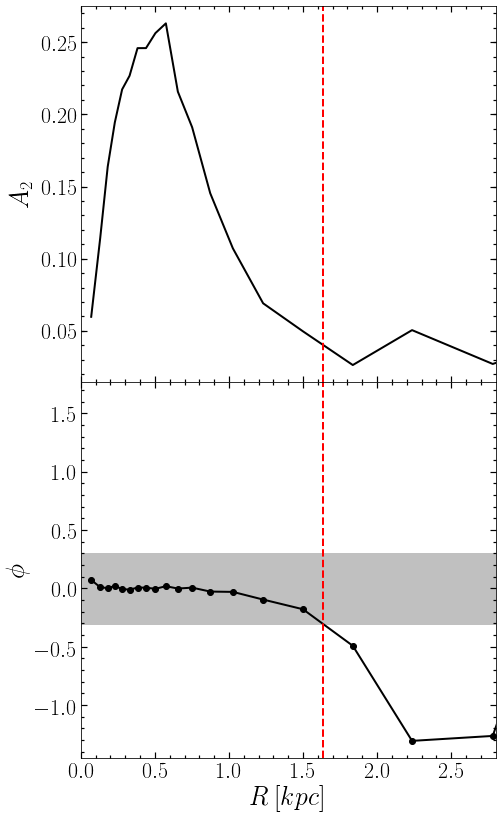

time= 9.82586289491 lbar= 1.57151980751


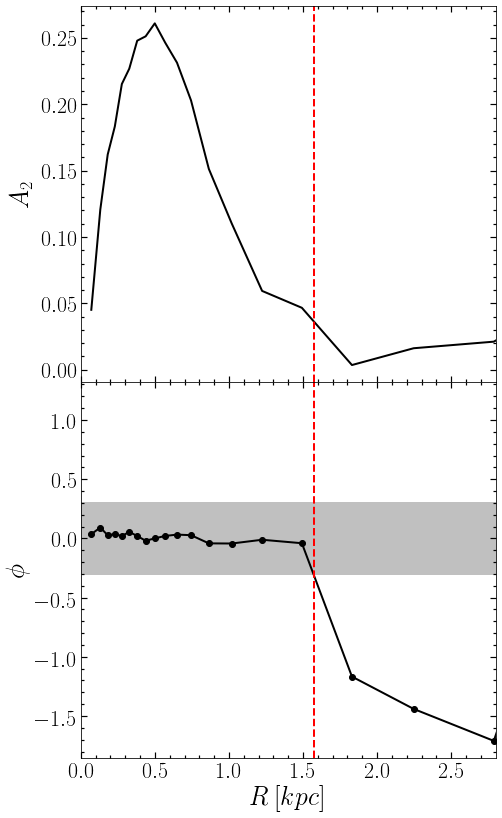

time= 9.79883610004 lbar= 1.85065325064


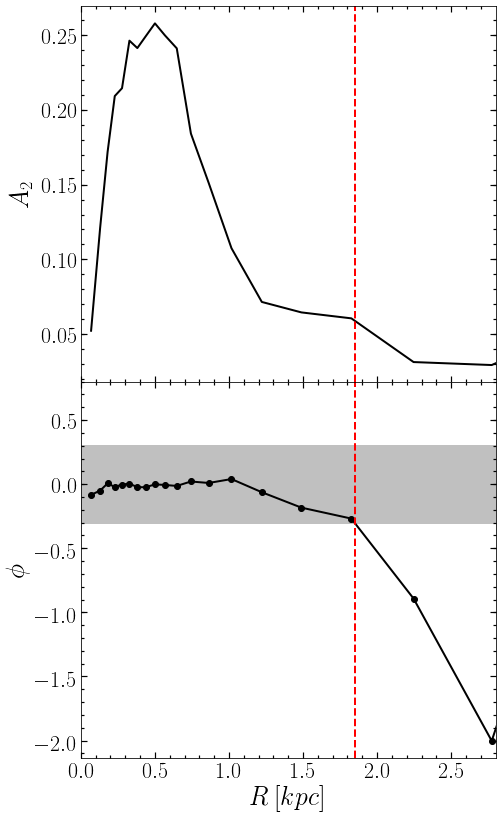

time= 9.77019866635 lbar= 1.59501601733


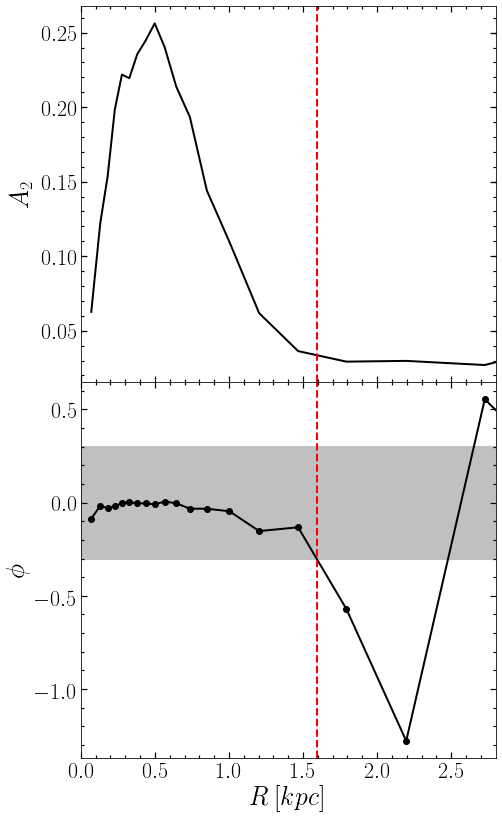

time= 9.74313264482 lbar= 1.73784541036


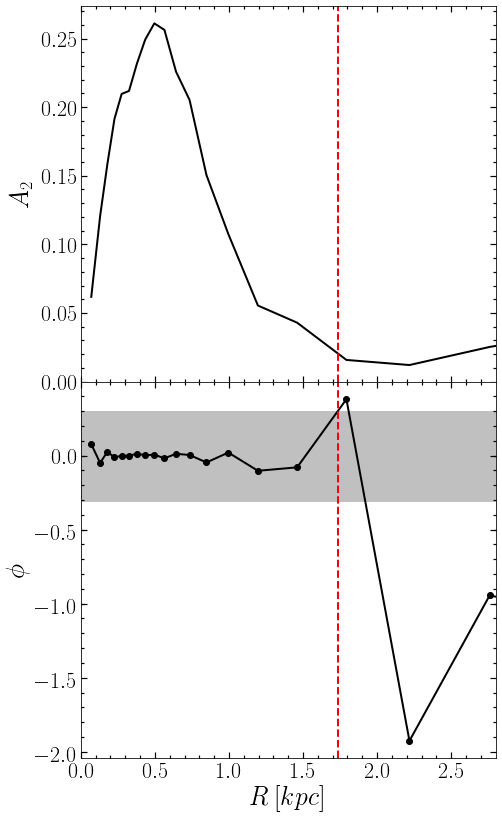

time= 9.71604773765 lbar= 1.93635706518


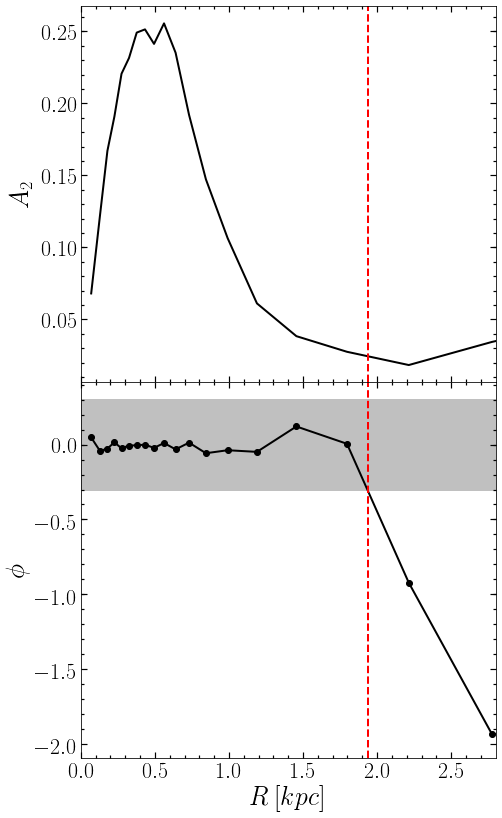

time= 9.68894405601 lbar= 1.46338312258


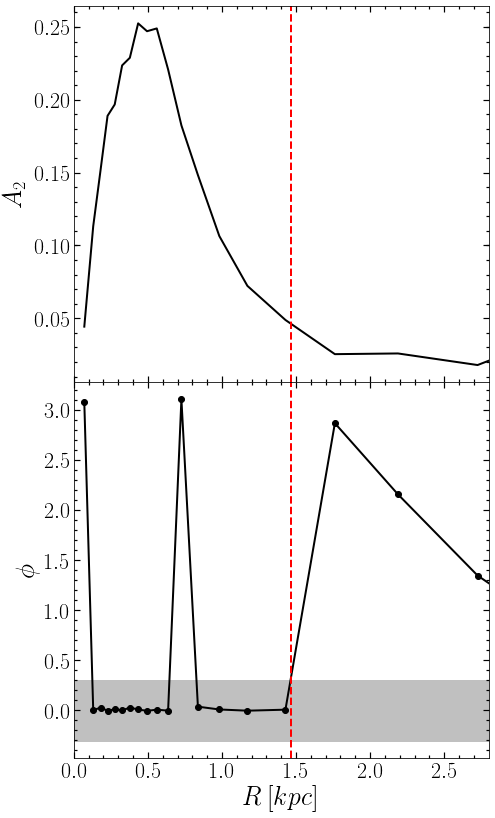

time= 9.66182171235 lbar= 1.46338312258


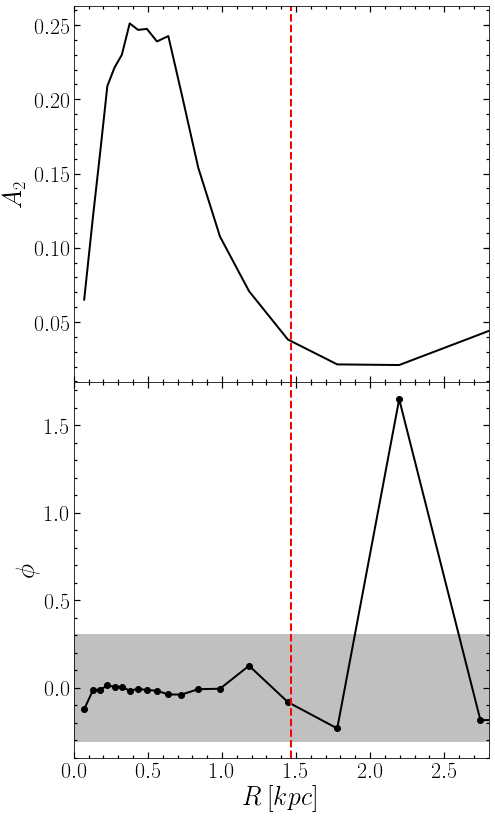

time= 9.63468082046 lbar= 1.39258230357


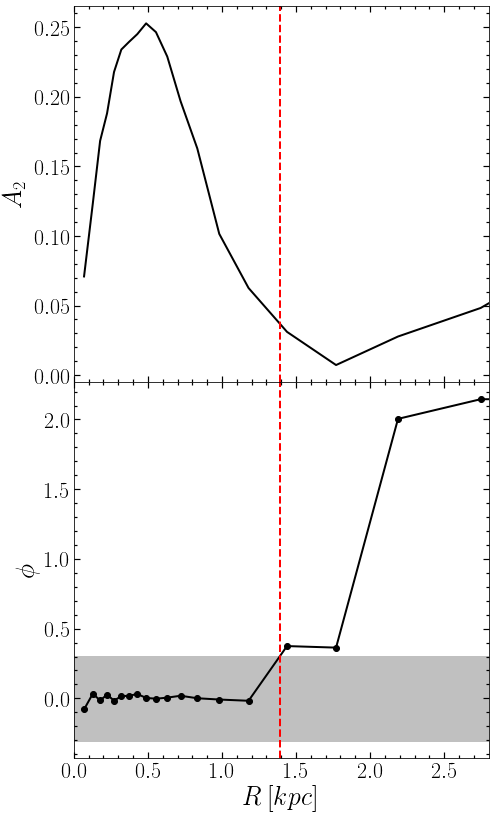

time= 9.60752149544 lbar= 1.81506002891


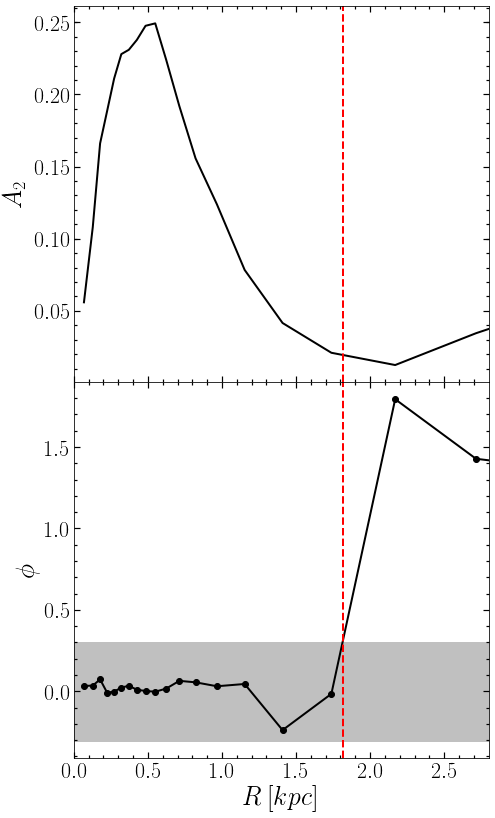

time= 9.58034385372 lbar= 2.57612512234


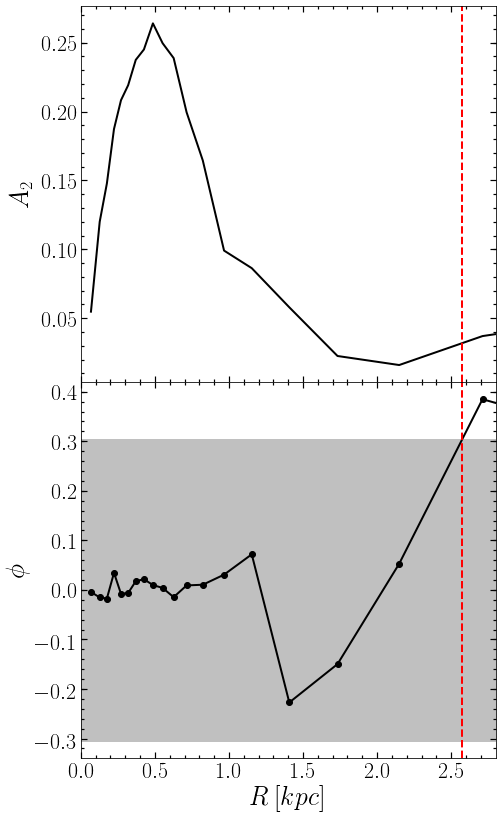

time= 9.55314801307 lbar= 1.419830158


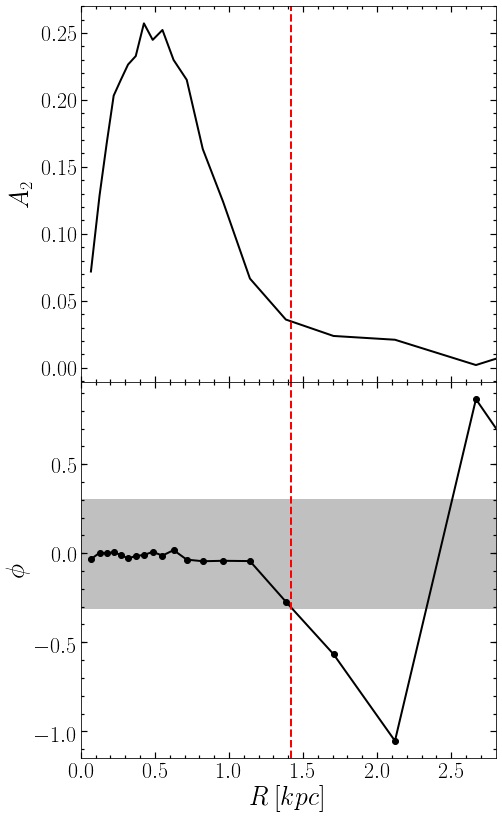

time= 9.5259340926 lbar= 1.72546790887


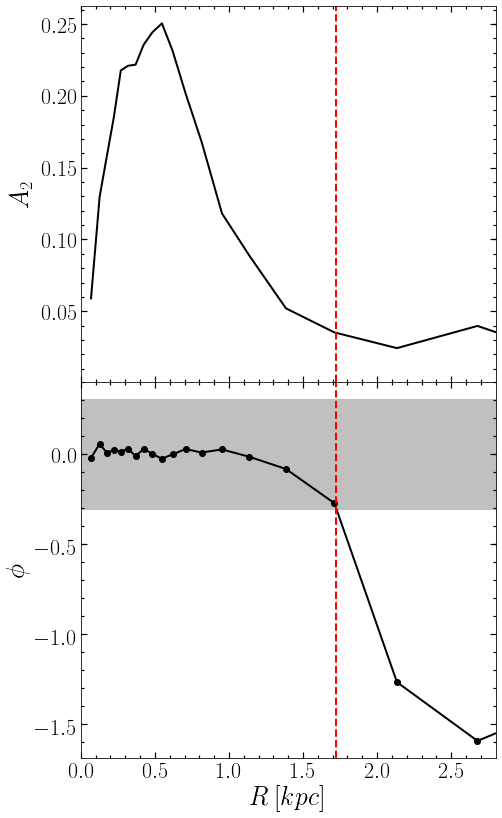

time= 9.49870221277 lbar= 2.21079959798


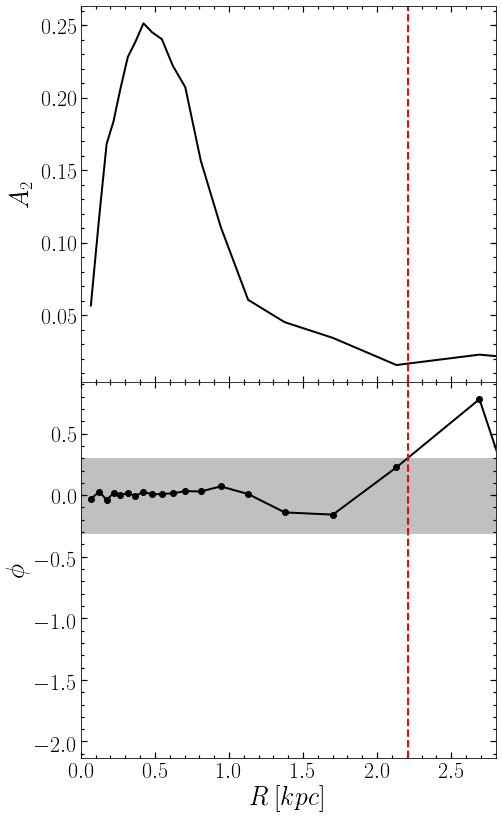

time= 9.47145249542 lbar= 1.55386944401


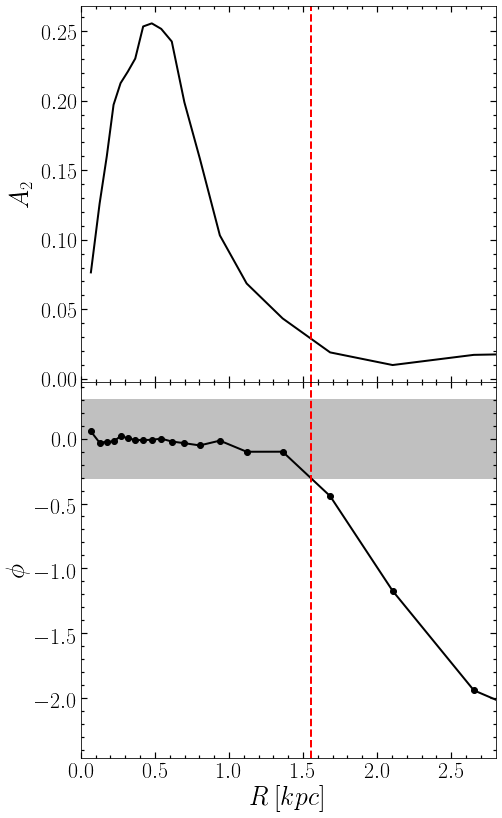

time= 9.44418506372 lbar= 2.00133778078


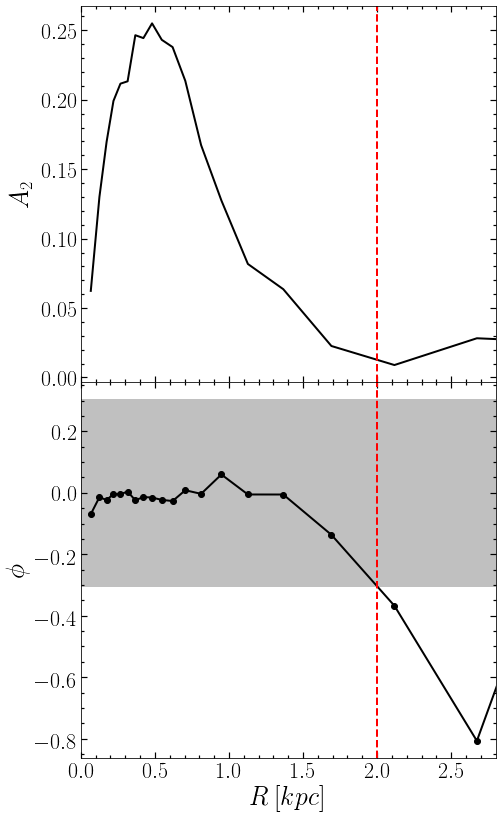

time= 9.41690004224 lbar= 1.38548353341


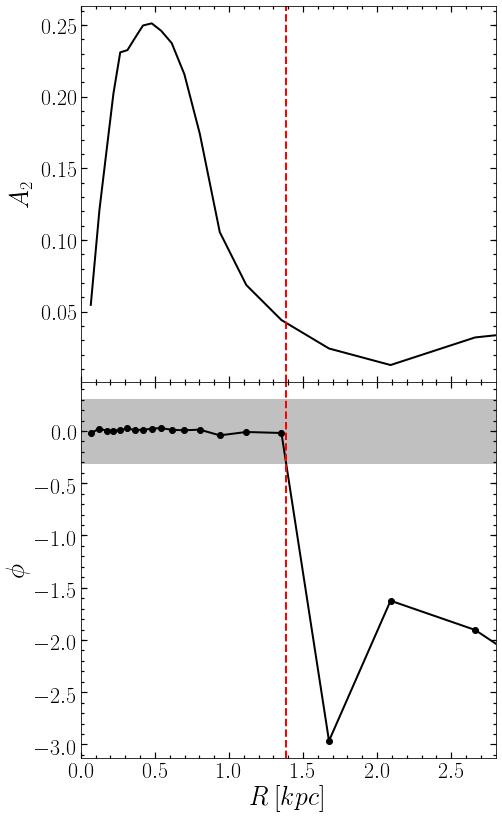

time= 9.38959755691 lbar= 1.67280399358


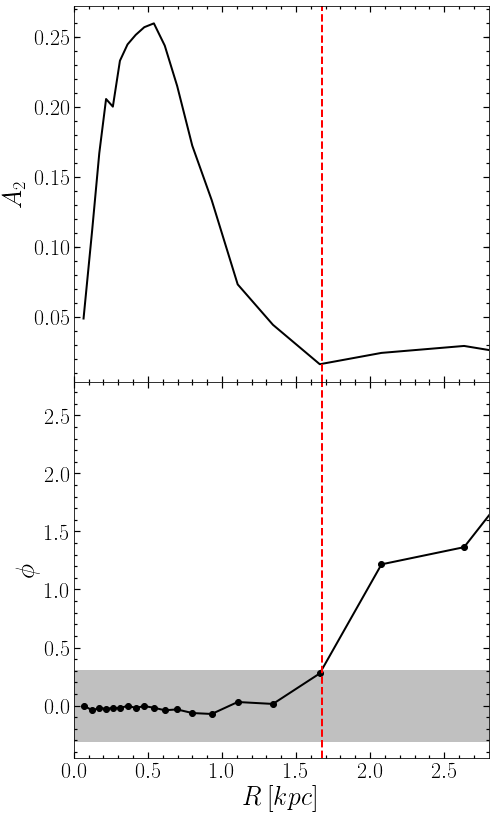

time= 9.36227773506 lbar= 1.74574225692


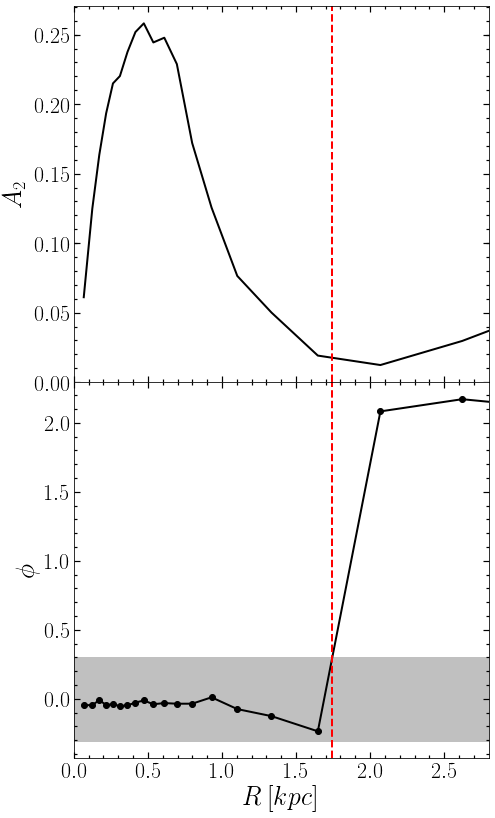

time= 9.33494070541 lbar= 1.74268299905


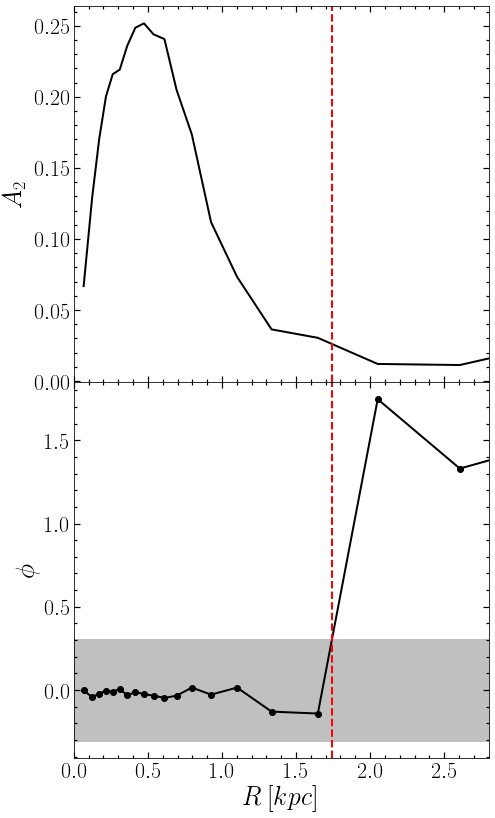

time= 9.30758659807 lbar= 1.68025581631


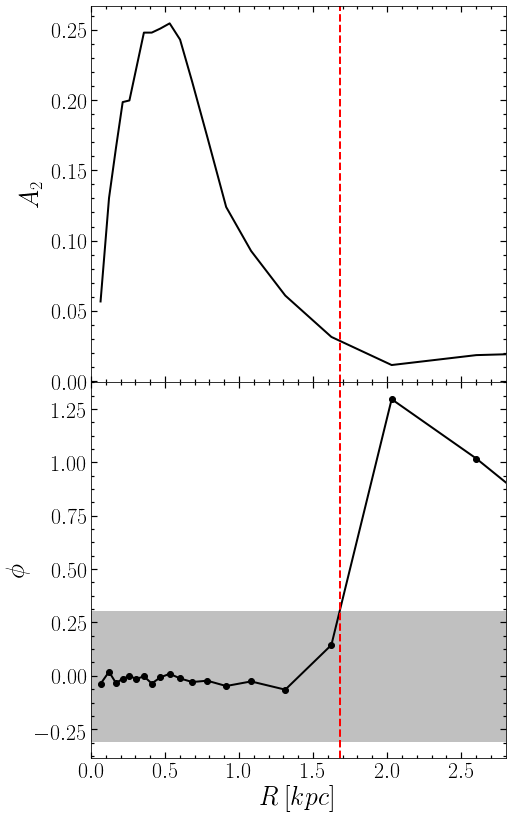

time= 9.28021554457 lbar= 1.68025581631


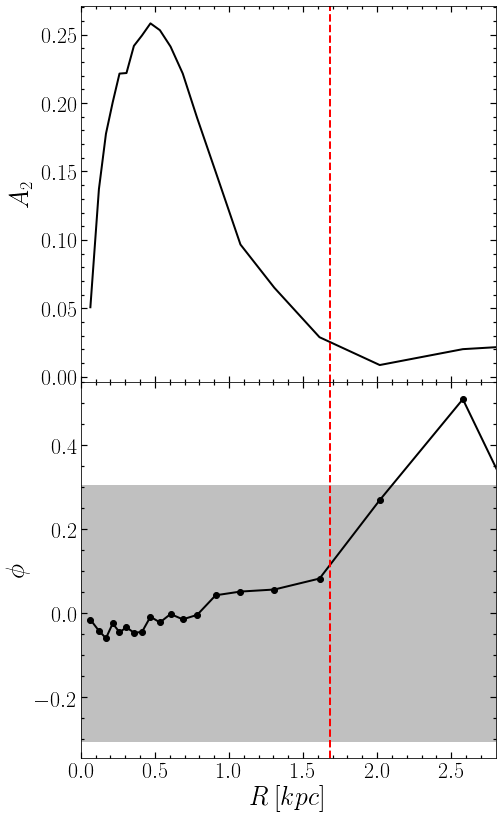

time= 9.25282767784 lbar= 2.08477834651


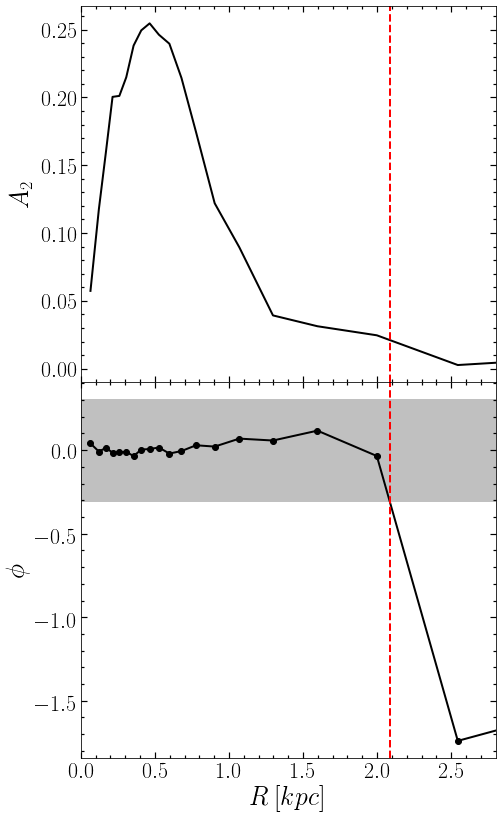

time= 9.22703562361 lbar= 1.76548616294


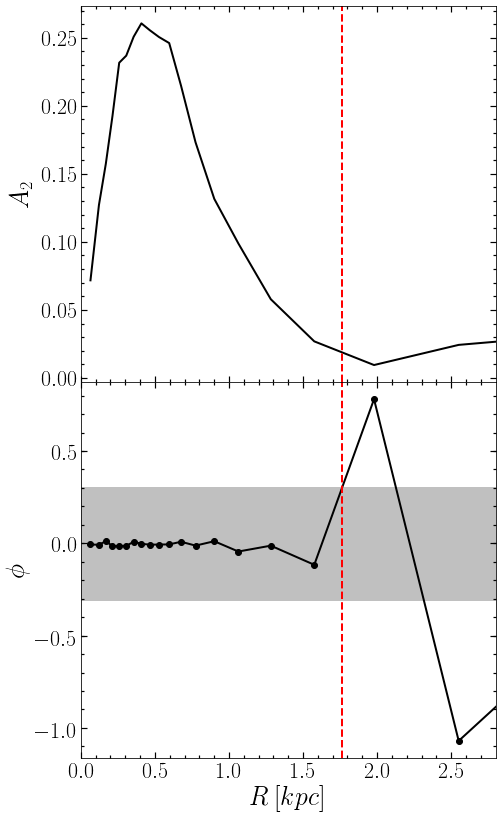

time= 9.19961550426 lbar= 1.76726040527


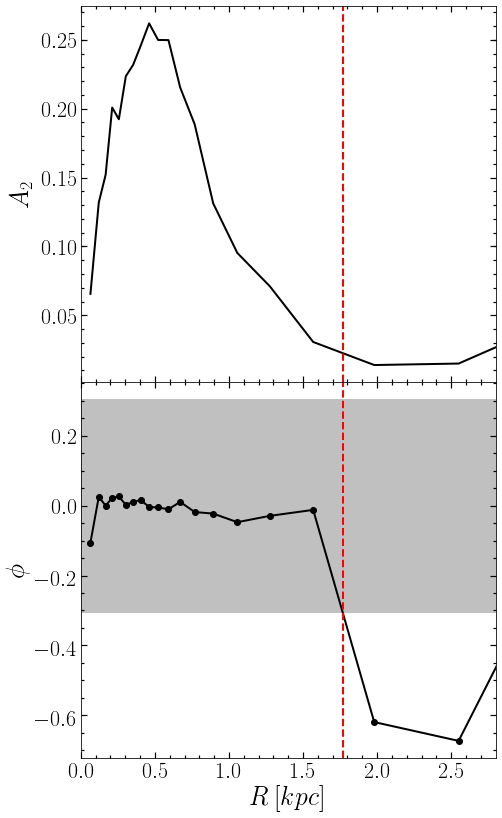

time= 9.17217897093 lbar= 1.51450697142


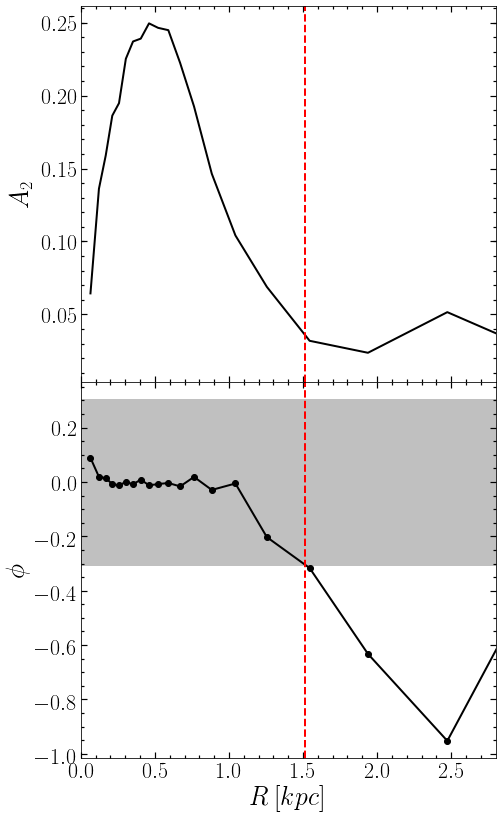

time= 9.14472616218 lbar= 1.43663406791


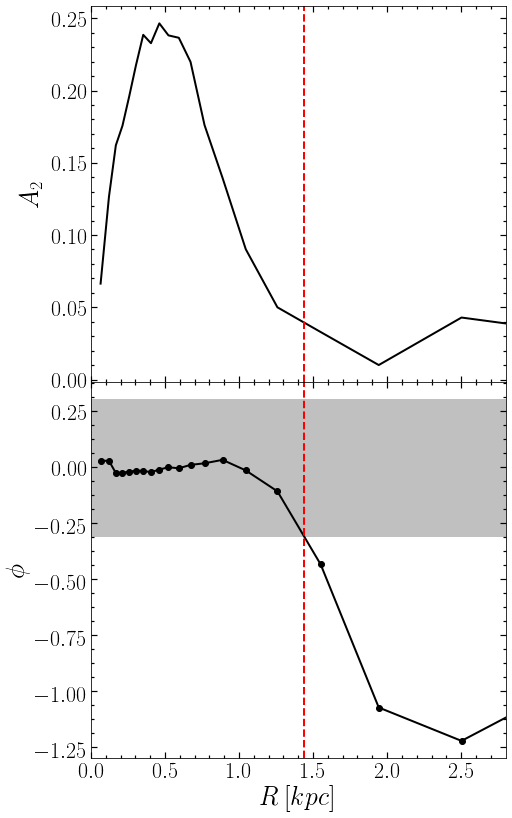

time= 9.11725721804 lbar= 1.65250288694


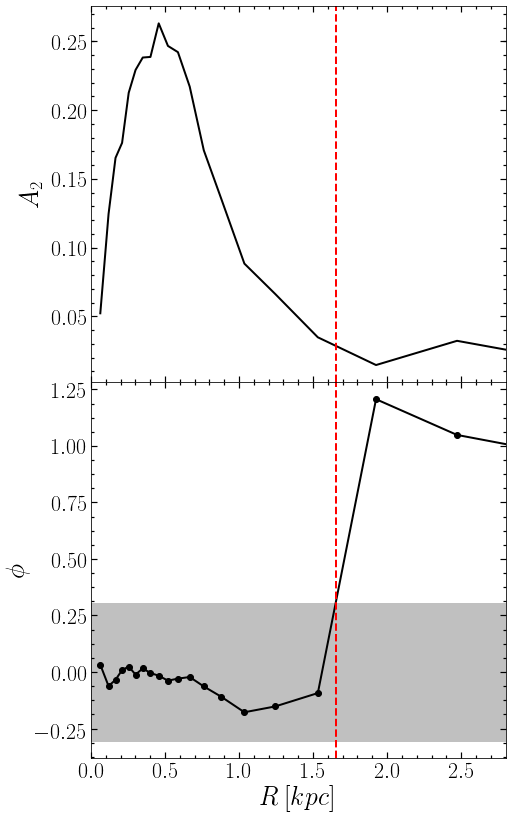

time= 9.08977227998 lbar= 1.71245256463


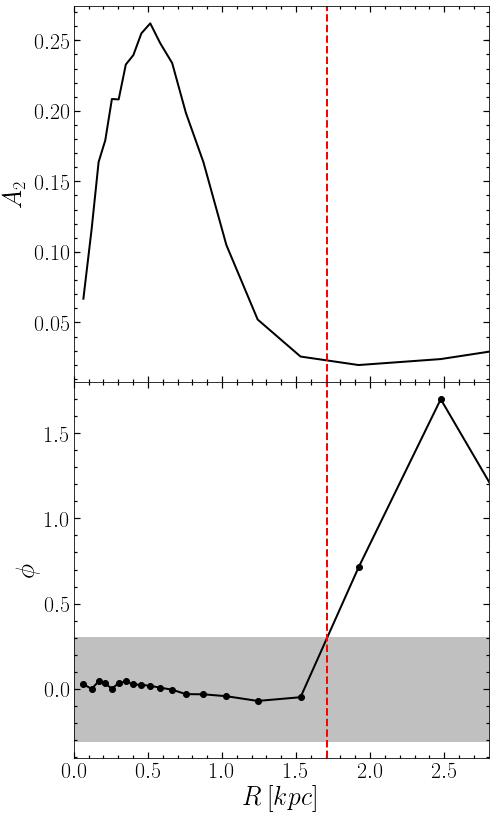

time= 9.06227149091 lbar= 1.97702275242


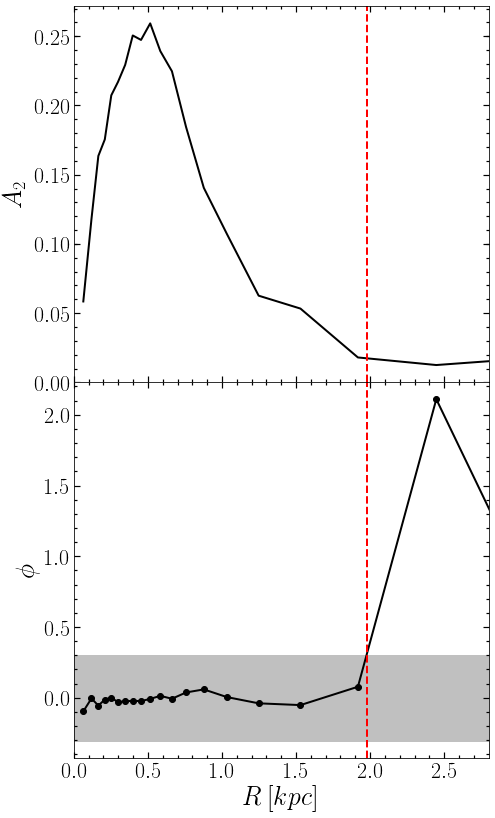

time= 9.03475499523 lbar= 1.56716402022


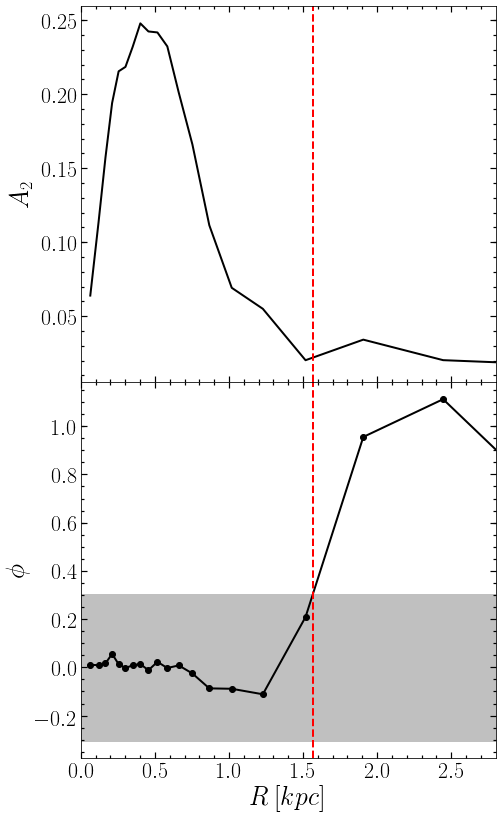

time= 9.00722293881 lbar= 1.8222986462


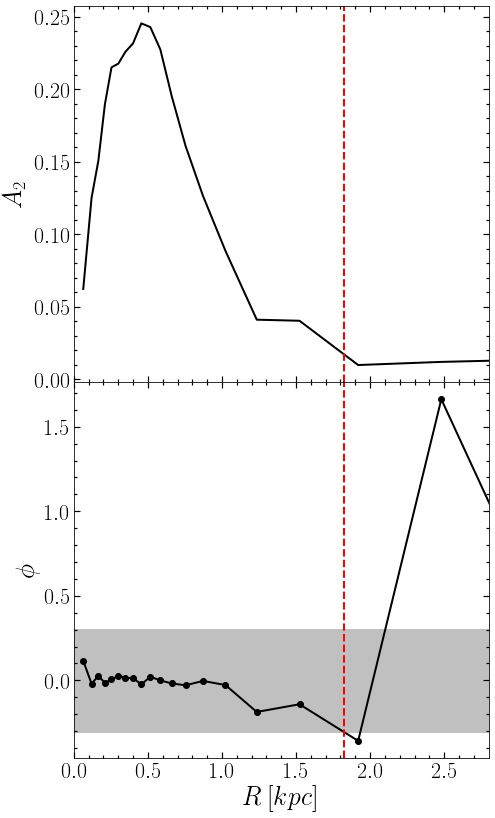

time= 8.97967546898 lbar= 1.81895593107


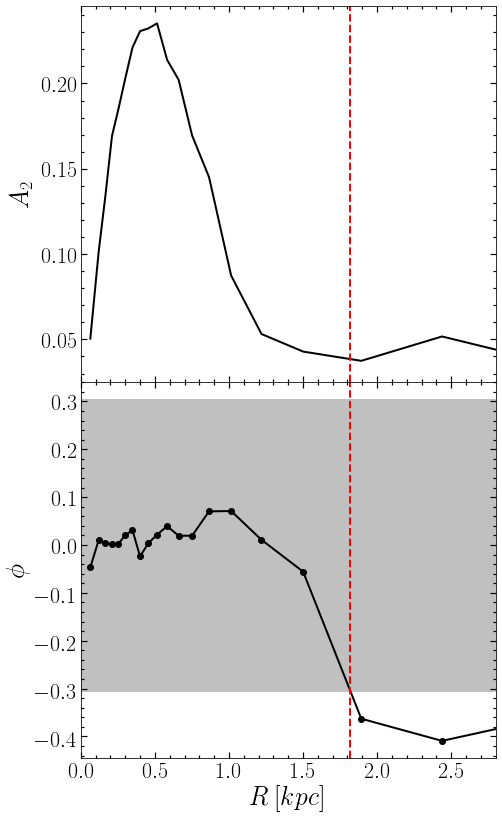

time= 8.95211273457 lbar= 1.81895593107


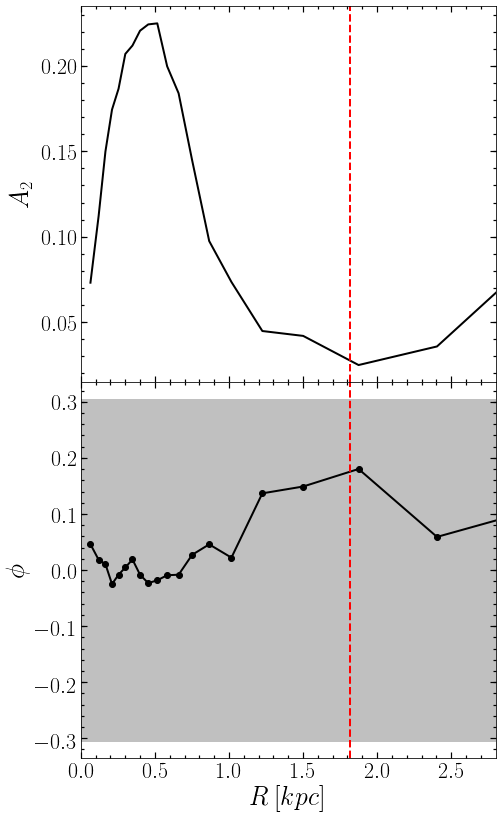

time= 8.9245348859 lbar= 2.04156962145


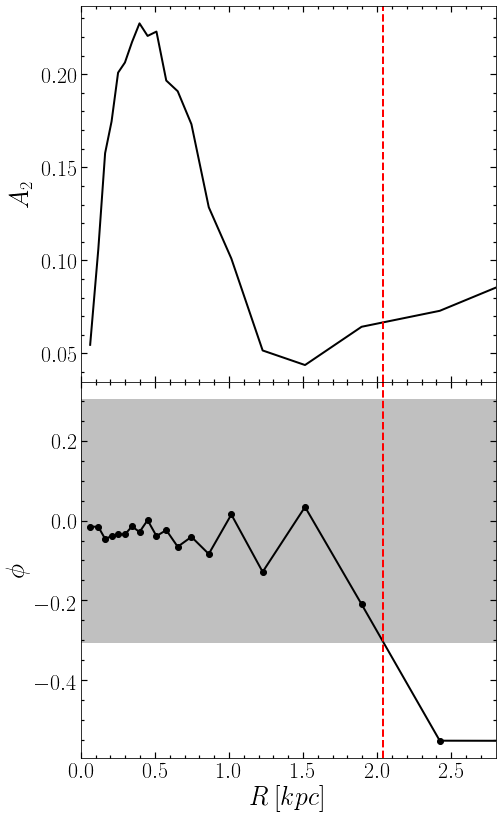

time= 8.89694207476 lbar= 1.53499687155


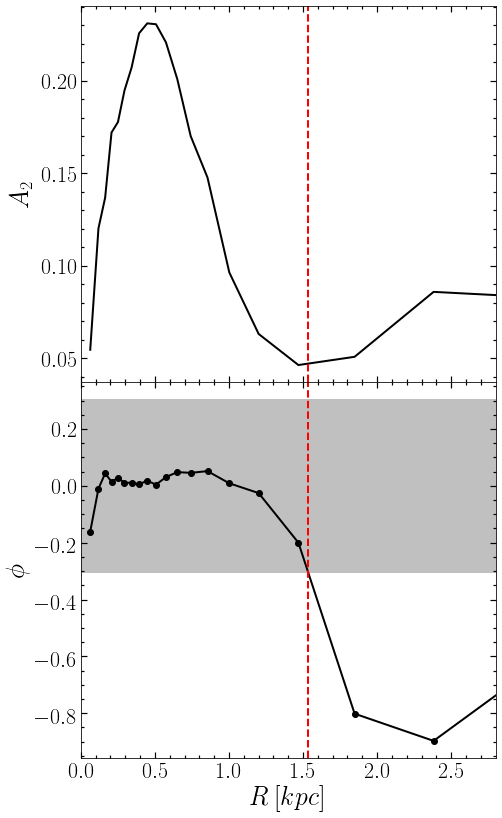

time= 8.86933445448 lbar= 1.53374807816


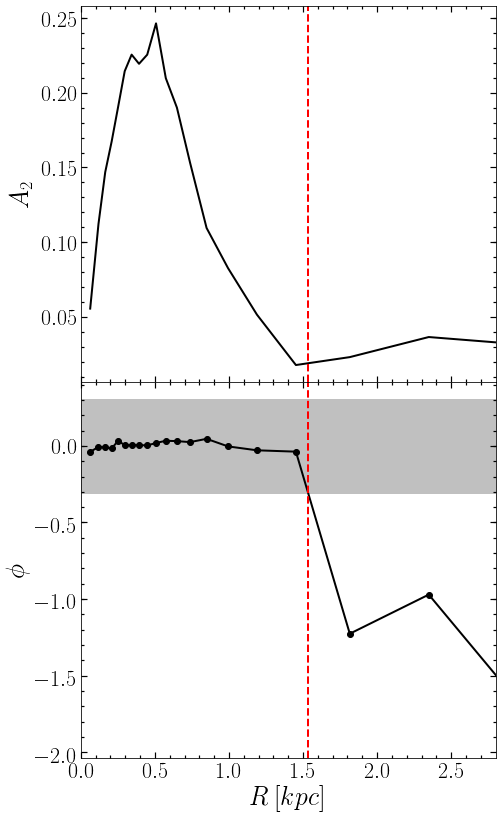

time= 8.84333742242 lbar= 1.6467044776


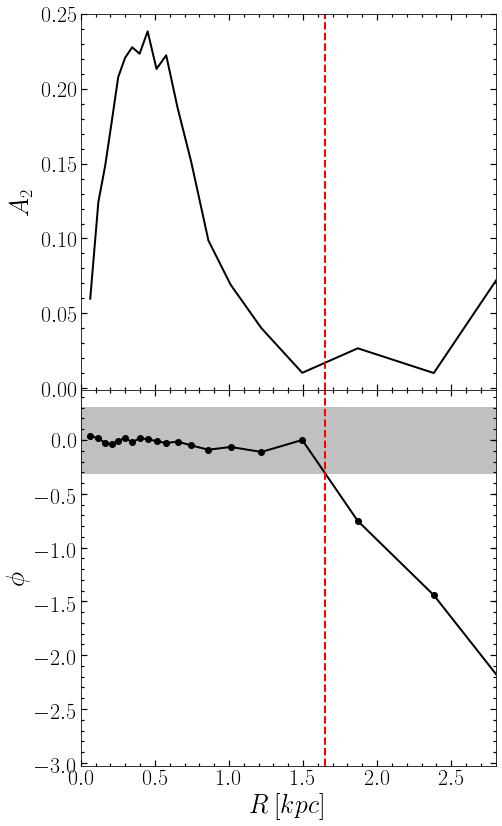

time= 8.81570149828 lbar= 1.12281519516


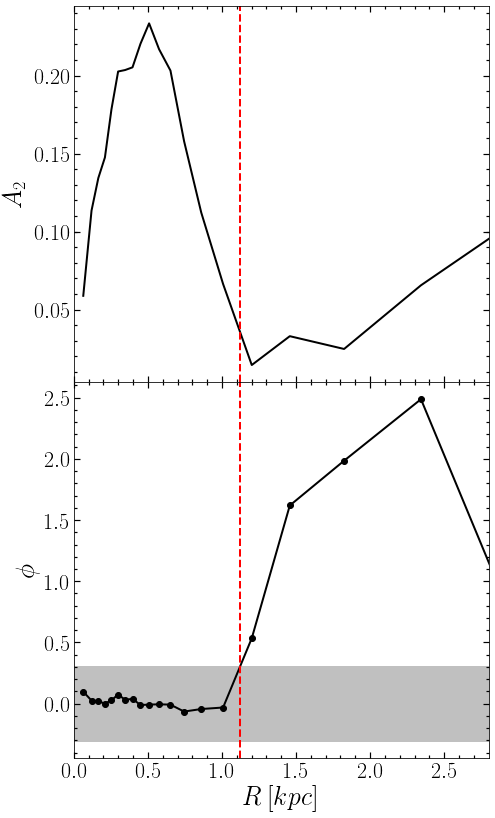

time= 8.78805122467 lbar= 1.52504496599


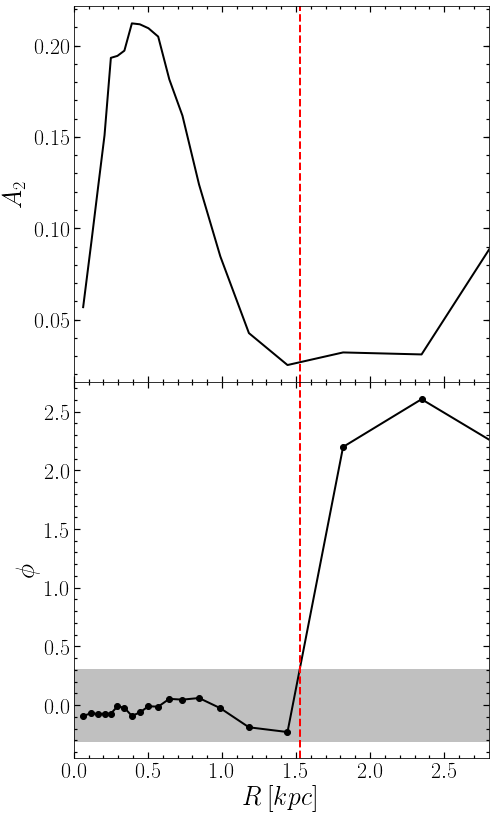

time= 8.76038676087 lbar= 1.32455517281


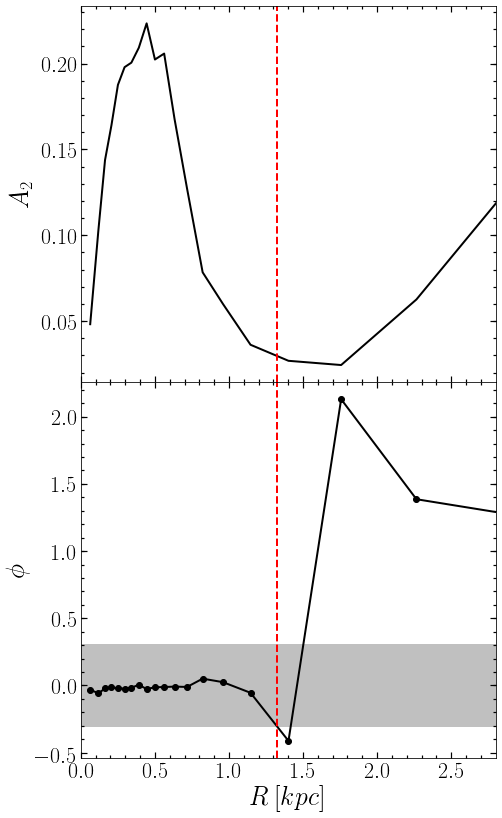

time= 8.7327082677 lbar= 1.32386949091


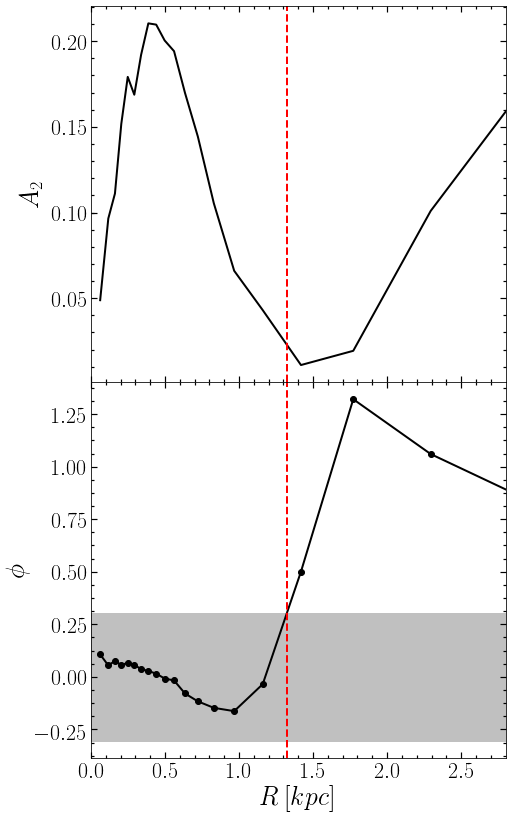

time= 8.70501590751 lbar= 1.32386949091


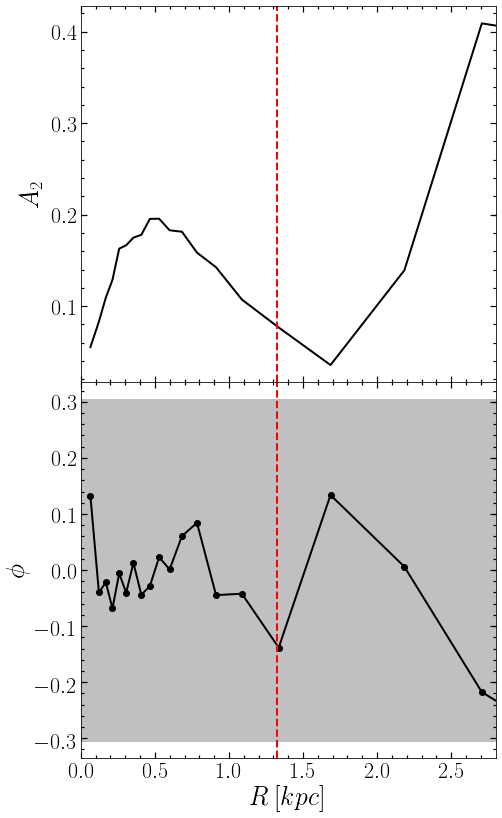

time= 8.67893998899 lbar= 1.32386949091


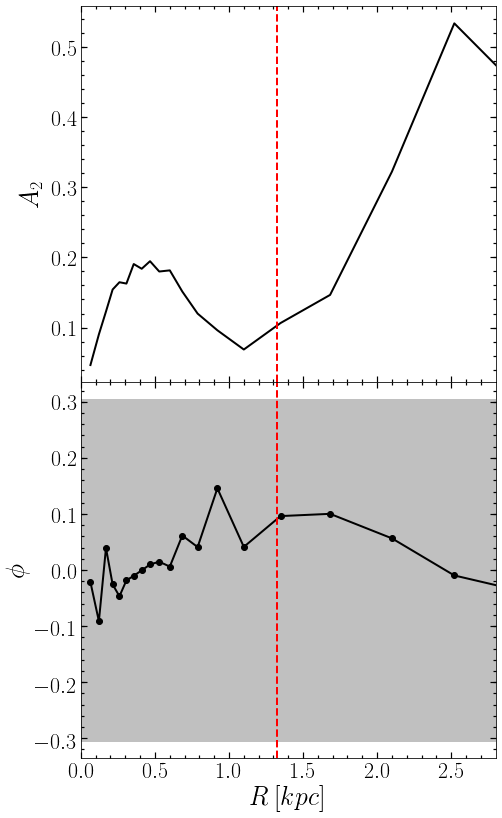

time= 8.65122117972 lbar= 1.32386949091


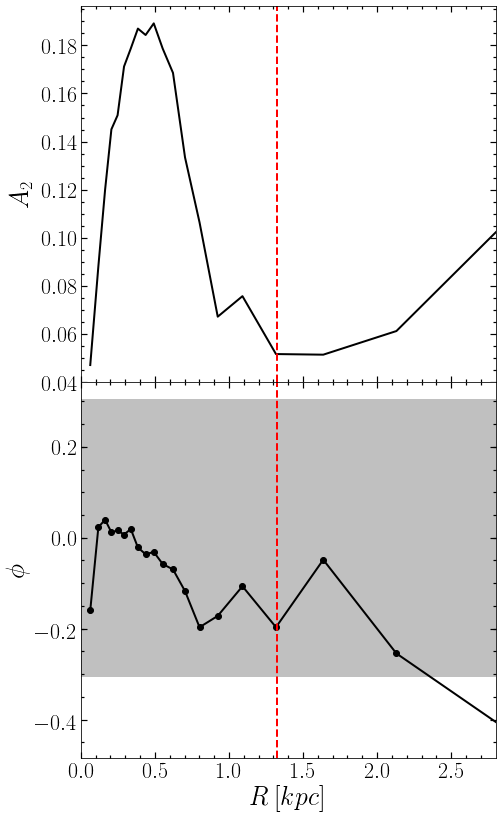

time= 8.62348898988 lbar= 1.38737869871


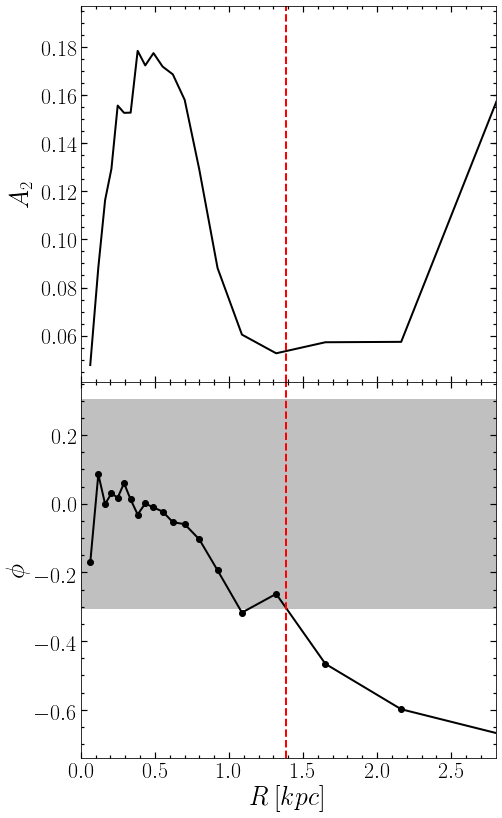

In [8]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength2 as strng
import matplotlib.gridspec as gridspec
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

aa = np.loadtxt('/home/ornela/SimCLUES/redshift_outputs.txt')
aexp = aa[:,2]

snapshot=range(496,300,-1) #SNAPSHOTS

for isnap in snapshot:
    snap = h5py.File('/home/ornela/SimCLUES/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    pstr = snap['subhalo_000/Str/Coordinates'].value
    mstr = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
  
    z     = a0/aexp[isnap] - 1.
    Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    
#paso las velocidades a unidades físicas
    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    mstr = mstr/h     #masa a unidades físicas

    r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

    rgal = 0.15*r200          #defino el radio de la galaxia
#     print 'rgal=', rgal
    
    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa
    
#     print 'r50=', r50
#     print 'r90=', r90
#     print r'log(M+/Msol)=', log10(Mgal*1e10)

#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)
    
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm


# #calculo el raux
# #     raux = 2*r50
# #------------------------------------------------------------------------------------
#     dd = range(496,300,-1)
#     dd.remove(428)
#     if isnap in dd:
#         raux = 2*r50
#     elif (isnap == 428) or ((isnap < 301) & (isnap > 283)):
#         raux = r50
#     elif (isnap > 271) & (isnap < 284):
#         raux = 0.75
#     elif isnap < 272:
#         raux = 0.5
#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    
    corte1,=np.where(r<rgal)
    
#     if isnap in range(256,272):
#         corte2 = np.where(r<0.75)
#     else:
#         corte2 = np.where(r<raux)

    corte1, = np.where(r<3*aexp[isnap])
    corte2, = np.where(r<6*aexp[isnap])
#     corte3, = np.where(r<2*r50)

    A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], 20)
    A2max, rmax, phimax = strng.a2max(mstr[corte1], xn[corte1], yn[corte1], 20)

    
# med = mean(phi[1:5])

    phii = phi - phimax
 
    for i in range(0,len(phii)-2):
        if ((phii[i]<np.arcsin(0.3)) & (phii[i]>-np.arcsin(0.3)) & (phii[i+1]>np.arcsin(0.3))):
            if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
                pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
                ordenada = phii[i]- pend*rbin[i]
                lbar = (np.arcsin(0.3) - ordenada)/pend
                break
        elif ((phii[i]>-np.arcsin(0.3)) & (phii[i]<np.arcsin(0.3)) & (phii[i+1]<-np.arcsin(0.3))):
            if ((phii[i+2]>np.arcsin(0.3)) | (phii[i+2]<-np.arcsin(0.3))):
                pend = (phii[i+1]-phii[i])/(rbin[i+1]-rbin[i])
                ordenada = phii[i]- pend*rbin[i]
                lbar = (-np.arcsin(0.3) - ordenada)/pend
                break
                
    print 'time=', time, 'lbar=', lbar


# fig, (ax1, ax)=plt.subplots(2, sharex=True, figsize=(8,8))
    fig=plt.figure(1,figsize=(8,12))
    fig.subplots_adjust(bottom=0.08, left =0.2, right = 0.92, top = 0.95, wspace=0.03, hspace= 0)
    ax1=fig.add_subplot(211)
    ax1.plot(rbin,A2,'-', lw=2, color='k')
    ax1.set_xlim(0.0,2.8)

    # ax.set_xlim(2,14)
    # ax.set_ylim(0.,0.5)
    # ax.spines['bottom'].set_color('w')
    # ax.spines['top'].set_color('w')
    # ax.spines['left'].set_color('w')
    # ax.spines['right'].set_color('w')
    ax1.set_xticklabels([])
    ax1.minorticks_on()
    ax1.tick_params( labelsize=22) #colors='lightgray')
    ax1.tick_params('both', length=3, width=1.2, which='minor', direction='in', right='on',top='on')#,colors='w')
    ax1.tick_params('both', length=6, width=1.2, which='major', direction='in', right='on',top='on')#,colors='w')  
    ax1.axvline(x=lbar, color='r', lw=2, ls='--')
    # ax.set_facecolor('silver')
    # ax.grid(color='w',linestyle=':',which='major')
    #ax.grid(color='lightgray',linestyle=':',which='minor')
    # ax1.set_xlabel(r'$R$ $[kpc]$', fontsize=26 )#, color='lightgray')
    ax1.set_ylabel(r'$A_{2}$',fontsize=26)#, color='lightgray')

    ax=fig.add_subplot(212)
    ax.fill_between([rbin[0]-0.5,rbin[-1]+0.5],np.arcsin(0.3),-np.arcsin(0.3), color='silver')
    ax.plot(rbin,phii,'ko-', lw=2, color = 'k')
    # ax.set_ylim(0,0.5)
    ax.set_xlim(0,2.8)
    #ax.set_title('subhalo_0'+ str('%s'%vector[i]), fontsize=24)
    # ax.spines['bottom'].set_color('w')
    # ax.spines['top'].set_color('w')
    # ax.spines['left'].set_color('w')
    # ax.spines['right'].set_color('w')
    ax.minorticks_on()
    ax.tick_params( labelsize=22)#, colors='w')
    ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')#,colors='w')
    ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')#,colors='w')  
    # ax.set_facecolor('silver')
    # ax.grid(color='w',linestyle=':',which='major')
    #ax.grid(color='lightgray',linestyle=':',which='minor')
    ax.set_xlabel(r'$R\:[kpc]$', fontsize=26)#, color='w')
    ax.set_ylabel(r'$\phi$',fontsize=26)#, color='w')
    ax.axvline(x=lbar, color='r', lw=2, ls='--')
    # ax.axhline(y=np.arcsin(0.3), color='r', lw=2, ls='--')
    # ax.axhline(y=-np.arcsin(0.3), color='r', lw=2, ls='--')
    # ax.axvline(x=rmax, color='b', lw=2, ls='--')
    # ax.axhline(y=A2max, color='b', lw=2, ls='--')
    #     plt.text(x = 2, y = 0.43, 
    #              s =r'$R_{max}=$' +str('%.3f'%rmax)+', $A_{2}^{max}=$' + str('%.3f'%A2max),
    #              fontsize = 20, va= 'center', ha= 'left', color = 'k')
    #     plt.annotate('$l_{bar} =$'+ '%.2f'%lbar, xy=(lbar,0), xytext=(0, +80), textcoords='offset points', 
    #                          fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="center")

    plt.show()



## Rcorot y Lbar en funcion del tiempo

In [39]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np
import time_conversion as tiempo

h=0.732
a0=1
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
G = 4.299e-6

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

#fo =open('/home/ornela/python/fdisc.dat','a')

snapshot=range(309,308,-1)
for isnap in snapshot:

    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    pstr = snap['subhalo_000/Str/Coordinates'].value
    cm   = snap['subhalo_000/Center'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
    masa_str = snap['subhalo_000/Str/Masses'].value
    r200 = snap['subhalo_000/R200'].value

    pgas = snap['subhalo_000/Gas/Coordinates'].value
    masa_gas = snap['subhalo_000/Gas/Masses'].value

    pdrk = snap['subhalo_000/Drk/Coordinates'].value
    masa_drk = snap['subhalo_000/Drk/Masses'].value
        
#-------------paso las coordenadas respecto al centro de la galaxia------------------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
    ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
    zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
    ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
    zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

#---------------masas------------------------------------
    masa_str = masa_str/h
    masa_gas = masa_gas/h
    masa_drk = masa_drk/h

    r200 = r200*aexp[isnap]/h
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])

#----------------------calculamos r50---------------------------    
    M_gal = Mc_str[-1]

    razon = Mgal_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]

#----------calculamos la masa total----------------------
    rtot= concatenate([r,rgas,rdrk])
    mtot= concatenate([masa_str, masa_gas, masa_drk])

    limit_tot = np.where(rtot<r200)
    rtot_sort = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])

    Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])
    M_total = Mc_tot*1e10

#-------------calculamos la velocidad maxima a r50 y Vstr---------------------
    V50 = np.sqrt((G*M_total[cincuenta])/rtot_sort[cincuenta])
    V_50 = V50[-1]
    Vdisc = np.sqrt((G*Mc_str[-1]*1e10)/r50[-1])
    
    Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)
    Vmax = max(Vtot)
#------------calculamos el parametro de inestabilidad del disco----------------
    fdisc = V_50/Vdisc
    
    print 'f_disc=', fdisc
    
    fdec = V_50/Vmax
    
    print 'f_dec=', fdec

#     fo.write(str('%.6f'% t) +'\t'+
#              str('%12.6f'% epsilon) +'\n')
#     fo.close()
        
        

f_disc= 0.890701305895
f_dec= 0.981484
